# Capstone project by PAUL MELLET: Data-driven avalanche hazard prediction

# Part 2: Data Cleaning & Exploratory Data Analysis

## A. Data Cleaning

#### A. 1. First entries and size of the dataset

We first download all the table we need.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import missingno as msno

%matplotlib inline

In [2]:
import sys
sys.path.append("..")

In [3]:
# Download the data and meta data

# Our dataset
data = pd.read_csv("../datasets/data_rf1_forecast.csv")

# Keep only the metadata of stations that are in our dataset 
stations = pd.read_csv("../datasets/stations.csv")
stations = stations[stations.station_code.isin(data.station_code)]
stations.drop("network", axis = 1, inplace = True) # The network is always IMIS
stations.reset_index(drop=True, inplace=True)

# Concatenating metadata related to meteorological and profile variables
meta_data_1 = pd.read_excel("../datasets/nhess-22-2031-2022-t05.xlsx") # Meteorological variables
meta_data_2 = pd.read_excel("../datasets/nhess-22-2031-2022-t06.xlsx") # Profile variables
meta_data = pd.concat([meta_data_1, meta_data_2], axis=0)
meta_data.reset_index(drop=True, inplace=True)

# Store the warning regions definition in a DataFrame
url = "https://aws.slf.ch/api/warningregion/warnregionDefinition"
request = requests.get(url)
warnreg_def = request.json()
warnreg_def = pd.DataFrame.from_dict(warnreg_def)


For convenience purposes, we placed functions that required long codes in a different Python file. These functions only aim to show meaningful tables, graphics, classification reports and confusion matrices of the machine learning model that we will train in a second time. You can find the codes in the file `functions.py` in this same repository.

Also, you will find some images and maps that were generated using the library GeoPandas. The GeoPandas version used required to downgrade some of the main libraries that we are using for this project like Numpy and thus worked on a different environnment to plot these maps. Those codes lies in the notebook `warnreg.ipynb` and rely on the libraries version listed in the file `warnreg.yml`. You can also find these files in this repository.

Let's have a look on the first entries of our dataset.

In [4]:
data.head()

Unnamed: 0       datum station_code  sector_id  warnreg  elevation_station  \
0           0  1997-11-11         KES2     7113.0     15.0             2700.0   
1           1  1997-11-11         SIM2     6113.0     15.0             2400.0   
2           2  1997-11-11         DTR2     6113.0     15.0             2100.0   
3           3  1997-11-11         MEI2     2221.0     15.0             2200.0   
4           4  1997-11-11         SPN2     4232.0     15.0             2600.0   

  forecast_initial_date    forecast_end_date  dangerLevel  elevation_th  ...  \
0   1997-11-11 17:00:00  1997-11-12 17:00:00          1.0        2000.0  ...   
1   1997-11-11 17:00:00  1997-11-12 17:00:00          2.0        2000.0  ...   
2   1997-11-11 17:00:00  1997-11-12 17:00:00          2.0        2000.0  ...   
3   1997-11-11 17:00:00  1997-11-12 17:00:00          1.0        2000.0  ...   
4   1997-11-11 17:00:00  1997-11-12 17:00:00          2.0        2000.0  ...   

  ssi_pwl  sk38_pwl  sn38_pwl  ccl_pwl  ssi_pwl_100  sk38_pwl_100  \
0    2.02      1.02      1.92     0.30         2.02          1.02   
1    6.00      6.00      6.00     4.00         6.00          6.00   
2    1.44      0.44      1.37     0.12         1.44          0.44   
3    6.00      6.00      6.00     0.20         6.00          6.00   
4    6.00      6.00      6.00     4.00         6.00          6.00   

   sn38_pwl_100  ccl_pwl_100  Pen_depth  min_ccl_pen  
0          1.92         0.30  44.028391         0.17  
1          6.00         4.00  37.271809         0.26  
2          1.37         0.12  38.369101         0.12  
3          6.00         0.20  20.400000         4.00  
4          6.00         4.00  42.332551         0.16  

[5 rows x 78 columns]

We remove the first column as it is a copy of the index.

In [5]:
data.drop("Unnamed: 0", axis=1, inplace=True)

The numbers of features and samples are: 

In [6]:
data.shape

(292837, 77)

#### A. 2. Information conveyed by the features

The first 10 features are not meteorological or profile variables, we check them first and will come back to the other ones later.  

In [7]:
data.iloc[:,:10].head(7)

datum station_code  sector_id  warnreg  elevation_station  \
0  1997-11-11         KES2     7113.0     15.0             2700.0   
1  1997-11-11         SIM2     6113.0     15.0             2400.0   
2  1997-11-11         DTR2     6113.0     15.0             2100.0   
3  1997-11-11         MEI2     2221.0     15.0             2200.0   
4  1997-11-11         SPN2     4232.0     15.0             2600.0   
5  1997-11-11         TUJ2     5211.0     15.0             2300.0   
6  1997-11-11         KLO2     5111.0     15.0             2100.0   

  forecast_initial_date    forecast_end_date  dangerLevel  elevation_th    set  
0   1997-11-11 17:00:00  1997-11-12 17:00:00          1.0        2000.0  train  
1   1997-11-11 17:00:00  1997-11-12 17:00:00          2.0        2000.0  train  
2   1997-11-11 17:00:00  1997-11-12 17:00:00          2.0        2000.0  train  
3   1997-11-11 17:00:00  1997-11-12 17:00:00          1.0        2000.0  train  
4   1997-11-11 17:00:00  1997-11-12 17:00:00          2.0        2000.0  train  
5   1997-11-11 17:00:00  1997-11-12 17:00:00          2.0        2000.0  train  
6   1997-11-11 17:00:00  1997-11-12 17:00:00          1.0        2000.0  train

It is easy to understand that:
    
- `datum`, which means "date" in German, is the date of the observation of the danger level at a specific station

- `station_code` is the code used by the SLF to identify the station

- `elevation_station` is not exactly the altitude of the station. As the elevation threshold in the avalanche forecast is always expressed in hundreds, `elevation_station` is the rounded altitude to the nearest hundred so that it is easier to know in which danger zone lies the station.

- `forecast_initial_date` and `forecast_end_date` are the dates for which the avalanche forecast was valid

- `dangerLevel`, which we expect to take values in 1, 2, ..., 5, potentially followed by "-", "=" or "+" signs, is the danger level which was effective at the exact location of the station

- `elevation_th` is the altitude threshold from which the avalanche danger in `dangerLevel` is effective

- `set` is either `train` or `test`, as this dataset has been built for a Machine Learning project within the SLF. As we want to build our own Machine Learning pipeline, we remove this feature.

In [8]:
# Drop the set column
data.drop("set", axis=1, inplace=True)

We expect that `warnreg` and `sector_id` are identifiers related to the location of the stations, but it is not really clear at this point what these variables hold. As we said, the SLF provides an API service to get more information about them: https://aws.slf.ch/api/warningregion/#/

Let's have a look first at what are the possible values of `warnreg` and `sector_id` in our dataset. 

In [9]:
data.sector_id.unique()

array([7113., 6113., 2221., 4232., 5211., 5111., 6111., 5213., 1232.,
       1114., 4223., 5113., 7114., 7111., 1234., 4111., 4211., 4221.,
       6112., 5212., 4124., 2224., 1226., 1224., 6115., 5112., 1241.,
       3221., 5231., 4122., 4121., 4123., 4222., 7124., 1242., 1246.,
       5123., 4242., 4241., 2211., 4113., 4114., 6114., 4243., 4244.,
       1245., 4213., 3223., 7121., 7221., 7112., 1222., 3113., 1311.,
       1221., 2123., 3112., 5214., 4231., 5223., 1213., 1233., 7123.,
       6221., 7231., 6121., 1121., 5221., 2132., 2131., 5232., 3311.,
       2223., 5121., 4115., 1312., 5124., 5234., 5233., 1112., 1231.,
       2122., 5122., 3222., 6211., 3111., 8211., 3224., 4215., 4214.,
       2134.])

In [10]:
data.warnreg.unique()

array([15., 16., 17., 18., 19., 20., 21.])

We can see that `warnreg` takes only 7 integers from 15 to 21 and `sector_id` hold 4 digits integers. 

Let's check the warning regions definitions.

In [11]:
warnreg_def

changes  id  \
0   historic reg_eint-1998.0.0. Version is not ref...  11   
1   historic reg_eint-2000.0.0. Version is not ref...  12   
2   historic reg_eint-2001.0.0. Version is not ref...  13   
3   historic reg_eint-2002.0.0. Version is not ref...  14   
4                      Inital version of region graph  15   
5   Region 3211, 3212, 3221, 3222 got transformed ...  16   
6                                    General Revision  17   
7                Flims: neue Nummer, Engstligen: Typo  18   
8   Änderungen Warnregionen 13/14<br/><br/>1) Teil...  19   
9                          Reorganisation Region Jura  20   
10  Neue generalisierte Warnregionen in Zusammenha...  21   

             valid_from_date             valid_to_date  
0   1997-10-01T00:00:00.000Z  1999-10-01T00:00:00.000Z  
1   1999-10-01T00:00:00.000Z  2000-10-01T00:00:00.000Z  
2   2000-10-01T00:00:00.000Z  2001-10-01T00:00:00.000Z  
3   2001-10-01T00:00:00.000Z  2004-10-01T00:00:00.000Z  
4   2004-10-01T00:00:00.000Z  2005-10-01T00:00:00.000Z  
5   2005-10-01T00:00:00.000Z  2011-10-01T00:00:00.000Z  
6   2011-10-01T00:00:00.000Z  2012-10-01T00:00:00.000Z  
7   2012-10-01T00:00:00.000Z  2013-10-01T00:00:00.000Z  
8   2013-10-01T00:00:00.000Z  2017-10-01T00:00:00.000Z  
9   2017-10-01T00:00:00.000Z  2019-10-01T00:00:00.000Z  
10  2019-10-01T00:00:00.000Z  2071-10-01T00:00:00.000Z

The number of `warnreg` is an identifier that refers to a certain classification of Switzerland in regions or sectors, valid from a certain date to another, and `sector_id` is an identifier that refers to a specific region. The id of `warnreg` has changed over time when there were modifications or changes in the region classification. 

For each row in our dataset, `warnreg` is the identification number of the region classification current at the date `datum` and `sector_id` is the sector identification which corresponds to the region in which the IMIS station is in. 

We have seen that `sector_id` only takes values from 15 to 21 in our data and that there are dates in 1997 in `datum`. According to the table above, `warnreg` should be 11 when the observations are from 1997, for example. But this is due to the following: 

In [12]:
pd.set_option("display.max_colwidth", 70)

warnreg_def[:5]

changes  id  \
0  historic reg_eint-1998.0.0. Version is not referenced by any bulletin  11   
1  historic reg_eint-2000.0.0. Version is not referenced by any bulletin  12   
2  historic reg_eint-2001.0.0. Version is not referenced by any bulletin  13   
3  historic reg_eint-2002.0.0. Version is not referenced by any bulletin  14   
4                                         Inital version of region graph  15   

            valid_from_date             valid_to_date  
0  1997-10-01T00:00:00.000Z  1999-10-01T00:00:00.000Z  
1  1999-10-01T00:00:00.000Z  2000-10-01T00:00:00.000Z  
2  2000-10-01T00:00:00.000Z  2001-10-01T00:00:00.000Z  
3  2001-10-01T00:00:00.000Z  2004-10-01T00:00:00.000Z  
4  2004-10-01T00:00:00.000Z  2005-10-01T00:00:00.000Z

The IDs 11, 12, 13 and 14 were not referenced by any bulletin. So by default, the observations before october 2004 take the number 15 as the ID of the warning region. 

You can find below the map the sectors in Switzerland according to the warning region number 19 and number 20. 

<img src="../pictures_maps/warnreg_19.png" width="600" height="350">
<img src="../pictures_maps/warnreg_20.png" width="600" height="350">

Between the warning regions 19 and 20, we can see there was a reorganization of the sectors in the Jura region. 

Now let's just verify that `elevation_station` is the altitude rounded to the nearest hundredth. 

In [13]:
# Show the station list
stations

station_code               label  active        lon        lat  elevation  \
0           ALB2  Teststation Albula    True   9.836224  46.580945       2322   
1           ALI2              Chenau    True   6.993298  46.488632       1708   
2           AMD2           Bärenfall    True   9.146883  47.170837       1610   
3           ANV2             Orzival    True   7.535372  46.188277       2640   
4           ANV3             Tracuit    True   7.656401  46.121164       2589   
..           ...                 ...     ...        ...        ...        ...   
125         WFJ2       Weissfluhjoch    True   9.809289  46.829638       2536   
126         YBR2               Wanne    True   8.825416  47.035458       1701   
127         ZER2         Triftchumme    True   7.727405  46.042177       2752   
128         ZER4           Stafelalp    True   7.702391  45.997989       2408   
129         ZNZ2          Pülschezza    True  10.018844  46.697716       2677   

    station_type  
0      SNOW_FLAT  
1      SNOW_FLAT  
2      SNOW_FLAT  
3      SNOW_FLAT  
4      SNOW_FLAT  
..           ...  
125    SNOW_FLAT  
126    SNOW_FLAT  
127    SNOW_FLAT  
128    SNOW_FLAT  
129    SNOW_FLAT  

[130 rows x 7 columns]

In [14]:
# Take the station codes and elevations in the dataset
code_elevation = data[["station_code", "elevation_station"]].drop_duplicates().sort_values(by="station_code").copy()
code_elevation.reset_index(drop=True,inplace=True)
code_elevation

station_code  elevation_station
0           ALB2             2300.0
1           ALI2             1700.0
2           AMD2             1600.0
3           ANV2             2600.0
4           ANV3             2600.0
..           ...                ...
125         WFJ2             2500.0
126         YBR2             1700.0
127         ZER2             2800.0
128         ZER4             2400.0
129         ZNZ2             2700.0

[130 rows x 2 columns]

In [15]:
# Compare the rounded altitude to the nearest hundredth 
diff = (code_elevation.elevation_station != stations.elevation.round(-2)).sum() # Round the nearest hundredth
print("The two tables above differ from: {} elements".format(diff))

The two tables above differ from: 0 elements


We can see that indeed `elevation_station` is rounded to the nearest hundred.

Now let's have a look on meteorological and profiles variables provided by the SLF.

In [16]:
data.iloc[:,9:].head(7)

Qs         Ql     TSG       Qg0   Qr        OLWR        ILWR  \
0   7.518250   2.325000 -0.3000  0.618625  0.0  283.071000  199.525250   
1  -7.781000 -11.164250 -0.3000  1.551500  0.0  287.910125  194.417750   
2  10.475500   5.707000  0.0000  1.036000  0.0  294.184250  214.629500   
3  17.588000  -9.041625 -0.3875  3.784875  0.0  292.614500  208.075500   
4   1.458625  -2.306000 -0.2000  1.740125  0.0  280.319375  191.320375   
5   7.007000   0.570500  0.0000  1.880250  0.0  290.332125  208.173750   
6   9.560250   0.579625  0.0000  0.945875  0.0  291.000875  215.743375   

     LWR_net    OSWR       ISWR  ...  ssi_pwl  sk38_pwl  sn38_pwl  ccl_pwl  \
0 -87.531375  31.125  34.583375  ...     2.02      1.02      1.92     0.30   
1 -97.376125  35.250  39.166750  ...     6.00      6.00      6.00     4.00   
2 -83.842250  41.750  46.388875  ...     1.44      0.44      1.37     0.12   
3 -88.695625  39.500  43.888875  ...     6.00      6.00      6.00     0.20   
4 -92.821125  28.875  32.083375  ...     6.00      6.00      6.00     4.00   
5 -86.317000  36.125  40.139000  ...     6.00      6.00      6.00     4.00   
6 -79.567125  23.500  26.111000  ...     6.00      6.00      6.00     4.00   

   ssi_pwl_100  sk38_pwl_100  sn38_pwl_100  ccl_pwl_100  Pen_depth  \
0         2.02          1.02          1.92         0.30  44.028391   
1         6.00          6.00          6.00         4.00  37.271809   
2         1.44          0.44          1.37         0.12  38.369101   
3         6.00          6.00          6.00         0.20  20.400000   
4         6.00          6.00          6.00         4.00  42.332551   
5         6.00          6.00          6.00         4.00  39.030573   
6         6.00          6.00          6.00         4.00  20.880000   

   min_ccl_pen  
0         0.17  
1         0.26  
2         0.12  
3         4.00  
4         0.16  
5          NaN  
6         4.00  

[7 rows x 67 columns]

To understand those features, we need to have a look on the corresponding metadata we downloaded previously.

In [17]:
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_colwidth", 100)

meta_data

Feature description  \
0                                                    Sensible heat [W m−2]   
1                                                      Latent heat [W m−2]   
2                                                  Ground temperature [∘C]   
3                                    Ground heat at soil interface [W m−2]   
4                                                       Rain energy [W m2]   
5                                     Outgoing long-wave radiation [W m−2]   
6                                     Incoming long-wave radiation [W m−2]   
7                                          Net long-wave radiation [W m−2]   
8                                   Reflected short-wave radiation [W m−2]   
9                                    Incoming short-wave radiation [W m−2]   
10                                        Net short-wave radiation [W m−2]   
11                                                 Parametrized albedo [–]   
12                           Incoming short wave on the horizontal [W m−2]   
13                                      Direct incoming short wave [W m−2]   
14                                     Diffuse incoming short wave [W m−2]   
15                                                    Air temperature [∘C]   
16                                                Surface temperature [∘C]   
17                                                Surface temperature [∘C]   
18                                                 Bottom temperature [∘C]   
19                                                   Relative humidity [–]   
20                                                   Wind velocity [m s−1]   
21                                             Wind velocity drift [m s−1]   
22                                                      Wind direction [∘]   
23                                   Solid precipitation rate [kg s−2 h−1]   
24                                                        Snow height [cm]   
25                                                        Snow height [cm]   
26                                                          Hoar size [cm]   
27                                                    24 h wind drift [cm]   
28                                                     3 d wind drift [cm]   
29                                                     7 d wind drift [cm]   
30                                            24 h height of new snow [cm]   
31                                3 d sum of daily height of new snow [cm]   
32                                7 d sum of daily height of new snow [cm]   
33                                          Snow water equivalent [kg m−2]   
34                                          Total amount of water [kg m−2]   
35                                              Erosion mass loss [kg m−2]   
36                                                  Rain rate [kg s−2 h−1]   
37                                          Virtual lysimeter [kg s−2 h−1]   
38                                               Sublimation mass [kg m−2]   
39                                                Evaporated mass [kg m−2]   
40                                         Snow temperature at 0.25 m [∘C]   
41                                          Snow temperature at 0.5 m [∘C]   
42                                            Snow temperature at 1 m [∘C]   
43                                                     Stability class [–]   
44                                    Deformation rate stability index [–]   
45                          Depth of deformation rate stability index [cm]   
46                                             Natural stability index [–]   
47                                   Depth of natural stability index [cm]   
48                                          Sk38 skier stability index [–]   
49                                 Depth of Sk38 skier stability index [m]   
50                                          Structural stability index [–]   

For each feature, we have its description, in which unit it is recorded, its name, its type, and if it was selected or discarded (and if so why) by the authors of this publication [[7]](#ref7). Again, as we want to build our own models and build pipelines ourselves, we delete this column. 

In [18]:
meta_data.drop("Selected/discarded", inplace=True, axis=1)

Let's see what are the different types of features.

In [19]:
meta_data.Type.unique()

array(['Modelled', 'Measured', 'Extracted', 'Profile'], dtype=object)

The features can be either modelled, measured, extracted or coming out from the study of the snowpack profiles. We can see that some variables, like `Snow height` and `Surface temperature`, appear more than once in the table above because they can be either modelled or measured.

Finally, let's just verify that the feature names in `data` are the same than those in `meta_data` (appart of the 10 first features). 

In [20]:
A = data.iloc[:,9:].columns.to_list() # Take the meteorological and profile features in data
A = set(A) # Takes a set version

B = meta_data["Feature name"].to_list() # Take the feature names in meta_data
B = set(B) # Take a set version

print("The difference of the two sets of features:")
print("Features in data but not in meta_data: {}".format(A.difference(B)))
print("Features in meta_data but not in data: {}".format(B.difference(A)))


The difference of the two sets of features:
Features in data but not in meta_data: {'Qr', 'zSd_mean'}
Features in meta_data but not in data: {'Qr_mean', 'zSd'}


The two sets of feature names are not exactly the same, it seems that once the feature name precise that the feature is a mean and once not. Let's just check what are these features.

In [21]:
meta_data[meta_data["Feature name"].isin(B.difference(A))]

Feature description Feature name      Type
4                               Rain energy [W m2]      Qr_mean  Modelled
45  Depth of deformation rate stability index [cm]          zSd  Modelled

We can make those names consistent between the two tables.

In [22]:
meta_data.loc[4,"Feature name"] = "Qr"
data.rename(columns = {"zSd_mean":"zSd"}, inplace = True)

#### A. 3. Datatypes and units

From the table above, we have different units for the features. But for some, their description is followed by a `[-]` sign. Let's see what it means.

In [23]:
minus_sign = []

for idx in meta_data.index:
    description = meta_data.loc[idx, "Feature description"].split()
    name = meta_data.loc[idx, "Feature name"]
    
    if "[-]" in description or "[–]" in description:
        minus_sign.append(name)

In [24]:
meta_data[meta_data["Feature name"].isin(minus_sign)]

Feature description  \
11                                       Parametrized albedo [–]   
19                                         Relative humidity [–]   
43                                           Stability class [–]   
44                          Deformation rate stability index [–]   
46                                   Natural stability index [–]   
48                                Sk38 skier stability index [–]   
50                                Structural stability index [–]   
52                                         Stability index 5 [–]   
54   Persistent weak layer(s) in the 100 cm from the surface [–]   
55  Persistent weak layer(s) at depths between 15 and 100 cm [-]   
56                           Persistent weak layer at bottom [–]   
57                  Structural stability index at weak layer [–]   
58          Structural stability index at surface weak layer [–]   
59                  Sk38 skier stability index at weak layer [–]   
60          Sk38 skier stability index at surface weak layer [–]   
61                     Natural stability index at weak layer [–]   
62             Natural stability index at surface weak layer [–]   

    Feature name      Type  
11       pAlbedo  Modelled  
19            RH  Measured  
43       Sclass2  Modelled  
44            Sd  Modelled  
46            Sn  Modelled  
48            Ss  Modelled  
50            S4  Modelled  
52            S5  Modelled  
54       pwl_100   Profile  
55    pwl_100_15   Profile  
56      base_pwl   Profile  
57       ssi_pwl   Profile  
58   ssi_pwl_100   Profile  
59      sk38_pwl   Profile  
60  sk38_pwl_100   Profile  
61      sn38_pwl   Profile  
62  sn38_pwl_100   Profile

In [25]:
data[minus_sign].head()

pAlbedo      RH  Sclass2        Sd       Sn        Ss        S4   S5  \
0      0.9  94.000     1.50  0.609000  2.69625       NaN       NaN  0.0   
1      0.9  93.375     2.50  1.618125  2.39725  0.393000  1.893000  0.0   
2      0.9  95.875     0.25  0.867250  2.10550       NaN       NaN  0.0   
3      0.9  82.750    -1.00       NaN      NaN  6.000000  6.000000  0.0   
4      0.9  93.125     3.00  1.684625  1.86550  0.113375  2.113375  0.0   

   pwl_100  pwl_100_15  base_pwl  ssi_pwl  ssi_pwl_100  sk38_pwl  \
0      1.0         1.0       1.0     2.02         2.02      1.02   
1      0.0         0.0       0.0     6.00         6.00      6.00   
2      1.0         1.0       1.0     1.44         1.44      0.44   
3      1.0         0.0       1.0     6.00         6.00      6.00   
4      0.0         0.0       0.0     6.00         6.00      6.00   

   sk38_pwl_100  sn38_pwl  sn38_pwl_100  
0          1.02      1.92          1.92  
1          6.00      6.00          6.00  
2          0.44      1.37          1.37  
3          6.00      6.00          6.00  
4          6.00      6.00          6.00

These variablesdon't have any specific unit. They are either indices or integer numbers which represent an amount or count (for example `Persistent weak layer at bottom [–]`).

Let's see now what are the datatypes.

In [26]:
data.dtypes.value_counts()

float64    72
object      4
dtype: int64

In [27]:
data.select_dtypes(include="object").columns.to_list()

['datum', 'station_code', 'forecast_initial_date', 'forecast_end_date']

Only 4 features are of type strings, the rest are floating numbers. There isn't any variable of type datetime.

Thanks to this, we understand that `dangerLevel` is encoded in floating number so it never countains any - , = or + sign and only takes the values 1, 2, 3, 4 and 5. We understand that for homogeneity (the signs appeared only in 2022) and for convenience purposes, this dataset provides only the basic danger levels. 

Also we know that `datum`, `forecast_initial_date` and `forecast_end_date` should be recognized as dates, we change that. 

In [28]:
# Put dates into dates
for var in ["datum", "forecast_initial_date", "forecast_end_date"]:
    data[var] = pd.to_datetime(data[var])

Let's see check all the features that can be encoded as integers. We first need to drop the missing values to then check if the remaining values are integers of not.

In [29]:
from codes.functions import integer_columns

integer_columns(data)

Countains only integers  Number of non-integers  \
sector_id                             True                       0   
warnreg                               True                       0   
elevation_station                     True                       0   
dangerLevel                           True                       0   
elevation_th                          True                       0   
zS5                                   True                       0   
pwl_100                               True                       0   
pwl_100_15                            True                       0   
base_pwl                              True                       0   

                   Number of missing values  
sector_id                                 0  
warnreg                                   0  
elevation_station                         0  
dangerLevel                               0  
elevation_th                          33692  
zS5                                       0  
pwl_100                               10371  
pwl_100_15                            10371  
base_pwl                              10371

In fact, even if `sector_id` and `warnreg` contain only integers, they are identifiers and they must be considered as such by our models. So we give them the datatype `object` and give the `int` datatype to all the other features that don't have missing values for the moment.

In [30]:
# Convert first into integers before converting to string to remove the ".0" terms to looks nicer
data.warnreg = data.warnreg.astype(int)
data.warnreg = data.warnreg.astype(str)
data.sector_id = data.sector_id.astype(int)
data.sector_id = data.sector_id.astype(str)

data.elevation_station = data.elevation_station.astype(int)
data.dangerLevel = data.dangerLevel.astype(int)
data.zS5 = data.zS5.astype(int)

Let's see what are the `zS5`, `pwl_100`, `pwl_100_15` and `base_pwl` features.

In [31]:
meta_data[meta_data["Feature name"].isin(["zS5", "pwl_100", "pwl_100_15", "base_pwl"])]

Feature description Feature name  \
53                               Depth of stability index 5 [cm]          zS5   
54   Persistent weak layer(s) in the 100 cm from the surface [–]      pwl_100   
55  Persistent weak layer(s) at depths between 15 and 100 cm [-]   pwl_100_15   
56                           Persistent weak layer at bottom [–]     base_pwl   

        Type  
53  Modelled  
54   Profile  
55   Profile  
56   Profile

#### A. 4. Granularity/details of the data

Let's check the number of unique values each feature has. 

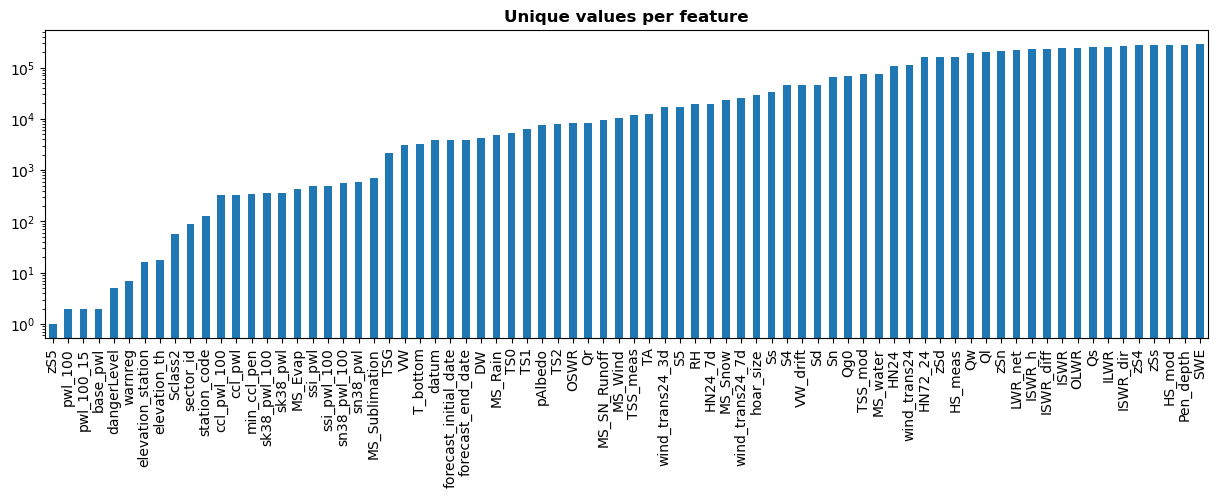

In [32]:
# Show the number of unique values in each feature
unique_values = data.nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15, 4))
plt.title("Unique values per feature", fontsize = 12, fontweight= "bold")
plt.show()

We see that `zs5` has only one value, that `pwl_100`, `pwl_100_15` and `base_pwl` contain 2 different values that we expect to be 0 and 1. 

In [33]:
data.zS5.unique()

array([0])

In [34]:
data.pwl_100.unique()

array([ 1.,  0., nan])

In [35]:
data.pwl_100_15.unique()

array([ 1.,  0., nan])

In [36]:
data.base_pwl.unique()

array([ 1.,  0., nan])

We delete `zS5`.

In [37]:
data.drop("zS5", axis=1, inplace=True)

Let's now check the granularity of our data according to dates. The SLF avalanche forecast as we said is published once at 8am and once at 5pm. Let's see what are the possible values of the hours in `forecast_initial_date` and `forecast_end_date`. 

In [38]:
data.forecast_initial_date.dt.hour.unique()

array([17])

In [39]:
data.forecast_end_date.dt.hour.unique()

array([17])

To make it simple and homogeneous, this dataset didn't record the danger level at 8 am as the bulletin forecast generally does (once at 8 am, once at 5pm).

The danger level, the meteorological and profile data were collected daily. Let's check if the time gap between `forecast_initial_date` and `forecast_end_date` is always a day.

In [40]:
nb_day_gaps = (data["forecast_end_date"] == data["forecast_initial_date"] + pd.Timedelta(days=1)).sum()
print("The gap between forecast_end_date and forecast_initial_date is a day:")
print("{} of time representing {}%".format(nb_day_gaps, nb_day_gaps/data.shape[0]*100))

The gap between forecast_end_date and forecast_initial_date is a day:
292837 of time representing 100.0%


We conclude that `forecast_end_date` is always the exact day after `forecast_initial_date`. 

Let's see now if the date of `forecast_initial_date` is always equals to `datum`. 

In [41]:
mask = (data.forecast_initial_date.dt.date == data.datum)
print("The dates in datum and forecast_initial_date match:")
print("{} of time of representing {}% of the time".format(mask.sum(), mask.sum()/data.shape[0]*100))

The dates in datum and forecast_initial_date match:
292837 of time of representing 100.0% of the time


Thanks to the two observations from above, we might delete `forecast_initial_date` and `forecast_end_date` later because they don't add any additional information than `datum`. But first let's check the missing values. 

#### A. 5. Quality of the data <a id="miss_val"></a>

Let's see if there are some duplicates.

In [42]:
data.duplicated().sum()

0

Let's explore the missing values.

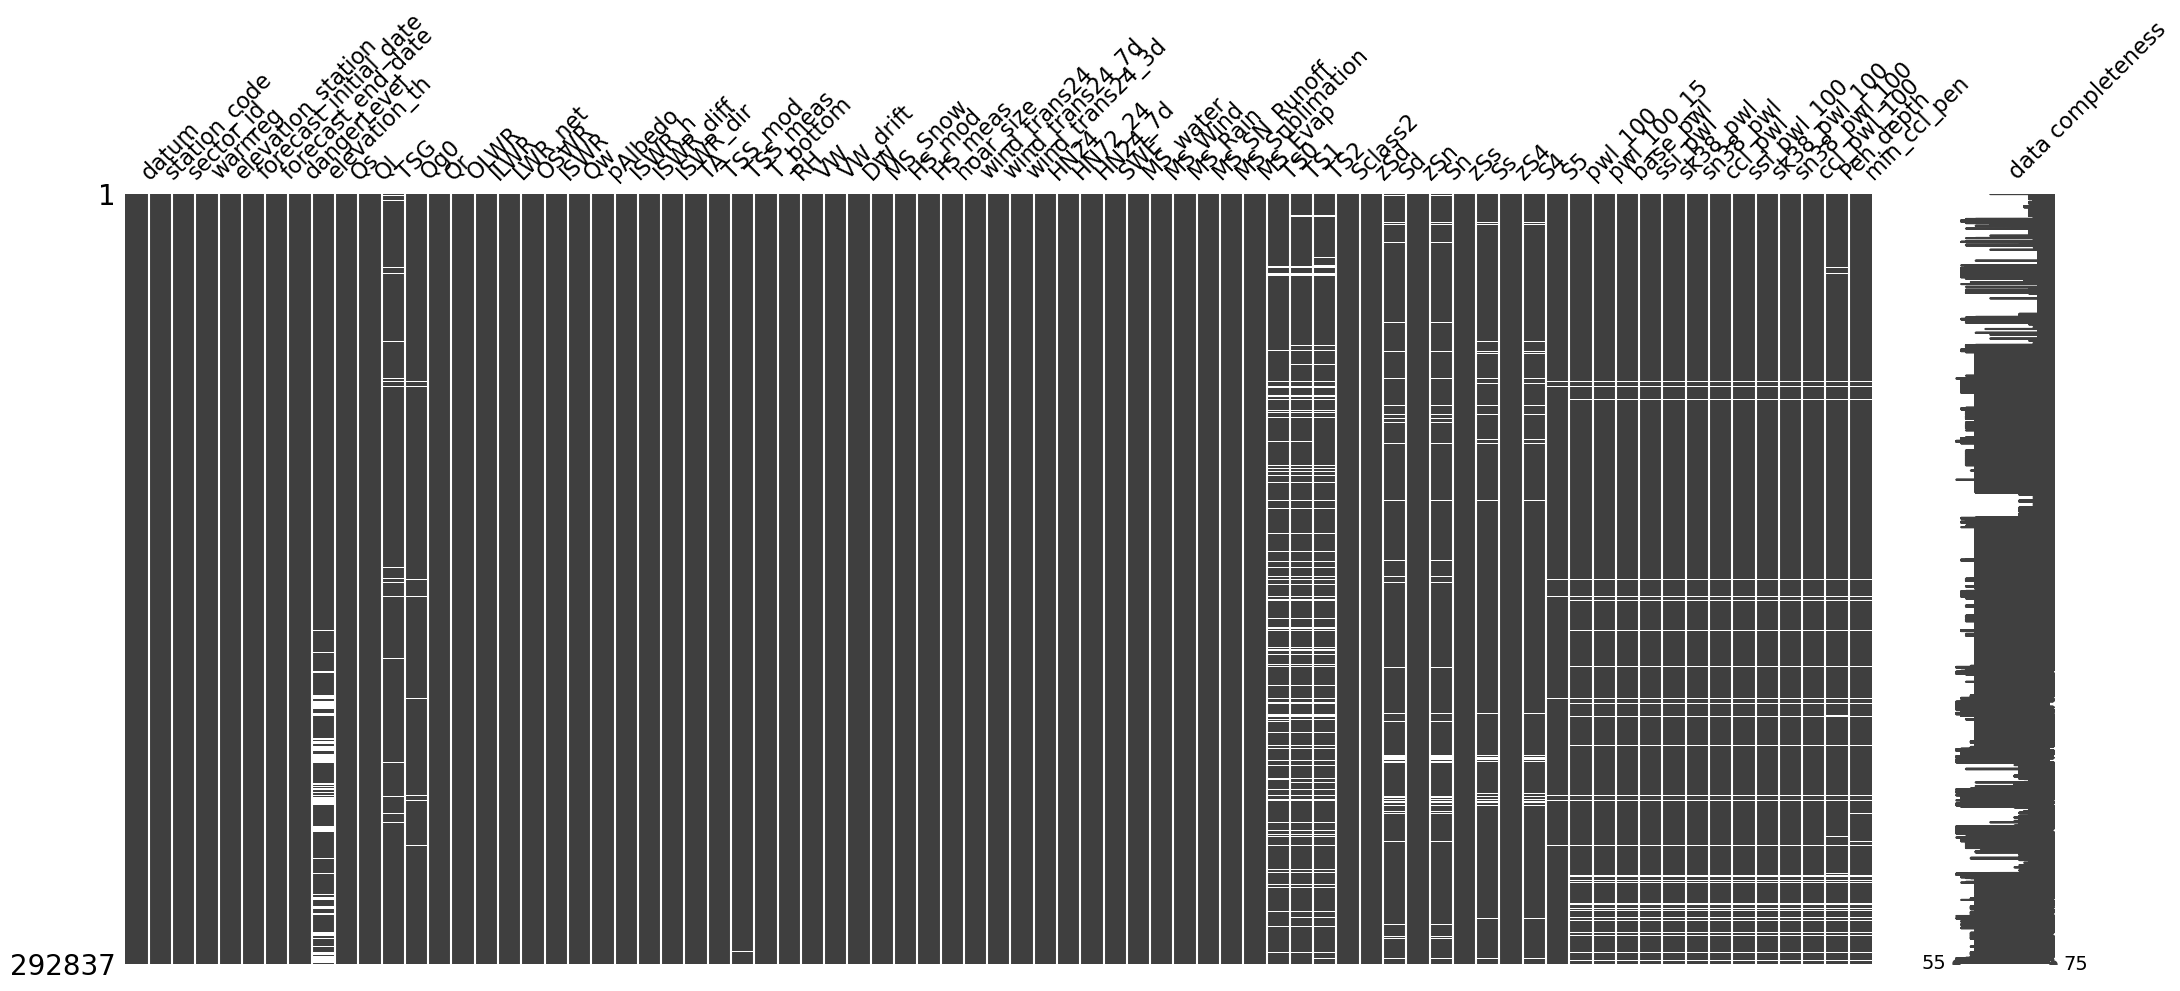

In [43]:
msno.matrix(data, labels = True);

We see that missing values are consistent throughout sets of features for some observations: 

On the right hand side of this matrix, we see that some observations have missing values in all of the last 15 features. In fact, these features are the ones collected from the snow profiles. We can make the same observation with the groups of features formed by  `TSO`, `TS1` and `TS2`, and `Sd`, `Sn`, `Ss` and `S4`.

Finally, we can already see that `elevation_th` has a significant amount of missing values. This can be inconvenient, because this variable has always to be put in perspective with `dangerLevel`.

Let's see the numbers and the percentages of missing values in the whole data set, in the target variable `dangerLevel` and in `elevation_th`.

In [44]:
nb_na = data.isna().sum().sum()
percentage = nb_na / data.size * 100

dangerlevel_na = data.dangerLevel.isna().sum()
elevation_th_na = data.elevation_th.isna().sum()

print("There are: \n")
print("{} missing values in the whole dataset, representing {:.2f}%".format(nb_na, percentage))
print("{} missing values in dangerLevel".format(dangerlevel_na))
print("{} missing values in the elevation_th, representing {:.2f}%".format(elevation_th_na, elevation_th_na / data.shape[0]*100))  

There are: 

324328 missing values in the whole dataset, representing 1.48%
0 missing values in dangerLevel
33692 missing values in the elevation_th, representing 11.51%


Overall, we have only a few missing values, no missing values in the target variable which is great, but 11% in `elevation_th` which is significant. 

We build a table below representing the features that have missing values, their description, their corresponding numbers of missing values and the corresponding percentages.

In [46]:
from codes.functions import percent_miss_values

percent_miss_values(data, meta_data)

Sum of missing values Percentage  \
elevation_th                 33692      11.51   
TS2                          30313      10.35   
TS1                          28884       9.86   
TS0                          25859       8.83   
Sd                           15449       5.28   
Sn                           15449       5.28   
Ss                           14185       4.84   
S4                           14185       4.84   
Pen_depth                    11315       3.86   
min_ccl_pen                  10986       3.75   
ccl_pwl_100                  10403       3.55   
ccl_pwl                      10403       3.55   
sn38_pwl                     10371       3.54   
ssi_pwl_100                  10371       3.54   
sk38_pwl_100                 10371       3.54   
sn38_pwl_100                 10371       3.54   
sk38_pwl                     10371       3.54   
pwl_100                      10371       3.54   
pwl_100_15                   10371       3.54   
base_pwl                     10371       3.54   
ssi_pwl                      10371       3.54   
TSG                           5862        2.0   
S5                            1782       0.61   
Qg0                           1781       0.61   
TSS_meas                       290        0.1   
T_bottom                       112       0.04   
HN72_24                         19       0.01   

                                                                         Description  
elevation_th                                                     Elevation threshold  
TS2                                                     Snow temperature at 1 m [∘C]  
TS1                                                   Snow temperature at 0.5 m [∘C]  
TS0                                                  Snow temperature at 0.25 m [∘C]  
Sd                                              Deformation rate stability index [–]  
Sn                                                       Natural stability index [–]  
Ss                                                    Sk38 skier stability index [–]  
S4                                                    Structural stability index [–]  
Pen_depth                                               Skier penetration depth [cm]  
min_ccl_pen   Min critical cut length at a deeper layer of the penetration depth [m]  
ccl_pwl_100                            Critical cut length at surface weak layer [m]  
ccl_pwl                                        Critical cut length at weak layer [m]  
sn38_pwl                                   Natural stability index at weak layer [–]  
ssi_pwl_100                     Structural stability index at surface weak layer [–]  
sk38_pwl_100                    Sk38 skier stability index at surface weak layer [–]  
sn38_pwl_100                       Natural stability index at surface weak layer [–]  
sk38_pwl                                Sk38 skier stability index at weak layer [–]  
pwl_100                  Persistent weak layer(s) in the 100 cm from the surface [–]  
pwl_100_15              Persistent weak layer(s) at depths between 15 and 100 cm [-]  
base_pwl                                         Persistent weak layer at bottom [–]  
ssi_pwl                                 Structural stability index at weak layer [–]  
TSG                                                          Ground temperature [∘C]  
S5                                                             Stability index 5 [–]  
Qg0                                            Ground heat at soil interface [W m−2]  
TSS_meas                                                    Surface temperature [∘C]  
T_bottom                                                     Bottom temperature [∘C]  
HN72_24                                     3 d sum of daily height of new snow [cm]

We can see that a lot of variables share the same amount of missing values, this can be due to some stations that couldn't measure some variables at some dates.

Let's see what is the maximum missing values a data point can hold.

In [47]:
max_na = data.isna().sum(axis=1).sort_values(ascending=False).max()
print("At most, rows have {} missing values over {}.".format(max_na, data.shape[1]))

At most, rows have 20 missing values over 75.


In [48]:
rows_w_na = (data.isna().sum(axis=1) > 0).sum()
percent_row_w_na = rows_w_na / data.shape[0] * 100

print("We have {} rows that have at least one missing value, representing {:.2f}%".format(rows_w_na,
                                                                                         percent_row_w_na))

We have 81065 rows that have at least one missing value, representing 27.68%


This is a bad new, because it means that removing every observation that has missing values would delete around 30% of the data. We need to be careful, and so decide to handle the missing values later on the project, after having a preliminary exploratory data analysis. 

## B. Exploratory data analysis (EDA)

### B. 1 Data Split

Before going into Exploratory Data Analysis, we need to split our data into training and test sets. Before doing so, let's remove `forecast_initial_date` and `forecast_end_date`.

In [49]:
data.drop(["forecast_initial_date", "forecast_end_date"], axis=1, inplace=True)

To decide from which date or year we'll split our data (we will build the test set with the most recent observations), let's check how many different stations appear in the data per year and what percentage of samples is covered by starting from a given year.

In [50]:
data["year"] = data.datum.dt.year
years = data.year.unique()
counts = []

for year in years:
    unique_stations = len(data[data["year"] == year].station_code.unique())
    counts.append(unique_stations)

data.drop("year", axis=1, inplace=True) # Remove the extra feature

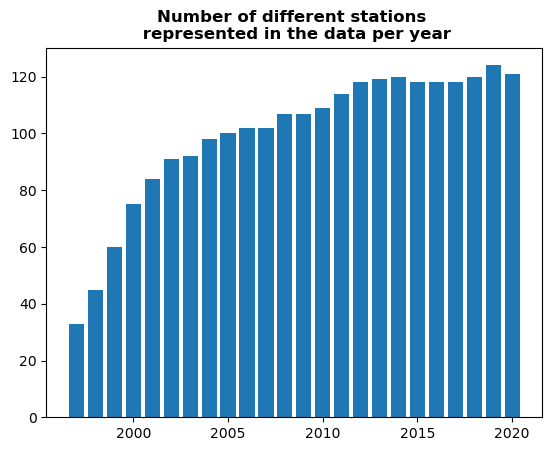

In [51]:
plt.bar(x = years, height = counts)

plt.title("Number of different stations \n represented in the data per year", fontsize=12, fontweight = "bold")
plt.show()

From 2005, the number of stations increase slowly compared to the period 1997-2005. From 2012, the number of different stations stays close to 120 until 2020. 

In [52]:
sample_percentage = []

for year in years: 
    percent = data[data.datum.dt.year >= year].shape[0]/data.shape[0]*100
    sample_percentage.append(percent)

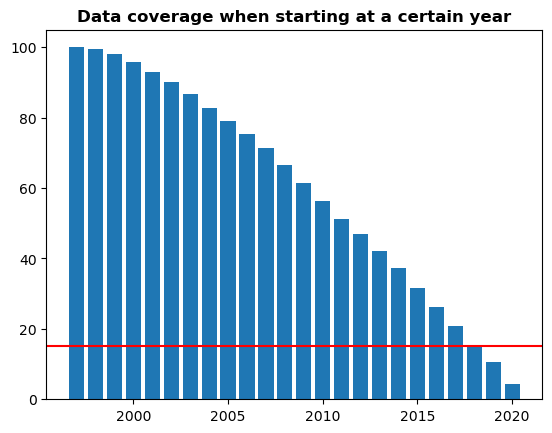

In [53]:
plt.bar(x = years, height= sample_percentage)

plt.title("Data coverage when starting at a certain year", fontsize = 12, fontweight = "bold")
plt.axhline(y=15, color="r", linestyle="-")
plt.show()

The red line has equation $y=15$. By making our test set with only data from the year 2018 (included), we will get around 15% of the data. 

With the two observations from above, we decide to split the data from the month of september of 2017. Our test set will have start at the beginning of the season 2017/2018.

In [54]:
date_limit = pd.to_datetime("2017-31-08", format = "%Y-%d-%m")
mask = (data["datum"] <= date_limit)

data_tr  = data.loc[mask].copy()
data_tr.reset_index(drop=True, inplace=True)

data_te = data.loc[~mask].copy()
data_te.reset_index(drop=True, inplace=True)

data = data_tr.copy() # To make it just more convenient to call

In [55]:
print("The train set has :")
print("{} samples, or {:.2f}% of the whole dataset\n".format(data.shape[0],
                                                      data.shape[0]/(data.shape[0]+data_te.shape[0])*100))
print("The test set has:")
print("{} samples, or {:.2f}% of the whole dataset".format(data_te.shape[0],
                                                      data_te.shape[0]/(data.shape[0]+data_te.shape[0])*100))


The train set has :
244327 samples, or 83.43% of the whole dataset

The test set has:
48510 samples, or 16.57% of the whole dataset


We define functions to pursue the evolution of the training dataset.

In [56]:
col_beginning = data.columns.tolist()
rows_beginning = data.shape[0]
nan_beginning = data.isna().sum().sum()
size_beginning = data.size


def diff_col():
    col_begin = set(col_beginning)
    col_present = set(data.columns.tolist())
    col_deleted = list(col_begin.difference(col_present))
    col_added = list(col_present.difference(col_begin))
    print("Since the beginning:\n")
    print("Columns deleted: {}\nNumber of columns deleted: {}\n".format(str(col_deleted), len(col_deleted)))
    print("Columns added: {}\nNumber of columns added: {}".format(str(col_added), len(col_added)))

# Function to be called to see how many missing variables are remaining throughout the project
def missing_values():
    nb_na = data.isna().sum().sum()
    percent = (nb_na/data.size)*100
    print("Number of missing values beginning: {}".format(nan_beginning))
    print("Percentage missing values beginning: {:.3f}%\n".format(nan_beginning/size_beginning*100))
    print("Number of missing values now: {}".format(nb_na))
    print("Percentage of missing values now: {:.3f}%".format(percent))
          
def rows_deleted():
    print("Number of rows beginning: {}\n".format(rows_beginning))
    print("Number of rows now: {}\n".format(data.shape[0]))
    print("Since the beginning we have deleted: {} rows representing {:.3f}%".format(rows_beginning - data.shape[0],
                                                                           (rows_beginning - data.shape[0])/rows_beginning * 100))


In [57]:
diff_col()

Since the beginning:

Columns deleted: []
Number of columns deleted: 0

Columns added: []
Number of columns added: 0


In [58]:
missing_values()

Number of missing values beginning: 198494
Percentage missing values beginning: 1.113%

Number of missing values now: 198494
Percentage of missing values now: 1.113%


In [59]:
rows_deleted()

Number of rows beginning: 244327

Number of rows now: 244327

Since the beginning we have deleted: 0 rows representing 0.000%


### B. 2.  Preliminary EDA

#### B. 2. 1. Danger Level and Elevation Threshold  <a id="frequenty"></a>

The avalanche danger level takes most of the time the values 2 and 3 while the danger 5 is extremely rare.

In [60]:
# Function to add values on top of the bars given positions x, y
def add_labels(x, y, h_ratio):
    for i in range(len(x)):
        plt.text(x=i+1, 
                 y=y[i] + y[i]*h_ratio,
                 s=y[i],
                 ha='center')

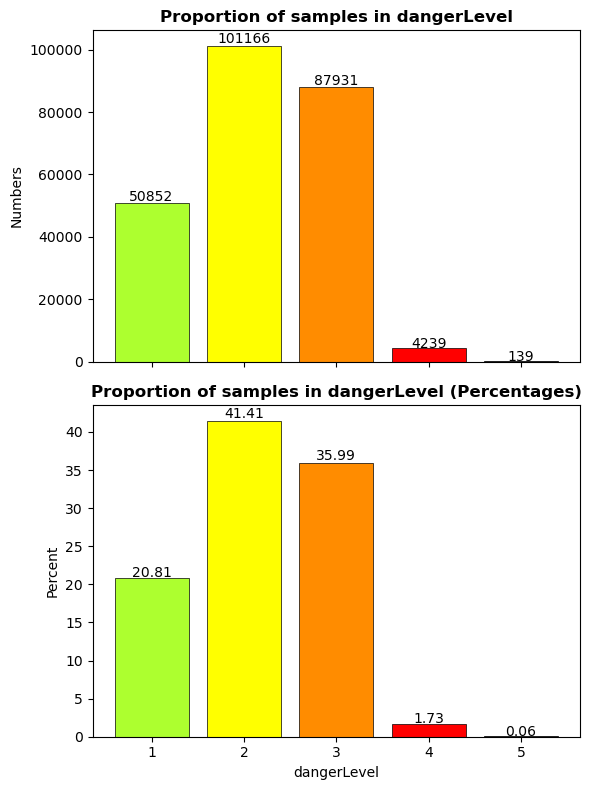

In [61]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6, 8))

# Take the dangers ranging from 1 to 5 
x = data.dangerLevel.value_counts(sort=False).index

# Take the occurency of each danger level
y_count = data.dangerLevel.value_counts(sort=False).values

# Take the percentages of each danger level
y_per = round(data.dangerLevel.value_counts(sort=False) / data.shape[0] * 100, 2).values

# Setting the colors similar than in the avalanche forecast
colors = ["greenyellow", "yellow", "darkorange", "red", "black"]

axes[0].bar(x=x, height=y_count, color=colors, edgecolor="black", linewidth=0.5)
plt.sca(axes[0]) # To write on the right subplot
add_labels(x, y_count, h_ratio=0.01)
axes[0].set_ylabel("Numbers")
axes[0].set_title("Proportion of samples in dangerLevel", fontsize=12, fontweight="bold")

axes[1].bar(x=x, height=y_per, color=colors, edgecolor="black", linewidth=0.5)
plt.sca(axes[1]) 
add_labels(x, y_per, h_ratio=0.01)
axes[1].set_ylabel("Percent")
axes[1].set_title("Proportion of samples in dangerLevel (Percentages)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("dangerLevel")

plt.tight_layout()
plt.show()


Our dataset is extremely imbalanced. 139 observations with danger 5 is extremely low knowing that our train set stores data from 1997 to 2017. And the number 139 doesn't even represent the number of days because there were probably few stations that recorded this danger level at the same time.

We check when were recorded these observations. 

In [62]:
data[data.dangerLevel ==5].datum.unique()

array(['1999-02-08T00:00:00.000000000', '1999-02-21T00:00:00.000000000',
       '1999-02-22T00:00:00.000000000', '1999-02-23T00:00:00.000000000',
       '1999-02-24T00:00:00.000000000', '2000-05-02T00:00:00.000000000',
       '2004-01-13T00:00:00.000000000', '2006-03-04T00:00:00.000000000'],
      dtype='datetime64[ns]')

There are only 8 days between 1997 and 2017 when the danger level 5 was given. Between those 8 days, 5 of them were recorded within 2 weeks. This is likely suspicious. This can be potentially explained if the stations are mainly situated in low or medium altitude because such a high level of danger is the result of a combination of several factors, often due to large quantities of snow falling with very, very strong gusts of wind. Conditions that occur more often at high altitude. We will investigate the altitude of the stations in the next part. 

As the danger level 5 occurs only in extreme cases, we decide to merge the class of danger level 5 into the class of danger level 4. Our classification task becomes one to classify 4 categories.

In [63]:
class MergeClasses:
    
    def transform(self, dataset):
        dataset.dangerLevel.replace(to_replace = {5:4},
                                    inplace = True) 

In [64]:
merge_classes = MergeClasses()

merge_classes.transform(data)

Let's see now the distribution of `elevation_th`. Recall: `elevation_th` is always expressed in hundreds. 


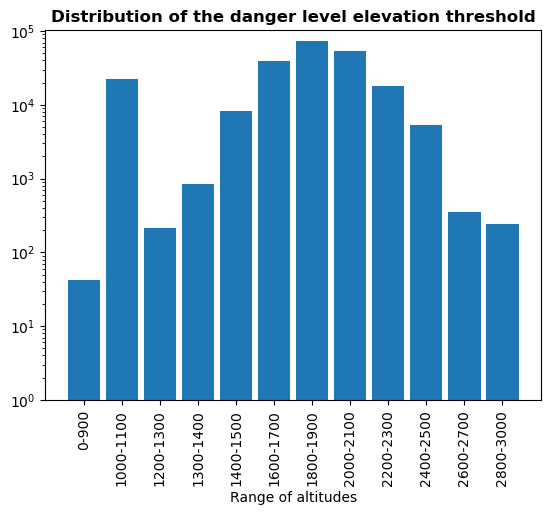

In [65]:
values = [data[data.elevation_th < 1000].shape[0],
          data[(data.elevation_th >= 1000) & (data.elevation_th <= 1100)].shape[0],
          data[(data.elevation_th >= 1200) & (data.elevation_th <= 1300)].shape[0],
          data[(data.elevation_th >= 1300) & (data.elevation_th <= 1400)].shape[0],
          data[(data.elevation_th >= 1500) & (data.elevation_th <= 1600)].shape[0],
          data[(data.elevation_th >= 1700) & (data.elevation_th <= 1800)].shape[0],
          data[(data.elevation_th >= 1900) & (data.elevation_th <= 2000)].shape[0],
          data[(data.elevation_th >= 2100) & (data.elevation_th <= 2200)].shape[0],
          data[(data.elevation_th >= 2300) & (data.elevation_th <= 2400)].shape[0],
          data[(data.elevation_th >= 2500) & (data.elevation_th <= 2600)].shape[0],
          data[(data.elevation_th >= 2700) & (data.elevation_th <= 2800)].shape[0],
          data[(data.elevation_th >= 2800)].shape[0]]

x = np.arange(0,2*len(values),2)

labels  = ["0-900", "1000-1100", "1200-1300", "1300-1400","1400-1500", "1600-1700",
         "1800-1900", "2000-2100", "2200-2300", "2400-2500", "2600-2700", "2800-3000"]

plt.bar(height = values, x=x, log=True, width = 1.7)

plt.xlabel("Range of altitudes")
plt.title("Distribution of the danger level elevation threshold", fontsize=12, fontweight="bold")
plt.xticks(ticks = x, labels = labels, rotation=90)
plt.ylim(1, max(values)*1.4)
plt.show()


We see that mainly `elevation_th` lies between 1400 and 2500 meters. There are also a significant number of observations for which `elevation_th` is between 1000 and 1100 meters. 

The other altitudes for `elevation_th` are quite rare. We can see there are a few observations for which `elevation_th` is below 1000m. Let's have a look.

In [66]:
data.loc[data["elevation_th"]<1000, "elevation_th"].value_counts()

0.0    42
Name: elevation_th, dtype: int64

In fact, for those observations the value in `elevation_th` is always equal to 0. This is not impossible. Indeed, we can interpret it as the danger level can be homogeneous throughout all altitudes, so that `elevation_th` is defined as 0. 

But let's have a closer look at which dates and at which stations these observations were made. 

In [67]:
data.loc[data["elevation_th"]==0, "datum"].unique()

array(['1999-05-13T00:00:00.000000000'], dtype='datetime64[ns]')

In [68]:
data.loc[data["elevation_th"]==0, "station_code"].unique()

array(['TUJ3', 'ARO2', 'LUM2', 'DAV2', 'ZER2', 'PUZ2', 'NAR2', 'TUJ2',
       'SIM2', 'ARO3', 'ROA2', 'PAR2', 'DTR2', 'MEI2', 'LAG3', 'ELS2',
       'ANV2', 'LAG2', 'ANV3', 'GAN2', 'TRU2', 'SAA3', 'JUL2', 'BEV2',
       'GAD2', 'CHA2', 'URS2', 'VIN2', 'SCH2', 'KES2', 'VAL2', 'BED3',
       'KLO3', 'SAA2', 'SLF2', 'FIS2', 'OTT2', 'VDS2', 'BED2', 'FIR2',
       'FAE2', 'KLO2'], dtype=object)

Now this becomes suspicious. If it is possible for `elevation_th` to be 0 for the reasons we explained, it is highly unlikely that this can happen in May. If the elevation threshold is 0, it means there were great snowfall at every altitude and it is rare in May. Our guess is that the bulletin stored 0 instead of the precise altitude because in May, the avalanches conditions take place only where there is snow left. 

Let's see if we have also a pattern between `dangerLevel` and `elevation_th` when `elevation_th` is missing.

In [69]:
# Counts of the values in danger level when elevation_th is missing
data[data.elevation_th.isna()].dangerLevel.value_counts()

1    21668
3      406
2      335
4      116
Name: dangerLevel, dtype: int64

In [70]:
# Group the missing values in elevation_th by the month
data[data.elevation_th.isna()].datum.dt.month.value_counts().sort_index()

1      962
2      416
3     4441
4     7353
5      580
11    1296
12    7477
Name: datum, dtype: int64

In [71]:
# Group the values when elevation is zero and count by month
data[data.elevation_th == 0].datum.dt.month.value_counts().sort_index()

5    42
Name: datum, dtype: int64

Generally, when `elevation_th` is missing, then `dangerLevel` is equal to 1. This can be explained by: because the conditions are stable or favorable, then the danger is the same everywhere regardless of the altitude or orientation. 

Thus, we decide to assign the following values to the missing values and values under 1000 in `elevation_th`:

- assign 1500 when it is winter (so december, january, february, march). 
- assign 2000 when it is in autumn or in spring (october, november, april, may)

In [72]:
# When elevation_th is missing or when elevation_th = 0, put the value 1500 if it is in winter (

class Elevation: 
    
    def transform(self, dataset):
        
        mask_1 = (dataset.datum.dt.month.isin([12,1,2,3]))
        mask_2 = (dataset.datum.dt.month.isin([10,11,4,5]))
        
        dataset.loc[mask_1 & (dataset.elevation_th.isna()), "elevation_th"] = 1500
        dataset.loc[mask_1 & (dataset.elevation_th ==0), "elevation_th"] = 1500
        
        dataset.loc[mask_2 & (dataset.elevation_th.isna()), "elevation_th"] = 2000
        dataset.loc[mask_2& (dataset.elevation_th ==0), "elevation_th"] = 2000

In [73]:
elevation = Elevation()

elevation.transform(data)

In [74]:
missing_values()

Number of missing values beginning: 198494
Percentage missing values beginning: 1.113%

Number of missing values now: 175969
Percentage of missing values now: 0.987%


#### B. 2. 2. Elevation and location of stations

Let's check the elevation of the stations. We saw that `elevation_station` in `data` is the elevation of the station rounded to the nearest hundred. So we can check the distribution of the rounded `elevation` in the station list.

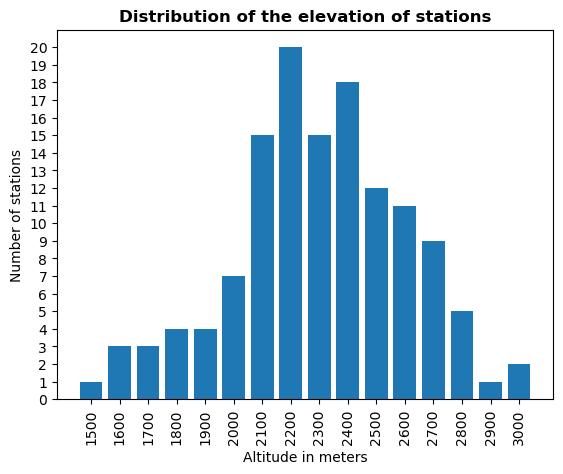

In [75]:
elevation = stations.elevation.copy()
elevation = round(elevation,-2)

plt.bar(height = elevation.value_counts().values,
        x = elevation.value_counts().index,
        width=80)

plt.ylabel("Number of stations")
plt.xlabel("Altitude in meters")
plt.title("Distribution of the elevation of stations", 
         fontsize=12, 
         fontweight="bold")

plt.yticks(np.arange(0,21,1))
plt.xticks(np.arange(1500,3100,100), rotation=90)
plt.show()

We can see that most of the stations are situated between 2000 and 2600m of altitude but their elevation can go up to 3000. 

Let's have an overview on where the stations are situated in Switzerland.

<img src="../pictures_maps/elevation_stations.png" width="600" height="350">

We can also see their locations against the most recent warning region 21 which is effective since October 2019, as proved by the code below (the valid date of the table below is in 2071).

In [76]:
warnreg_def.iloc[[-1]]

changes  \
10  Neue generalisierte Warnregionen in Zusammenhang mit der Integration der Waldbrandgebiete in die...   

    id           valid_from_date             valid_to_date  
10  21  2019-10-01T00:00:00.000Z  2071-10-01T00:00:00.000Z

<img src="../pictures_maps/warnreg_21_stations.png" width="600" height="350">

We see that those stations are situated mainly in the alpine arc or at least in mountain regions. 

If you look closer (apologies for make you zoom in), we see that there can be multiple stations within the same sector (take the example of sector 4113 in the south-west part of Valais). 

Note: the stations represented by a yellow diamonds are only the ones present in our dataset. There are other IMIS stations that are not represented in the data so in the image above. 

#### B. 2. 3. Features statistics

For convenience reasons, we show first the statistics of the features related to the danger level and the stations, and in a second time those of the meteorological and profile features.

In [77]:
# Statistics of the stations and dangerLevel related features
# Drop the column count 
data.iloc[:,:7].describe().T.drop("count", axis=1)

mean         std     min     25%     50%     75%  \
elevation_station  2360.675243  261.470356  1600.0  2200.0  2400.0  2600.0   
dangerLevel           2.187597    0.777500     1.0     2.0     2.0     3.0   
elevation_th       1917.708645  375.038451  1000.0  1800.0  2000.0  2200.0   

                      max  
elevation_station  3000.0  
dangerLevel           4.0  
elevation_th       3000.0

Now the meteorological and profile variables.

In [78]:
# Meteorological and profile statistics
stats = data.iloc[:,7:].describe().T.drop(["count", "25%", "50%", "75%"], axis=1).copy()

# Add the feature descriptions
descriptions = []

for var in stats.index:
    description = meta_data.loc[meta_data["Feature name"]==var, "Feature description"].values[0]
    descriptions.append(description)
    
stats["Description"] = descriptions 

# Reorder the columns
stats= stats.iloc[:,[4,0,1,2,3]]
stats

Description  \
Qs                                                                Sensible heat [W m−2]   
Ql                                                                  Latent heat [W m−2]   
TSG                                                             Ground temperature [∘C]   
Qg0                                               Ground heat at soil interface [W m−2]   
Qr                                                                   Rain energy [W m2]   
OLWR                                               Outgoing long-wave radiation [W m−2]   
ILWR                                               Incoming long-wave radiation [W m−2]   
LWR_net                                                 Net long-wave radiation [W m−2]   
OSWR                                             Reflected short-wave radiation [W m−2]   
ISWR                                              Incoming short-wave radiation [W m−2]   
Qw                                                     Net short-wave radiation [W m−2]   
pAlbedo                                                         Parametrized albedo [–]   
ISWR_h                                    Incoming short wave on the horizontal [W m−2]   
ISWR_diff                                           Diffuse incoming short wave [W m−2]   
ISWR_dir                                             Direct incoming short wave [W m−2]   
TA                                                                 Air temperature [∘C]   
TSS_mod                                                        Surface temperature [∘C]   
TSS_meas                                                       Surface temperature [∘C]   
T_bottom                                                        Bottom temperature [∘C]   
RH                                                                Relative humidity [–]   
VW                                                                Wind velocity [m s−1]   
VW_drift                                                    Wind velocity drift [m s−1]   
DW                                                                   Wind direction [∘]   
MS_Snow                                           Solid precipitation rate [kg s−2 h−1]   
HS_mod                                                                 Snow height [cm]   
HS_meas                                                                Snow height [cm]   
hoar_size                                                                Hoar size [cm]   
wind_trans24                                                       24 h wind drift [cm]   
wind_trans24_7d                                                     7 d wind drift [cm]   
wind_trans24_3d                                                     3 d wind drift [cm]   
HN24                                                       24 h height of new snow [cm]   
HN72_24                                        3 d sum of daily height of new snow [cm]   
HN24_7d                                        7 d sum of daily height of new snow [cm]   
SWE                                                      Snow water equivalent [kg m−2]   
MS_water                                                 Total amount of water [kg m−2]   
MS_Wind                                                      Erosion mass loss [kg m−2]   
MS_Rain                                                          Rain rate [kg s−2 h−1]   
MS_SN_Runoff                                             Virtual lysimeter [kg s−2 h−1]   
MS_Sublimation                                                Sublimation mass [kg m−2]   
MS_Evap                                                        Evaporated mass [kg m−2]   
TS0                                                     Snow temperature at 0.25 m [∘C]   
TS1                                                      Snow temperature at 0.5 m [∘C]   
TS2                                                        Snow temperature at 1 m [∘C]   
Sclass2                                                             Stab

Let's check their distributions.

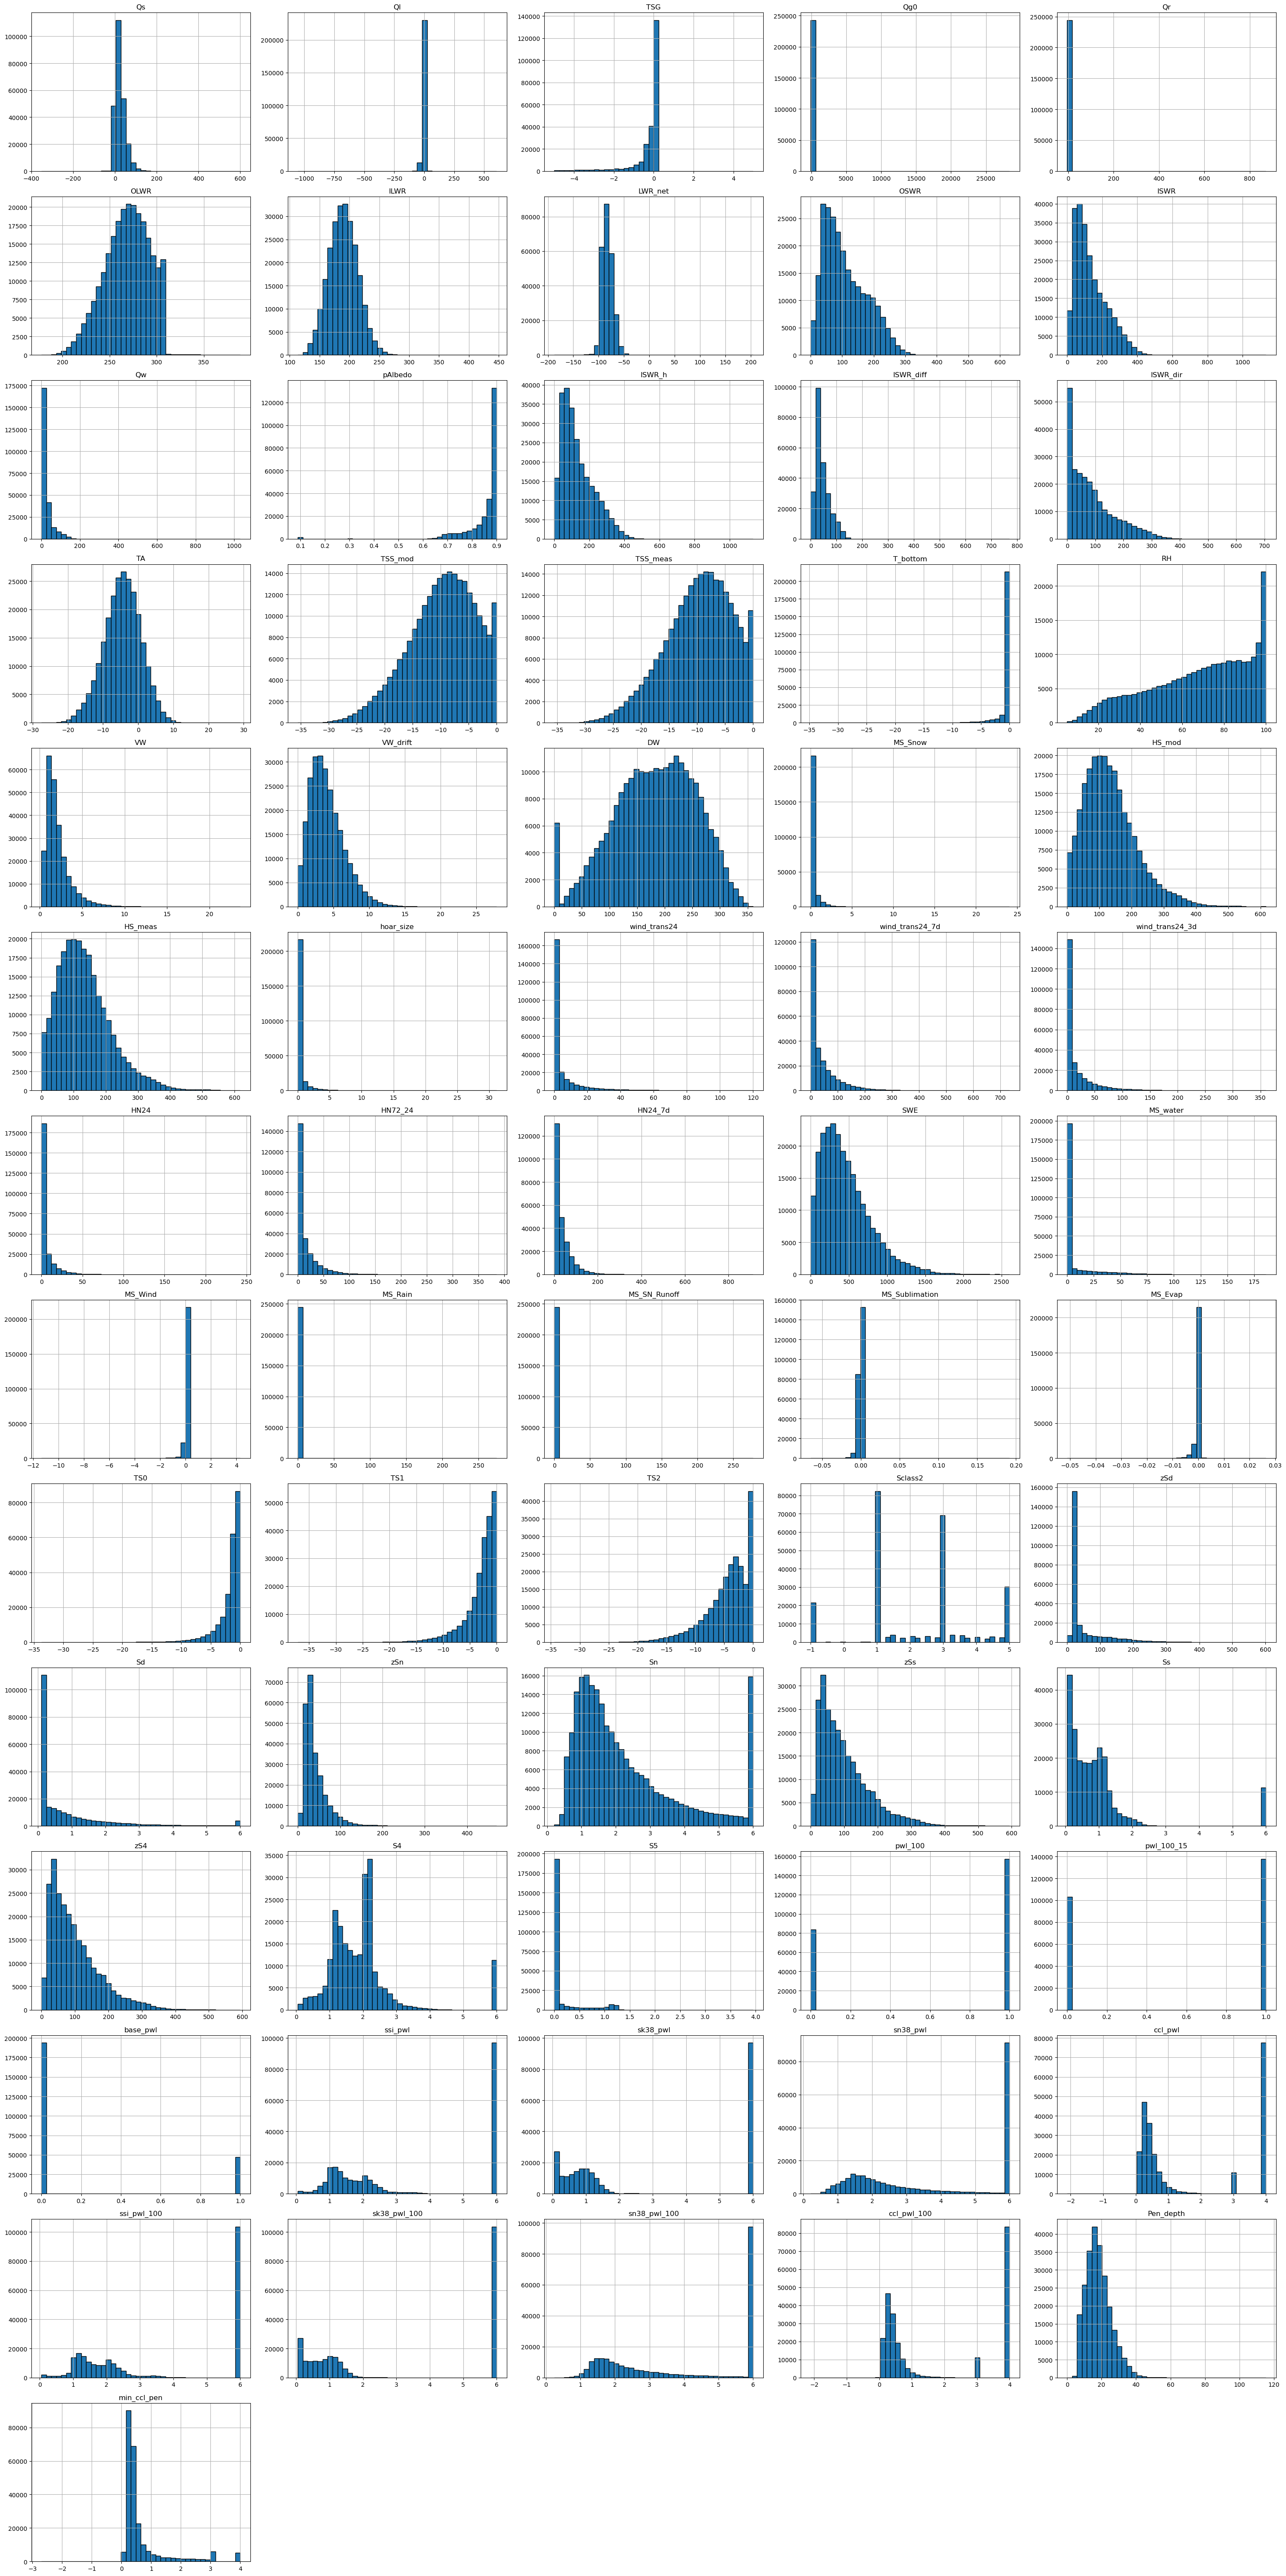

In [79]:
data.iloc[:,7:].hist(layout = (-1,5),
          figsize=(30,60),
          bins=40, 
          edgecolor="black")

plt.tight_layout()
plt.show()

We have various distribution types: really nice bell-shaped distributions (take `TA`), truncated bell-shaped distributions (take `TSS_mod`), right or left skewed (take `pAlbedo` and `Pen_depth`) or they look like only bars around one value.

#### B. 2. 4. Dates

Now let's come to dates. Let's see if the time period during which each stations stored data and if these periods are homogeneous.

In [80]:
time_min = data.groupby("station_code")["datum"].min().dt.date
time_max = data.groupby("station_code")["datum"].max().dt.date

time_range = pd.concat([time_min, time_max], axis=1)

time_range.columns = ["first date", "last date"]
time_range["period of measurement"] = time_range["last date"] - time_range["first date"]

time_range.head(10)

first date   last date period of measurement
station_code                                              
ALI2          2004-11-29  2017-04-24             4529 days
AMD2          1998-01-19  2017-04-14             7025 days
ANV2          1997-11-11  2017-05-08             7118 days
ANV3          1997-11-11  2017-05-08             7118 days
ARO2          1998-11-19  2017-05-08             6745 days
ARO3          1998-11-19  2017-05-08             6745 days
ATT2          2011-12-07  2017-05-08             1979 days
BED2          1997-11-11  2017-03-09             7058 days
BED3          1997-11-11  2017-04-22             7102 days
BEL2          2008-11-20  2017-05-08             3091 days

The periods of measurement are not consistent accross all stations. Some stations are quite new, as `ALB2`, while others started taking measurements way before, as `ANV2`. 

We have previously seen that there are only and stricly 24 hours between `forecast_initial_date` and `forecast_end_date`. The question now is "how much time separates the observations ?".

To answer that question, we make a copy of our data, select only the dates variable and `station_code` and reorganize it by sorting the values by `station_code` and then by dates `datum`. So that each pair of adjacent observations should be separated in time by a day (at least it is what we expect).

In [81]:
# Order by station and then by dates
# Take only the dates variables
dates = data.sort_values(by =  ["station_code","datum"],
                         ascending = [True, True])[["datum",
                                                    "station_code"]].copy() 

dates.reset_index(drop=True, inplace=True)
dates

datum station_code
0      2004-11-29         ALI2
1      2004-12-09         ALI2
2      2004-12-16         ALI2
3      2004-12-28         ALI2
4      2004-12-29         ALI2
...           ...          ...
244322 2017-05-04         ZNZ2
244323 2017-05-05         ZNZ2
244324 2017-05-06         ZNZ2
244325 2017-05-07         ZNZ2
244326 2017-05-08         ZNZ2

[244327 rows x 2 columns]

We shift by one row `datum` and we take the difference in days from its original state, we store the result in a column `time gap with previous observation` that tells us how far apart in time the current observation is separated with the previous one in days. We make sure that if the value in `station_code` in the previous observation is different from the one in the current observation, then the time gap is 0. So, normally, every row should have 0 or 1 day in `time gap with previous observation`. 

In [82]:
# Shift the columns by 1 line to compare with the previous values
dates["prev_end_date"] = dates["datum"].shift(+1)
dates["prev_station"] = dates["station_code"].shift(+1)

# Compute the time gap only if the station is the same, otherwise fill with 0
same_station = dates["station_code"] == dates["prev_station"]
dates["time gap with previous observation"] =  dates["datum"]- dates["prev_end_date"]
dates.loc[~same_station, "time gap with previous observation"] = pd.Timedelta(days=0)

# Replace the NaN value in the first row by 0
dates["time gap with previous observation"].fillna(pd.Timedelta(days=0), inplace=True)

# Dropping the added columns
dates.drop(columns=["prev_end_date", "prev_station"], inplace=True)

dates.head()

datum station_code time gap with previous observation
0 2004-11-29         ALI2                             0 days
1 2004-12-09         ALI2                            10 days
2 2004-12-16         ALI2                             7 days
3 2004-12-28         ALI2                            12 days
4 2004-12-29         ALI2                             1 days

Let's see if this new column has values greater than 1 day. 

In [83]:
# Select rows that present a time hole
time_holes = dates[dates["time gap with previous observation"].dt.days > 1]
time_holes

datum station_code time gap with previous observation
1      2004-12-09         ALI2                            10 days
2      2004-12-16         ALI2                             7 days
3      2004-12-28         ALI2                            12 days
5      2005-01-08         ALI2                            10 days
6      2005-01-10         ALI2                             2 days
...           ...          ...                                ...
244130 2016-04-18         ZNZ2                             2 days
244131 2016-04-20         ZNZ2                             2 days
244145 2016-05-06         ZNZ2                             3 days
244148 2016-11-10         ZNZ2                           186 days
244163 2016-11-26         ZNZ2                             2 days

[17265 rows x 3 columns]

We have around 17'000 time "holes" in our data. We can see the pairs of dates that are adjacent in our table but not in time. Let see the these observations with their preceding observations in the dataset. 

In [84]:
index = time_holes.index

 # Take the indices of the previous observation
index = np.concatenate([index, index-1]) # Drop the index 0 to avoid error message
index = np.sort(index) # Sort the index
index = np.unique(index) # Take the unique values

dates.loc[index,:]

datum station_code time gap with previous observation
0      2004-11-29         ALI2                             0 days
1      2004-12-09         ALI2                            10 days
2      2004-12-16         ALI2                             7 days
3      2004-12-28         ALI2                            12 days
4      2004-12-29         ALI2                             1 days
...           ...          ...                                ...
244145 2016-05-06         ZNZ2                             3 days
244147 2016-05-08         ZNZ2                             1 days
244148 2016-11-10         ZNZ2                           186 days
244162 2016-11-24         ZNZ2                             1 days
244163 2016-11-26         ZNZ2                             2 days

[30827 rows x 3 columns]

These time holes are not necessarily a problem but we have to investigate more. As the dataset is about the avalanche danger, it seems logical that the SLF stations didn't measure any sort of data related to it during summer. If these time holes are only the time gaps between the last days of measurement of the winter season and the first day of the next winter season, then there will be no problem. 

To begin our investigation, let's see during which months the stations collected the data and the danger level. We provide here a bar plot that shows the number of observation for each month in a log scale (so we can clearly see if some months have no data). 

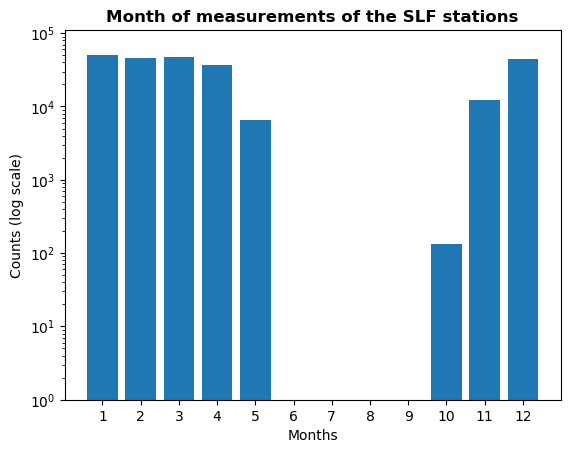

In [85]:
month = np.arange(1,13)

x = data.datum.dt.month.value_counts().sort_index().index
y = data.datum.dt.month.value_counts().sort_index().values

plt.bar(x = x, 
        height = y, 
       log = True)

plt.xticks(month)
plt.title("Month of measurements of the SLF stations", fontsize = 12, fontweight = "bold")
plt.xlabel("Months", fontsize=10)
plt.ylabel("Counts (log scale)", fontsize = 10)
plt.ylim(1, max(values)*1.5)
plt.show()

There isn't any data available during the period between June and September included, as we expected. Let's see now if the time holes we found previously match roughly the time gap between the 1st of June and the 30th of September, which is 122 days. We are looking at the sample for where the value in `time gap with previous observation` is at least 124 days which corresponds approximately to 4 months.

In [86]:
mask = (time_holes["time gap with previous observation"].dt.days >= 124) 

time_holes[mask].shape[0]

1777

This roughly explains around 10% of all the time holes we found previously. Again, the time holes are not necessarily a problem, since our goal is to predict day by day the dangerlevel according to the daily variables recorded by the SLF. 

### B. 3. Relations between the features 

#### B. 3. 1. Among themselves

Let's check the clustermap from Seaborn to see if there are clusters of highly correlated features. 

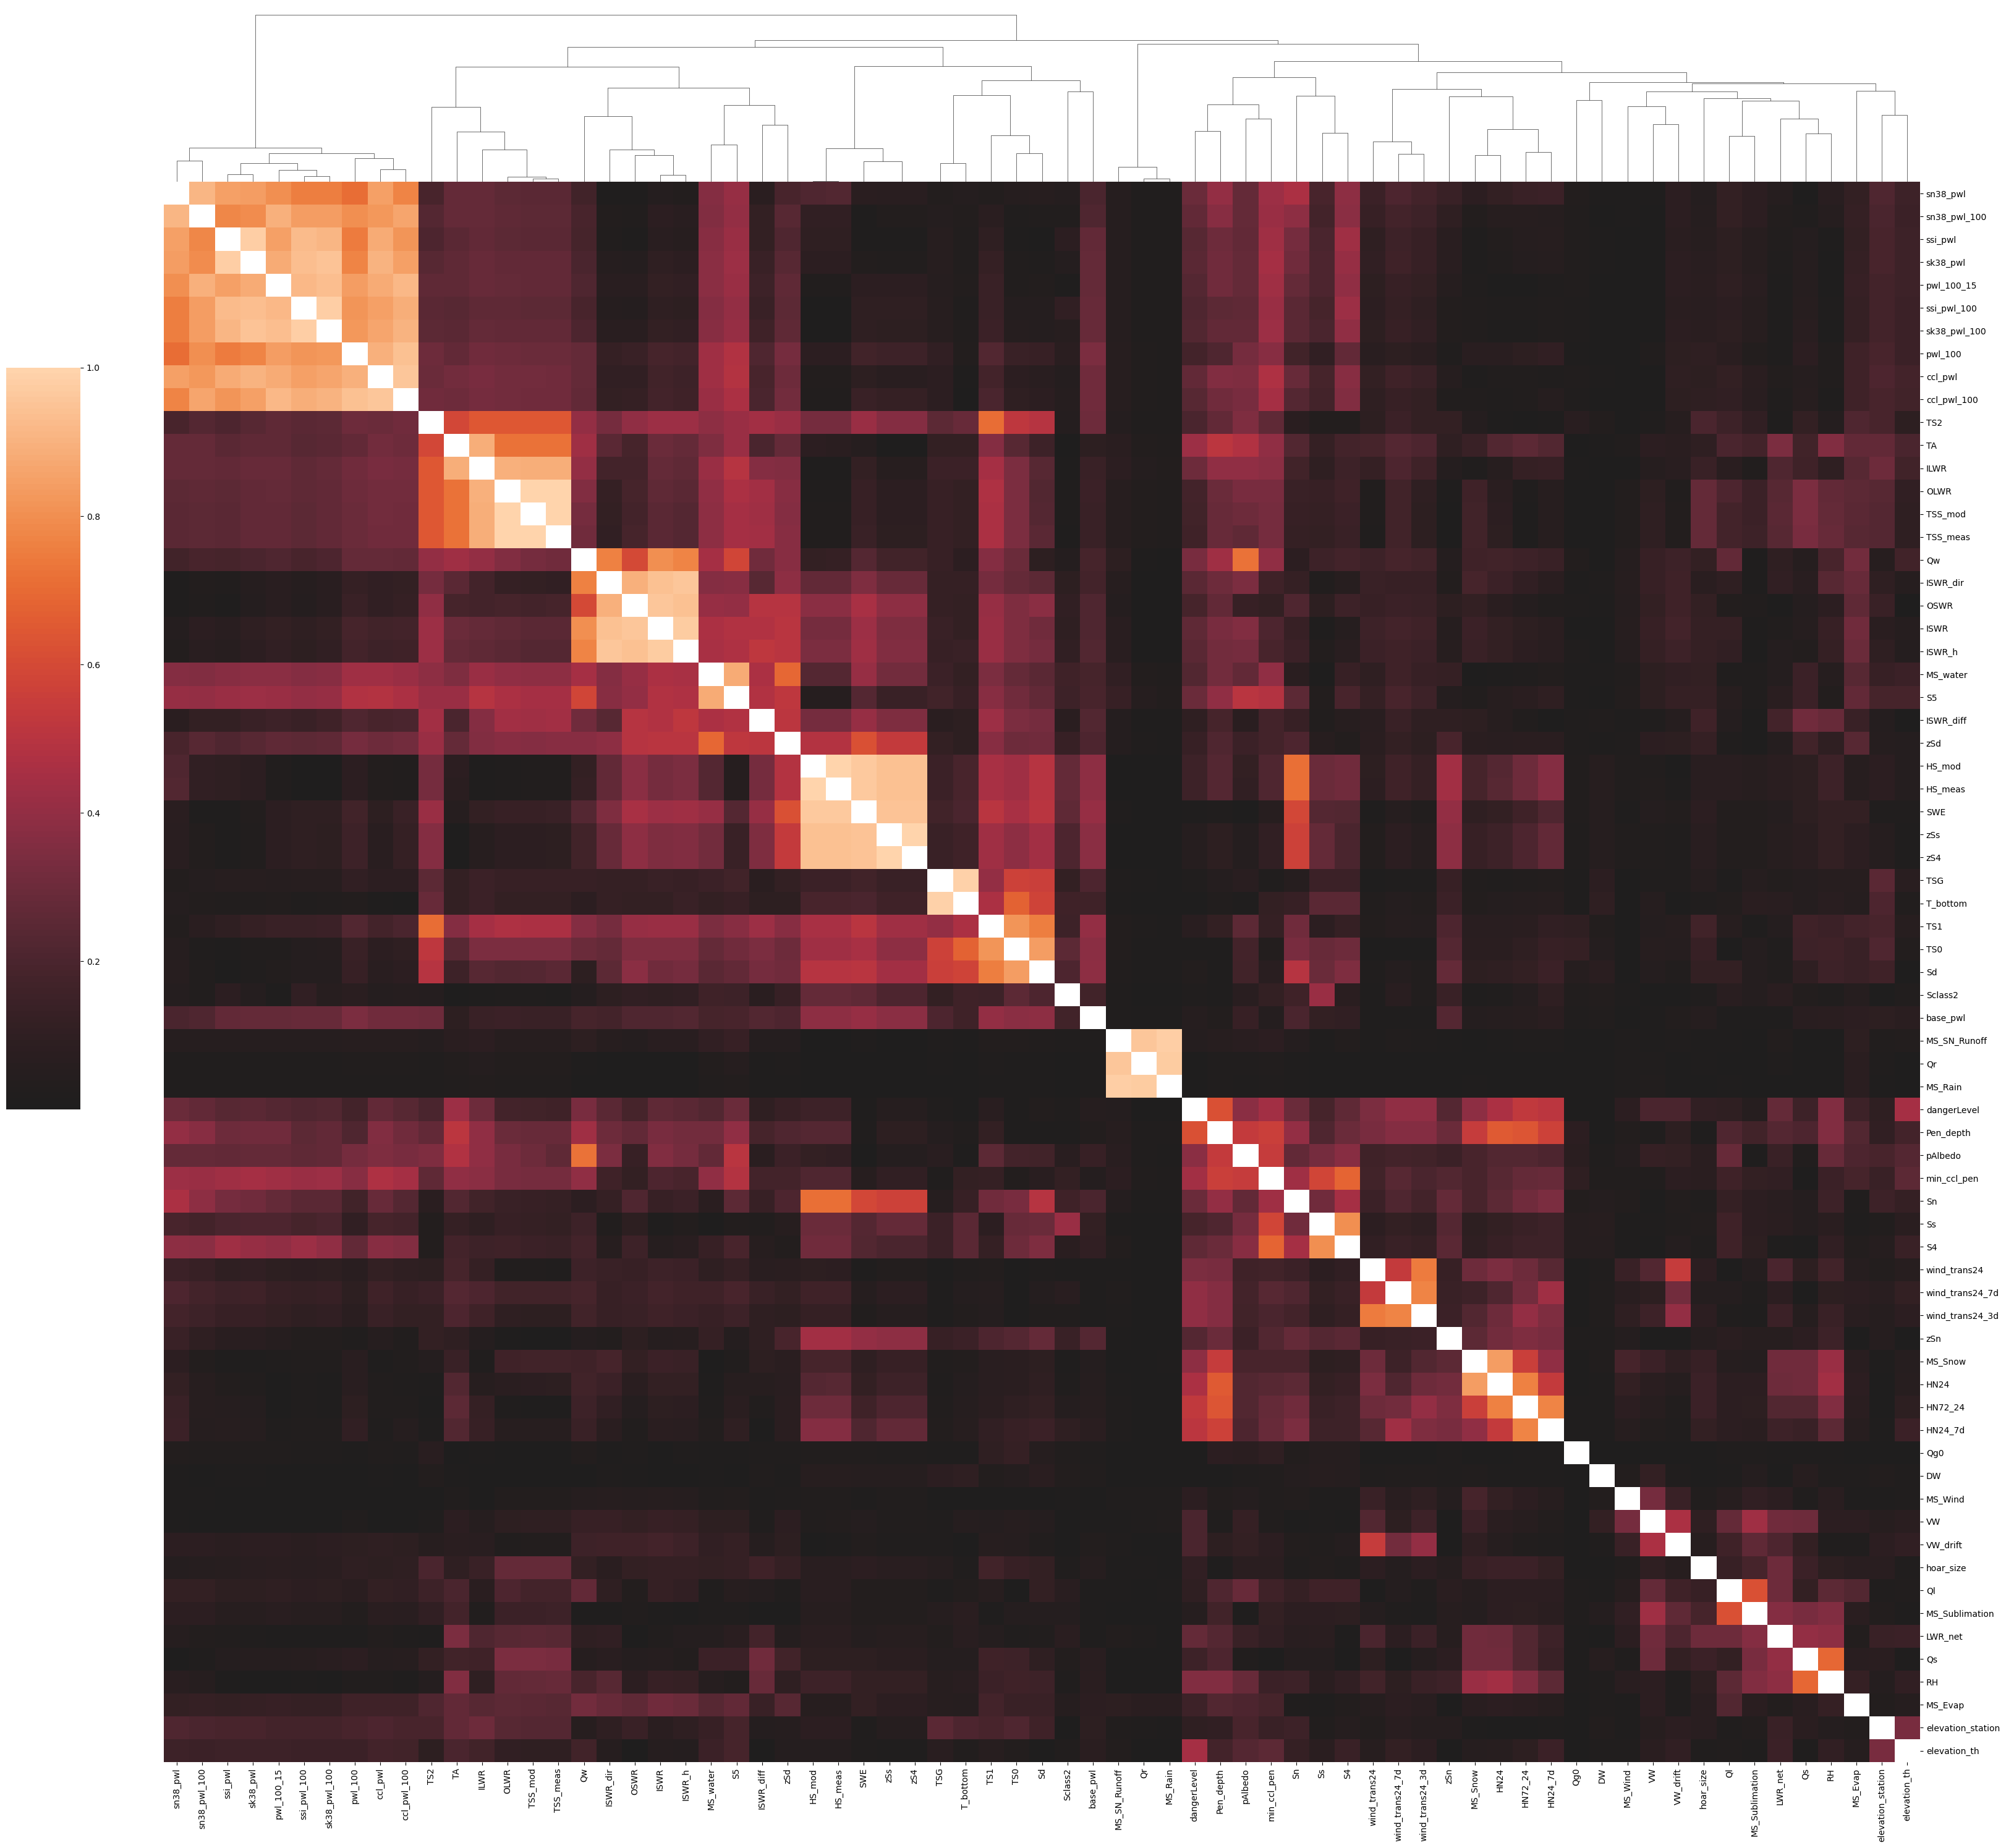

In [87]:
corr = data.corr()

abs_corr = np.abs(corr) #Take the absolute values

cluster_map = sns.clustermap(abs_corr,
               mask=np.eye(len(abs_corr)),
               center=0, cbar_pos=(-0.08, 0.4, 0.04, 0.4), dendrogram_ratio=(0, 0.1),
               figsize=(30, 30));

We can see that there are a few "clusters" or "groups of features" that are highly correlated with each other. We have the 7 following clusters: 

- `sn38_pwl`, `sn38_pwl_100`, `ssi_pwl`, `sk38_pwl`, `pwl_100_15`, `ssi_pwl_100`, `sk38_pwl_100`, `pwl_100`, `ccl_pwl`, `ccl_pwl_100`

- `MS_SN_Runoff`, `Qr`, `MS_Rain`

- `HS_mod`, `HS_meas`, `SWE`, `zS4`, `zSs`

- `TSG`, `T_bottom`

- `TA`, `ILWR`, `OLWR`, `TSS_mod`, `TSS_meas`

- `Qw`, `ISWR_dir`, `OSWR`,`ISWR`, `ISWR_h`

- `MS_water`, `S5`

As these features are highly-correlated among themselves, we decide to only keep some variables within every cluster and remove the others. We can make our selecting decision taking into account the following points. In each cluster, which feature:

- is the most correlated with `dangerLevel` ?
- has the fewest missing values ? 
- has the highest correlation rates distributed across the entire cluster (e.g the sum of all correlation coefficients in absolute value is the highest) ?

Let's then take a closer look on the clusters.

In [88]:
# Definition of the clusters
clusters = [["sn38_pwl", "sn38_pwl_100", "ssi_pwl", "sk38_pwl", "pwl_100_15", "ssi_pwl_100",
             "sk38_pwl_100", "pwl_100", "ccl_pwl", "ccl_pwl_100"], # Cluster 1
            ["MS_SN_Runoff", "Qr", "MS_Rain"], # Cluster 2
            ["HS_mod", "HS_meas", "SWE", "zS4", "zSs"], # Cluster 3
            ["TSG", "T_bottom"], # Cluster 4
            ["TA", "ILWR", "OLWR", "TSS_mod", "TSS_meas"], # Cluster 5
            ["Qw", "ISWR_dir", "OSWR","ISWR", "ISWR_h"], # Cluster 6
            ["MS_water", "S5"] # Cluster 7
           ]

# Store for each cluser the definitions of its features and correlation matrix
definitions = []
corr_matrices = []

for cluster in clusters:
    
    definition = meta_data[meta_data["Feature name"].isin(cluster)]
    corr_matrix = round(data[cluster].corr(), 2)
    
    definitions.append(definition)
    corr_matrices.append(corr_matrix)

Let's start with the first cluster, we provide here the descriptions of its features. 

In [89]:
definitions[0]

Feature description  \
54   Persistent weak layer(s) in the 100 cm from the surface [–]   
55  Persistent weak layer(s) at depths between 15 and 100 cm [-]   
57                  Structural stability index at weak layer [–]   
58          Structural stability index at surface weak layer [–]   
59                  Sk38 skier stability index at weak layer [–]   
60          Sk38 skier stability index at surface weak layer [–]   
61                     Natural stability index at weak layer [–]   
62             Natural stability index at surface weak layer [–]   
63                         Critical cut length at weak layer [m]   
64                 Critical cut length at surface weak layer [m]   

    Feature name     Type  
54       pwl_100  Profile  
55    pwl_100_15  Profile  
57       ssi_pwl  Profile  
58   ssi_pwl_100  Profile  
59      sk38_pwl  Profile  
60  sk38_pwl_100  Profile  
61      sn38_pwl  Profile  
62  sn38_pwl_100  Profile  
63       ccl_pwl  Profile  
64   ccl_pwl_100  Profile

These are the profile variables. In fact, the cluster 1 doesn't have all the profile variables, it is missing `base_pwl`, `min_ccl_pen` and `Pen_depth` as we can see with the table from below. 

In [90]:
meta_data[meta_data["Type"]=="Profile"]

Feature description  \
54             Persistent weak layer(s) in the 100 cm from the surface [–]   
55            Persistent weak layer(s) at depths between 15 and 100 cm [-]   
56                                     Persistent weak layer at bottom [–]   
57                            Structural stability index at weak layer [–]   
58                    Structural stability index at surface weak layer [–]   
59                            Sk38 skier stability index at weak layer [–]   
60                    Sk38 skier stability index at surface weak layer [–]   
61                               Natural stability index at weak layer [–]   
62                       Natural stability index at surface weak layer [–]   
63                                   Critical cut length at weak layer [m]   
64                           Critical cut length at surface weak layer [m]   
65  Min critical cut length at a deeper layer of the penetration depth [m]   
66                                            Skier penetration depth [cm]   

    Feature name     Type  
54       pwl_100  Profile  
55    pwl_100_15  Profile  
56      base_pwl  Profile  
57       ssi_pwl  Profile  
58   ssi_pwl_100  Profile  
59      sk38_pwl  Profile  
60  sk38_pwl_100  Profile  
61      sn38_pwl  Profile  
62  sn38_pwl_100  Profile  
63       ccl_pwl  Profile  
64   ccl_pwl_100  Profile  
65   min_ccl_pen  Profile  
66     Pen_depth  Profile

Let's see now the correlation coefficients in this cluster.

In [91]:
corr_matrices[0]

sn38_pwl  sn38_pwl_100  ssi_pwl  sk38_pwl  pwl_100_15  \
sn38_pwl          1.00          0.91     0.85      0.84       -0.80   
sn38_pwl_100      0.91          1.00     0.78      0.80       -0.89   
ssi_pwl           0.85          0.78     1.00      0.98       -0.85   
sk38_pwl          0.84          0.80     0.98      1.00       -0.88   
pwl_100_15       -0.80         -0.89    -0.85     -0.88        1.00   
ssi_pwl_100       0.75          0.84     0.93      0.93       -0.92   
sk38_pwl_100      0.76          0.84     0.91      0.95       -0.93   
pwl_100          -0.71         -0.80    -0.74     -0.77        0.84   
ccl_pwl           0.85          0.83     0.88      0.90       -0.88   
ccl_pwl_100       0.77          0.86     0.82      0.85       -0.91   

              ssi_pwl_100  sk38_pwl_100  pwl_100  ccl_pwl  ccl_pwl_100  
sn38_pwl             0.75          0.76    -0.71     0.85         0.77  
sn38_pwl_100         0.84          0.84    -0.80     0.83         0.86  
ssi_pwl              0.93          0.91    -0.74     0.88         0.82  
sk38_pwl             0.93          0.95    -0.77     0.90         0.85  
pwl_100_15          -0.92         -0.93     0.84    -0.88        -0.91  
ssi_pwl_100          1.00          0.98    -0.81     0.85         0.88  
sk38_pwl_100         0.98          1.00    -0.83     0.86         0.90  
pwl_100             -0.81         -0.83     1.00    -0.89        -0.94  
ccl_pwl              0.85          0.86    -0.89     1.00         0.96  
ccl_pwl_100          0.88          0.90    -0.94     0.96         1.00

We see that `pwl_100_15` and `pwl_100` are inversely correlated with the other features and overall all the coefficients are high, in absolute values. The lowest coefficient is :

In [92]:
np.abs(corr_matrices[0]).min().min()

0.71

The coefficients above 0.9 are situated: 

In [93]:
np.abs(corr_matrices[0])[np.abs(corr_matrices[0]>=0.9)]

sn38_pwl  sn38_pwl_100  ssi_pwl  sk38_pwl  pwl_100_15  \
sn38_pwl          1.00          0.91      NaN       NaN         NaN   
sn38_pwl_100      0.91          1.00      NaN       NaN         NaN   
ssi_pwl            NaN           NaN     1.00      0.98         NaN   
sk38_pwl           NaN           NaN     0.98      1.00         NaN   
pwl_100_15         NaN           NaN      NaN       NaN         1.0   
ssi_pwl_100        NaN           NaN     0.93      0.93         NaN   
sk38_pwl_100       NaN           NaN     0.91      0.95         NaN   
pwl_100            NaN           NaN      NaN       NaN         NaN   
ccl_pwl            NaN           NaN      NaN      0.90         NaN   
ccl_pwl_100        NaN           NaN      NaN       NaN         NaN   

              ssi_pwl_100  sk38_pwl_100  pwl_100  ccl_pwl  ccl_pwl_100  
sn38_pwl              NaN           NaN      NaN      NaN          NaN  
sn38_pwl_100          NaN           NaN      NaN      NaN          NaN  
ssi_pwl              0.93          0.91      NaN      NaN          NaN  
sk38_pwl             0.93          0.95      NaN     0.90          NaN  
pwl_100_15            NaN           NaN      NaN      NaN          NaN  
ssi_pwl_100          1.00          0.98      NaN      NaN          NaN  
sk38_pwl_100         0.98          1.00      NaN      NaN         0.90  
pwl_100               NaN           NaN      1.0      NaN          NaN  
ccl_pwl               NaN           NaN      NaN     1.00         0.96  
ccl_pwl_100           NaN          0.90      NaN     0.96         1.00

We can see that this cluster has "sub-clusters" of features correlated with a correlation coefficient above 0.9. We will select: 

- a feature between `sn38_pwl` and `sn38_pwl_100`
- a feature between `ssi_pwl`, `sk38_pwl`, `ssi_pwl_100`, `sk38_pwl_100`
- a feature between `pwl_100_15` and `pwl_100` because their correlation coefficient is 0.88 which we consider as high enough and because the measure the same quantity just at a different depth
- a feature between `ccl_pwl` and `ccl_pwl_100`

Let's see now their relation with `dangerLevel`:

In [94]:
data.corr().loc["dangerLevel", clusters[0]]

sn38_pwl       -0.290959
sn38_pwl_100   -0.271056
ssi_pwl        -0.239753
sk38_pwl       -0.248360
pwl_100_15      0.233459
ssi_pwl_100    -0.213001
sk38_pwl_100   -0.223610
pwl_100         0.179313
ccl_pwl        -0.271646
ccl_pwl_100    -0.241979
Name: dangerLevel, dtype: float64

We take `sn38_pwl`, `sk38_pwl`, `pwl_100_15` and `ccl_pwl` because they have a higher correlation coefficient with `dangerLevel` (in absolute value) compared to the other features in their respective "sub-cluster". 

In [95]:
# Correlation matrix of the remaining variables in cluster 1
corr_final = data.corr().loc[["sn38_pwl", "sk38_pwl", "pwl_100_15","ccl_pwl"],
                             ["sn38_pwl", "sk38_pwl", "pwl_100_15","ccl_pwl"]].copy()

corr_final

sn38_pwl  sk38_pwl  pwl_100_15   ccl_pwl
sn38_pwl    1.000000  0.841592   -0.803390  0.849500
sk38_pwl    0.841592  1.000000   -0.880217  0.898881
pwl_100_15 -0.803390 -0.880217    1.000000 -0.875240
ccl_pwl     0.849500  0.898881   -0.875240  1.000000

We see that the correlation coefficients between the remaining features are still close to 0.9. We can afford to select only one of them. We can have a look on the sum of the correlation coefficients in absolute value. 

In [96]:
corr_final_abs = np.abs(corr_final)
corr_final_abs["sum"] = corr_final_abs.sum(axis=0)
corr_final_abs

sn38_pwl  sk38_pwl  pwl_100_15   ccl_pwl       sum
sn38_pwl    1.000000  0.841592    0.803390  0.849500  3.494483
sk38_pwl    0.841592  1.000000    0.880217  0.898881  3.620690
pwl_100_15  0.803390  0.880217    1.000000  0.875240  3.558847
ccl_pwl     0.849500  0.898881    0.875240  1.000000  3.623621

`sk38_pwl` and `ccl_pwl` keep the most information between those variables as the sum of their coefficient are the highest. But let's have a look on how many missing values each of these feature have: 

In [97]:
data[["sn38_pwl", "sk38_pwl", "pwl_100_15","ccl_pwl"]].isna().sum()

sn38_pwl      3465
sk38_pwl      3465
pwl_100_15    3465
ccl_pwl       3494
dtype: int64

As `ccl_pwl` has more missing values than `sk38_pwl`, we will only keep `sk38_pwl` in the first cluster. 

Let's continue with the second cluster.

In [98]:
definitions[1]

Feature description  Feature name      Type
4               Rain energy [W m2]            Qr  Modelled
36          Rain rate [kg s−2 h−1]       MS_Rain  Modelled
37  Virtual lysimeter [kg s−2 h−1]  MS_SN_Runoff  Modelled

In [99]:
corr_matrices[1]

MS_SN_Runoff    Qr  MS_Rain
MS_SN_Runoff          1.00  0.95     0.98
Qr                    0.95  1.00     0.97
MS_Rain               0.98  0.97     1.00

`MS_Rain` has the highest correlation coefficients. Let's observe the missing values.

In [100]:
data[clusters[1]].isna().sum()

MS_SN_Runoff    0
Qr              0
MS_Rain         0
dtype: int64

So we will keep only `MS_Rain`. 

In [101]:
definitions[2]

Feature description Feature name      Type
24                          Snow height [cm]       HS_mod  Modelled
25                          Snow height [cm]      HS_meas  Measured
33            Snow water equivalent [kg m−2]          SWE  Modelled
49   Depth of Sk38 skier stability index [m]          zSs  Modelled
51  Depth of structural stability index [cm]          zS4  Modelled

In [102]:
corr_matrices[2]

HS_mod  HS_meas   SWE   zS4   zSs
HS_mod     1.00     1.00  0.96  0.94  0.94
HS_meas    1.00     1.00  0.96  0.94  0.94
SWE        0.96     0.96  1.00  0.95  0.95
zS4        0.94     0.94  0.95  1.00  1.00
zSs        0.94     0.94  0.95  1.00  1.00

In [103]:
data[clusters[2]].isna().sum()

HS_mod     0
HS_meas    0
SWE        0
zS4        0
zSs        0
dtype: int64

All the coefficients in the third cluster are above 0.9, the features inside don't have any missing values so we decide to keep only `MS_mod`.

In [104]:
definitions[3]

Feature description Feature name      Type
2   Ground temperature [∘C]          TSG  Measured
18  Bottom temperature [∘C]     T_bottom  Modelled

In [105]:
corr_matrices[3]

TSG  T_bottom
TSG       1.00      0.99
T_bottom  0.99      1.00

In [106]:
data[clusters[3]].isna().sum()

TSG         5582
T_bottom      34
dtype: int64

We decide to keep `T_bottom` according to the number of missing values. 

Lets' come the the fifth cluster.

In [107]:
definitions[4]

Feature description Feature name      Type
5   Outgoing long-wave radiation [W m−2]         OLWR  Modelled
6   Incoming long-wave radiation [W m−2]         ILWR  Modelled
15                  Air temperature [∘C]           TA  Measured
16              Surface temperature [∘C]      TSS_mod  Modelled
17              Surface temperature [∘C]     TSS_meas  Measured

In [108]:
corr_matrices[4]

TA  ILWR  OLWR  TSS_mod  TSS_meas
TA        1.00  0.88  0.72     0.72      0.72
ILWR      0.88  1.00  0.90     0.89      0.89
OLWR      0.72  0.90  1.00     1.00      0.99
TSS_mod   0.72  0.89  1.00     1.00      1.00
TSS_meas  0.72  0.89  0.99     1.00      1.00

The correlation coefficients in `TA` are below 0.9, this means to we need to keep it. On the contrary, we can make a seletion between the other features. 

In [109]:
data[clusters[4]].isna().sum()

TA          11
ILWR         0
OLWR         0
TSS_mod      0
TSS_meas     5
dtype: int64

In [110]:
data.corr().loc["dangerLevel", clusters[4]]

TA         -0.423704
ILWR       -0.300646
OLWR       -0.173787
TSS_mod    -0.164884
TSS_meas   -0.161804
Name: dangerLevel, dtype: float64

We choose to select `TA` and `TSS_meas`. 

In [111]:
definitions[5]

Feature description Feature name      Type
8          Reflected short-wave radiation [W m−2]         OSWR  Measured
9           Incoming short-wave radiation [W m−2]         ISWR  Modelled
10               Net short-wave radiation [W m−2]           Qw  Modelled
12  Incoming short wave on the horizontal [W m−2]       ISWR_h  Modelled
13             Direct incoming short wave [W m−2]     ISWR_dir  Modelled

In [112]:
corr_matrices[5]


Qw  ISWR_dir  OSWR  ISWR  ISWR_h
Qw        1.00      0.76  0.60  0.80    0.77
ISWR_dir  0.76      1.00  0.89  0.94    0.95
OSWR      0.60      0.89  1.00  0.96    0.94
ISWR      0.80      0.94  0.96  1.00    0.98
ISWR_h    0.77      0.95  0.94  0.98    1.00

In this cluster, `Qw` has its correlation coefficients below 0.9 contrary to the other variables. 

In [113]:
data[clusters[5]].isna().sum()

Qw          0
ISWR_dir    0
OSWR        0
ISWR        0
ISWR_h      0
dtype: int64

We keep `ISWR` because the sum of its correlation coefficients is the highest and also `Qw` because its correlation coefficients are not above 0.9.

In [114]:
definitions[6]

Feature description Feature name      Type
34  Total amount of water [kg m−2]     MS_water  Modelled
52           Stability index 5 [–]           S5  Modelled

In [115]:
corr_matrices[6]

MS_water    S5
MS_water      1.00  0.88
S5            0.88  1.00

In [116]:
data[clusters[6]].isna().sum()

MS_water       0
S5          1489
dtype: int64

We keep `MS_water`.

Let's now summarize what we are the features we will keep for every cluster:

- cluster 0: `sn38_pwl`
- cluster 1: `MS_Rain`
- cluster 2: `HS_meas`
- cluster 3: `T_bottom`
- cluster 4: `TSS_meas` and `TA`
- cluster 5: `ISWR` and `Qw`
- cluster 6: `MS_water`

We remove these variables now from the clusters list. 

In [117]:
clusters[0].remove("sn38_pwl")
clusters[1].remove("MS_Rain")
clusters[2].remove("HS_meas")
clusters[3].remove("T_bottom")
clusters[4].remove("TSS_meas")
clusters[4].remove("TA")
clusters[5].remove("ISWR")
clusters[5].remove("Qw")
clusters[6].remove("MS_water")

In [118]:
# Remove the features that are in a cluster list 
class RemoveHighCorrelated:
    
    def transform(self, dataset):
        for i in range(len(clusters)):
            dataset.drop(clusters[i], axis=1, inplace=True)

In [119]:
RHC = RemoveHighCorrelated()

RHC.transform(data)

In [120]:
diff_col()

Since the beginning:

Columns deleted: ['TSG', 'ccl_pwl_100', 'MS_SN_Runoff', 'sn38_pwl_100', 'ccl_pwl', 'sk38_pwl_100', 'ssi_pwl', 'S5', 'ISWR_h', 'ILWR', 'HS_mod', 'SWE', 'ssi_pwl_100', 'zSs', 'Qr', 'zS4', 'pwl_100', 'sk38_pwl', 'OSWR', 'TSS_mod', 'OLWR', 'pwl_100_15', 'ISWR_dir']
Number of columns deleted: 23

Columns added: []
Number of columns added: 0


In [121]:
rows_deleted()

Number of rows beginning: 244327

Number of rows now: 244327

Since the beginning we have deleted: 0 rows representing 0.000%


In [122]:
missing_values()

Number of missing values beginning: 198494
Percentage missing values beginning: 1.113%

Number of missing values now: 137655
Percentage of missing values now: 1.127%


#### B. 3. 2. With the target variable

We show the 10 features that have the highest and lowest correlation coefficient, in absolute value, with `dangerLevel`.

In [123]:
# Show the highest correlated features with the target variable

# Table of the features correlation coefficients (in absolute value) with dangerLevel
dl_corr = pd.DataFrame(abs_corr["dangerLevel"].sort_values(ascending=False).drop("dangerLevel"))

descriptions = []

for name in dl_corr.index:
    
    if name in meta_data["Feature name"].values:
        description = meta_data.loc[meta_data["Feature name"] == name, "Feature description"].values[0]
        
    else:
        
        if name == "elevation_th":
            description = "Elevation threshold"
        
        if name == "elevation_station":
            description = "Elevation station"
        
        if name == "sector_id":
            description = "Sector id"
        
        if name == "warnreg":
            description = "Warning Region"
    
    descriptions.append(description)

dl_corr["Description"] = descriptions
dl_corr.head(10)

dangerLevel  \
Pen_depth           0.618575   
HN72_24             0.528703   
HN24_7d             0.513432   
HN24                0.467715   
elevation_th        0.450758   
min_ccl_pen         0.437905   
TA                  0.423704   
wind_trans24_7d     0.393258   
wind_trans24_3d     0.392340   
MS_Snow             0.388021   

                                                                            Description  
Pen_depth                                                  Skier penetration depth [cm]  
HN72_24                                        3 d sum of daily height of new snow [cm]  
HN24_7d                                        7 d sum of daily height of new snow [cm]  
HN24                                                       24 h height of new snow [cm]  
elevation_th                                                        Elevation threshold  
min_ccl_pen      Min critical cut length at a deeper layer of the penetration depth [m]  
TA                                                                 Air temperature [∘C]  
wind_trans24_7d                                                     7 d wind drift [cm]  
wind_trans24_3d                                                     3 d wind drift [cm]  
MS_Snow                                           Solid precipitation rate [kg s−2 h−1]

We can see that the correlation coefficients (again in absolute values) are not really high, at most 0.6. But as we expected, the variables related to the amount of snow fallen in the last days, wind drift and air temperature are the features with the strongest relation with `dangerLevel`. However, the most correlated feature with the target variable is `Skier penetration depth`. That is quiet interesting. 

Also we see that `elevation_th` is present in this table. Indeed, by experience, most of the time when the danger level is high, it happends generally in the winter period and so the elevation threshold in the bulletin is generally low. 

In [124]:
# Show the lowest correlated features with the target variable
dl_corr.tail(10)

dangerLevel                            Description
Sd           0.038158   Deformation rate stability index [–]
Sclass2      0.017076                    Stability class [–]
TSG          0.016609                Ground temperature [∘C]
TS0          0.009332        Snow temperature at 0.25 m [∘C]
SWE          0.007870         Snow water equivalent [kg m−2]
Qg0          0.005148  Ground heat at soil interface [W m−2]
T_bottom     0.004393                Bottom temperature [∘C]
MS_Rain      0.003383                 Rain rate [kg s−2 h−1]
Qr           0.002362                     Rain energy [W m2]
DW           0.002166                     Wind direction [∘]

It is not really surprising that the features that have the lowest coefficient correlation with `dangerLevel`, are ground or bottom temperature because they don't vary much. 

It is neither surprising to see the wind direction in this table. Intuitively, the direction of the wind direction doesn't influent wether or not the avalanche danger level increase, on the contrary of its strength. 

For this reason, we decide to remove `DW`. 

In [125]:
class Drop1:
    
    def transform(self, dataset):
        
        dataset.drop("DW", axis = 1, inplace = True)

In [126]:
drop_dw = Drop1()

drop_dw.transform(data)

We provide now boxplots of all features against the target variable.

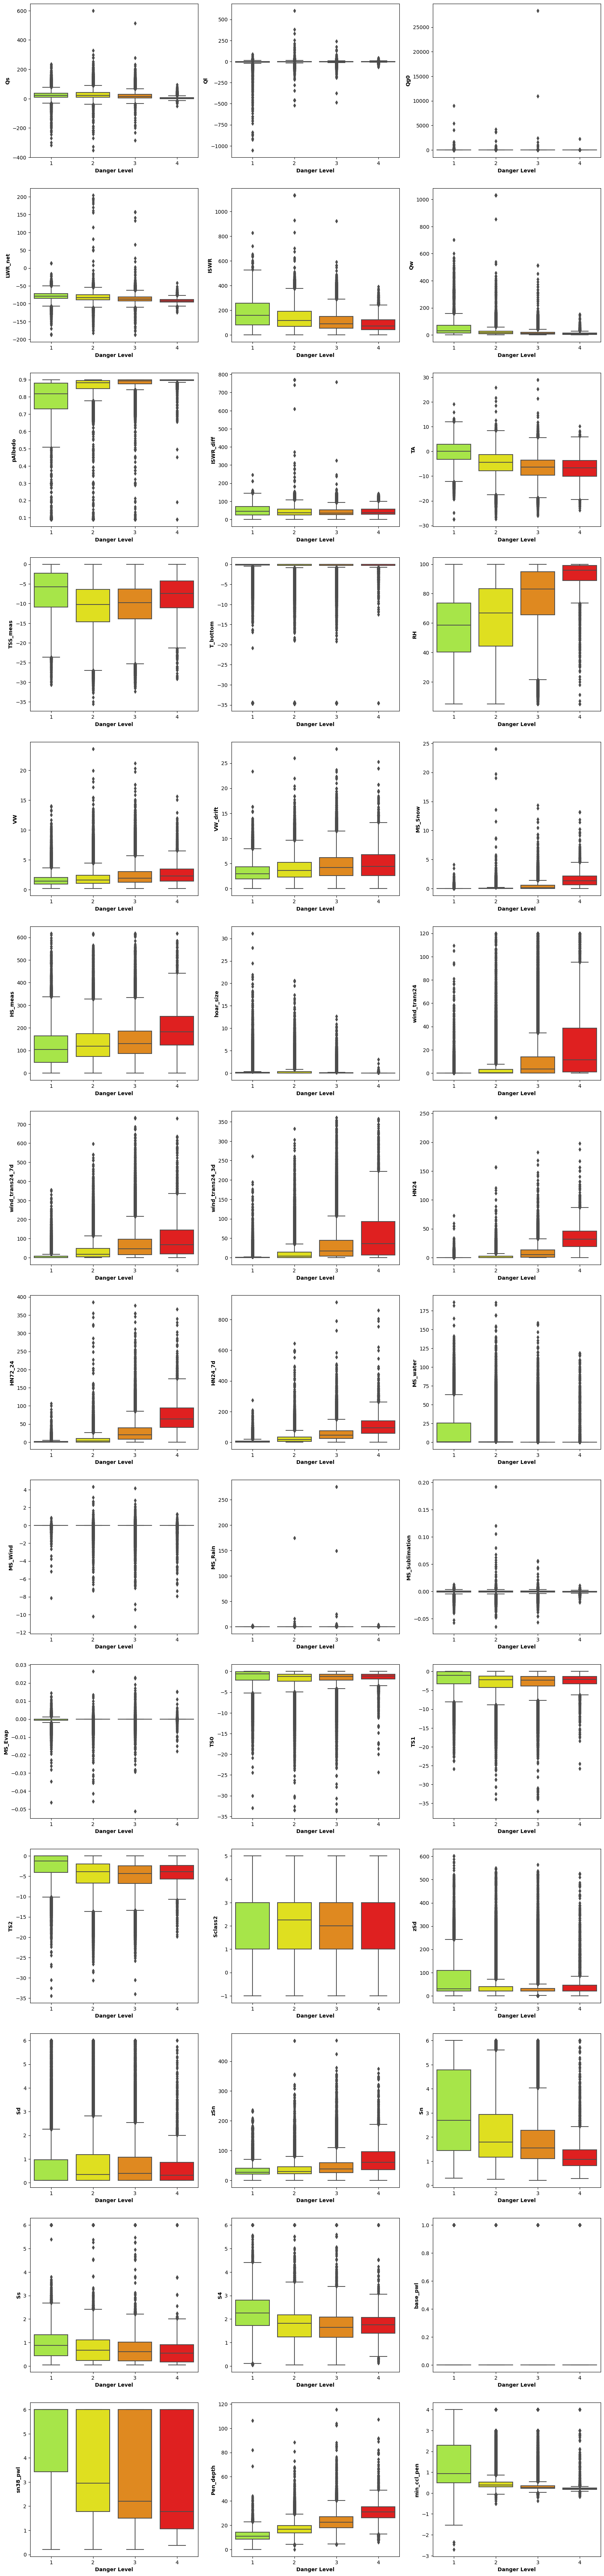

In [127]:
fig, axes = plt.subplots(nrows = 14, ncols = 3, figsize = (20, 90))
axes = axes.flatten()

for idx, col in enumerate(data.iloc[:,7:].columns.to_list()):
        ax = axes[idx]
        sns.boxplot(y = data[col],
                    x = data["dangerLevel"],
                    ax = ax,
                    palette = ["greenyellow", "yellow", "darkorange", "red", "grey"])
    
        ax.set_xlabel("Danger Level", fontsize = 10, fontweight = "bold")
        ax.set_ylabel(col, fontsize = 10, fontweight = "bold")

We can see interesting different patterns:

- the higher the value of the variable, the greater the danger (on average). This is the case for example of `VW` (wind velocity), `MS_Snow` (solid precipiration rate), `HN_24` (24h height of new snow) or `Pen_depth` (skier penetration depth)

- the lower the value of the variable, the greater the danger (on average). For example `ISWR`, `TA`, `Sn` (incoming short-wave radiation, air temperature, natural stability index respectively)

- some distributions of features seem insensitive to variations of `dangerLevel`. Such as `Qs`, `ISWR_diff`, `T_bottom`, `base_pwl`. 

### B. 4. Missing values

Now that we have removed some highly-correlated features with the help of the criteria of the number of missing values, we can come back on the remaining missing values. 

We have already fill the missing values in `elevation_th` with 1500m or 2000m. Let's see where are the remaining missing values. 

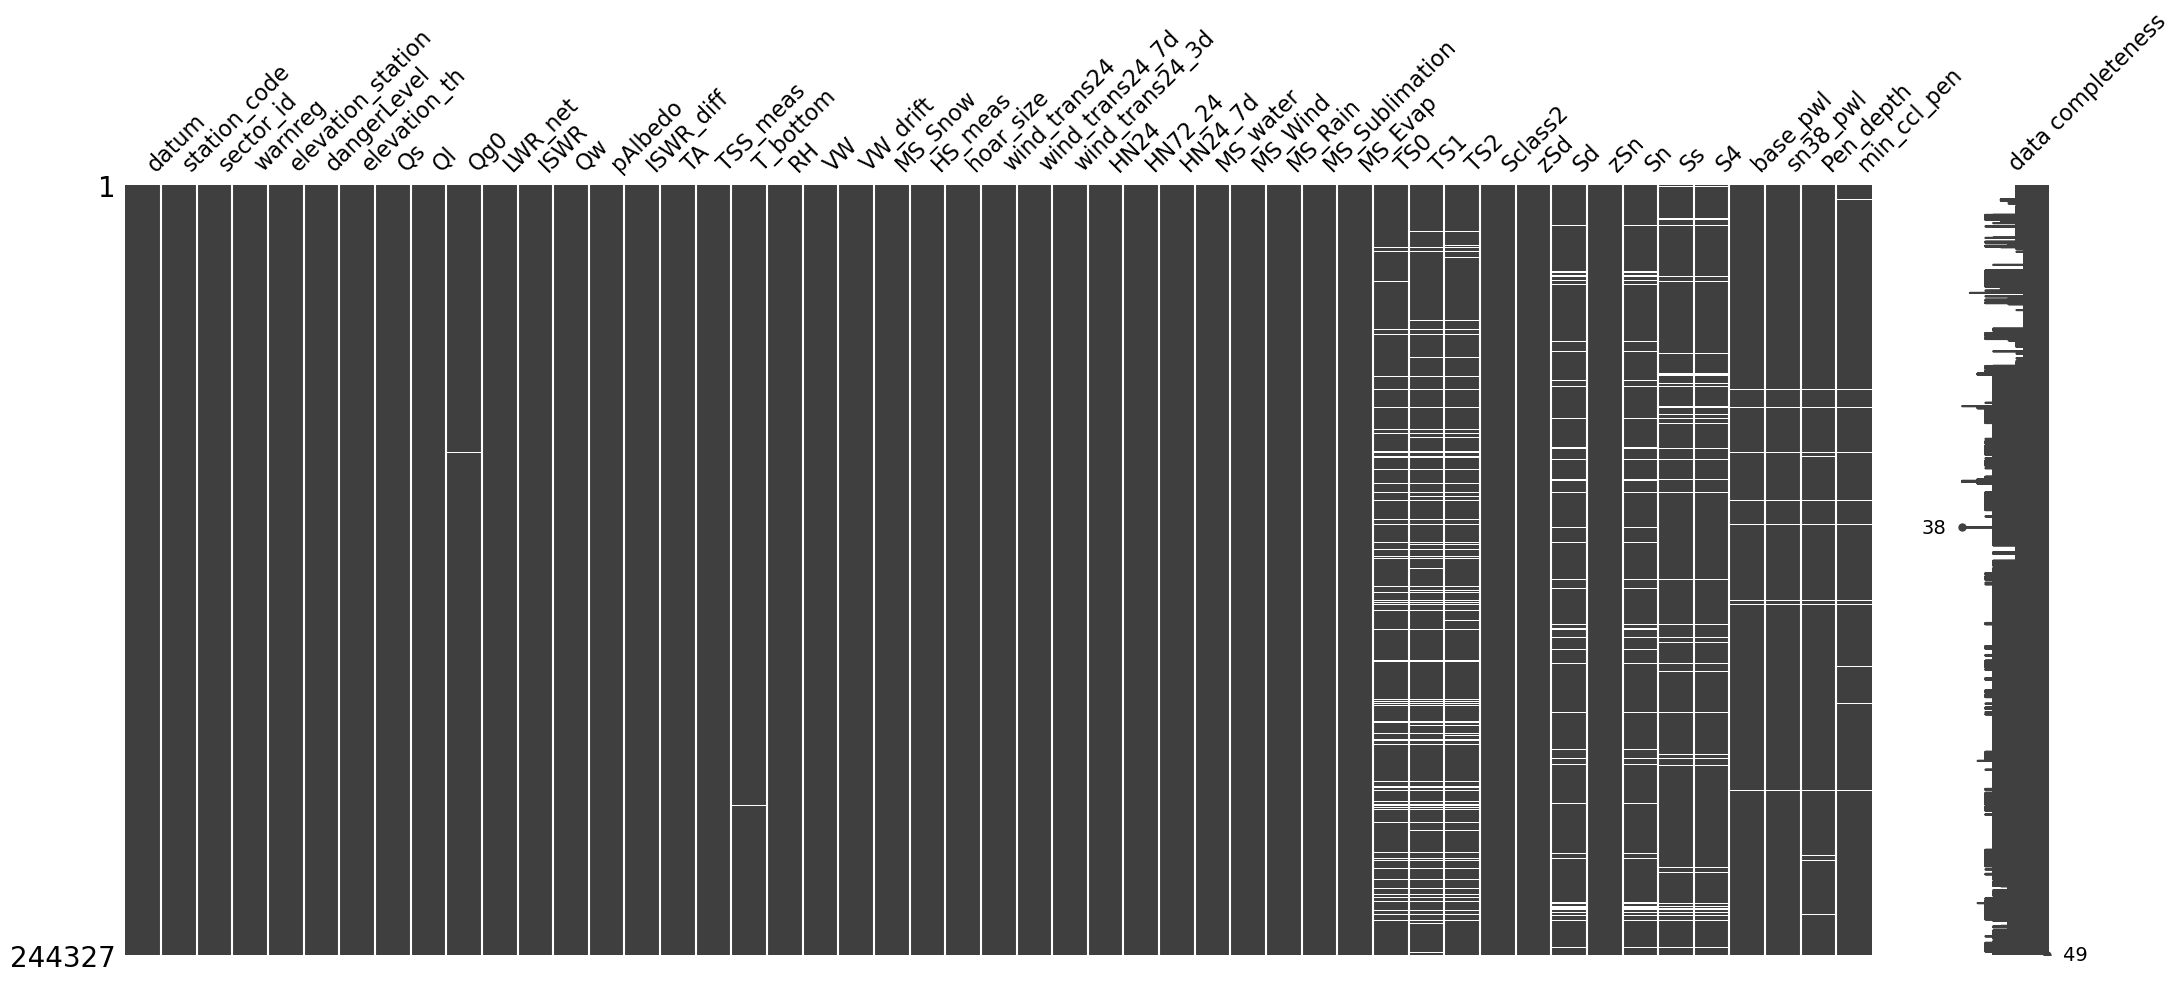

In [128]:
msno.matrix(data, labels = True);

We see that there are observations that have missing values in more than a column. Let's see if this is caused by a stations that have a lot of missing values. 

In [129]:
# Count the number of missing values per station accross all features
group_station = data.drop('station_code', axis=1).isna().groupby(data.station_code, sort=False).sum().reset_index()
group_station.set_index("station_code", inplace=True)
group_station.head()

datum  sector_id  warnreg  elevation_station  dangerLevel  \
station_code                                                              
KES2              0          0        0                  0            0   
SIM2              0          0        0                  0            0   
DTR2              0          0        0                  0            0   
MEI2              0          0        0                  0            0   
SPN2              0          0        0                  0            0   

              elevation_th  Qs  Ql  Qg0  LWR_net  ...  zSd   Sd  zSn   Sn  \
station_code                                      ...                       
KES2                     0   0   0    0        0  ...    0   57    0   57   
SIM2                     0   0   0   33        0  ...    0  165    0  165   
DTR2                     0   0   0   39        0  ...    0  138    0  138   
MEI2                     0   0   0    0        0  ...    0   77    0   77   
SPN2                     0   0   0    2        0  ...    0  831    0  831   

               Ss   S4  base_pwl  sn38_pwl  Pen_depth  min_ccl_pen  
station_code                                                        
KES2           50   50         0         0          0           14  
SIM2          126  126        35        35         52           55  
DTR2          129  129        39        39         46           42  
MEI2           95   95       132       132          0            0  
SPN2          491  491         5         5         39           69  

[5 rows x 48 columns]

In [130]:
# Count the number and percentage of missing values per stations
nb_na_stations = pd.DataFrame(group_station.sum(axis=1),
                              columns=["Missing values"]).sort_index()

nb_na_stations["Number of data"] = data.groupby("station_code").count()["datum"] * data.shape[1]
nb_na_stations["Number of observations"] = data.groupby("station_code").count()["datum"]
nb_na_stations["Percent NaN values"] = round(nb_na_stations["Missing values"]/ nb_na_stations["Number of data"] * 100, 2)
nb_na_stations["Percent NaN values overall"] = round(nb_na_stations["Missing values"] / data.isna().sum().sum() * 100, 2)
nb_na_stations.sort_values(by = "Percent NaN values overall", ascending = False).head(7)

Missing values  Number of data  Number of observations  \
station_code                                                           
ROT2                   10998           76342                    1558   
FOU2                    7711          121961                    2489   
LUM2                    7370          135485                    2765   
BOR2                    7327          118531                    2419   
DAV5                    6564           80311                    1639   
DAV4                    6493           93737                    1913   
FRA3                    5976           76930                    1570   

              Percent NaN values  Percent NaN values overall  
station_code                                                  
ROT2                       14.41                        7.99  
FOU2                        6.32                        5.60  
LUM2                        5.44                        5.35  
BOR2                        6.18                        5.32  
DAV5                        8.17                        4.77  
DAV4                        6.93                        4.72  
FRA3                        7.77                        4.34

The `Percent Nan values` column represents the percentage of missing values in the data subset of the data  recorded by the station.
The `Percent NaN values overall` represents the percentage that these missing values represent in the entire data set.

We see that the station `ROT2` contains 8% of all the missing values, we decide to remove this station from our dataset. 

In [131]:
class DropROT2:
    
    def transform(self, dataset):
        dataset = dataset[~(dataset.station_code == "ROT2")]
        
        return dataset

In [132]:
droprot2 = DropROT2()

data = droprot2.transform(data)

In [133]:
rows_deleted()

Number of rows beginning: 244327

Number of rows now: 242769

Since the beginning we have deleted: 1558 rows representing 0.638%


Let's see now where are the remaing missing values.

In [134]:
tot = data.isna().sum().sum()
percent = data.isna().sum().sum() / data.size * 100

rows = data.isna().sum(axis=1)[data.isna().sum(axis=1) > 0].count()
percent_rows = data.isna().sum(axis=1)[data.isna().sum(axis=1) > 0].count() / data.shape[0] * 100

print("Missing values in total: {}".format(tot))
print("Percent of missing values: {:.2f}%\n".format(percent))
print("Number of rows containing at least a missing value: {}".format(rows))
print("Percent of rows containg at least a missing value: {:.2f}".format(percent_rows))

Missing values in total: 126657
Percent of missing values: 1.06%

Number of rows containing at least a missing value: 40417
Percent of rows containg at least a missing value: 16.65


In [135]:
rows_deleted()

Number of rows beginning: 244327

Number of rows now: 242769

Since the beginning we have deleted: 1558 rows representing 0.638%


Removing every row that has at least a missing value would remove 17% of our data. This now becomes acceptbale since we have a big dataset and our models will take a lot of time to train anyway (because we plan to assume to fine-tune a lot of different parameters, with a big dataset and also taking the number of components of the PCA as an hyper-parameter), so we can afford to remove these missing values.

The only thing that is dangerous, is that we have seen that there only a few samples for which `dangerLevel` is 4. We decide to remove the missing values when `dangerLevel` is not 4.

In [136]:
class DropMissingValues:
    
    def transform(self, dataset):
        dataset = dataset[(dataset.notna().all(axis=1)) | (dataset["dangerLevel"]== 4)]
        return dataset

In [137]:
dmv = DropMissingValues()

data = dmv.transform(data)

In [138]:
rows_deleted()

Number of rows beginning: 244327

Number of rows now: 202902

Since the beginning we have deleted: 41425 rows representing 16.955%


In [139]:
missing_values()

Number of missing values beginning: 198494
Percentage missing values beginning: 1.113%

Number of missing values now: 1522
Percentage of missing values now: 0.015%


The remaining missing values are only in:  

In [140]:
data.isna().sum()[data.isna().sum()>0]

Qg0              2
HN24             1
HN72_24          4
TS0            283
TS1            352
TS2            402
Sd              88
Sn              88
Ss             134
S4             134
base_pwl         7
sn38_pwl         7
Pen_depth       14
min_ccl_pen      6
dtype: int64

Our strategy would be to replace the missing values in each feature with its mean. But we also see that in the features from above, some are not necessarily continuous variables. Let's see the features that are encoded as `float64` but contain infact only integers.

In [141]:
integer_columns(data[data.isna().sum()[data.isna().sum()>0].index.to_list()])

Countains only integers  Number of non-integers  \
base_pwl                     True                       0   

          Number of missing values  
base_pwl                         7

The feature `base_pwl` is de facto a variable of integers. So we replace the missing values with the mean except for `base_pwl` for which we will replace its missing values with its most frequent value.

To do so, we use `SimpleImputer` from scikit-learn. We just need to apply the mean transformation of the columns that are numerical. Remember, the only features that are of type object or dates are the first 4 features:

In [142]:
data.dtypes.head(7)

datum                datetime64[ns]
station_code                 object
sector_id                    object
warnreg                      object
elevation_station             int64
dangerLevel                   int64
elevation_th                float64
dtype: object

We apply SimpleImputer with the most frequent strategy to `base_pwl` and the mean strategy to all features apart from the first 4 ones. We can also change now the data type of `base_pwl` as integer. 

In [143]:
class Imputers:
    
    def transform(self, dataset):
        
        from sklearn.impute import SimpleImputer

        imputer_mean = SimpleImputer(strategy = "mean", copy = False)
        imputer_most_frequent = SimpleImputer(strategy = "most_frequent", copy = False)

        cols = dataset.isna().sum()[dataset.isna().sum()>0].index.to_list() #The remaining columns with at least a missing value 
        cols.remove("base_pwl") 

        dataset["base_pwl"] = imputer_most_frequent.fit_transform(dataset["base_pwl"].values.reshape(-1,1))
        dataset[cols] = imputer_mean.fit_transform(dataset[cols].values); 

        dataset["base_pwl"] = dataset["base_pwl"].astype(int)

In [144]:
imputers = Imputers()

imputers.transform(data)

Let's see the current state of our dataset.

In [145]:
rows_deleted()

Number of rows beginning: 244327

Number of rows now: 202902

Since the beginning we have deleted: 41425 rows representing 16.955%


In [146]:
diff_col()

Since the beginning:

Columns deleted: ['TSG', 'ccl_pwl_100', 'MS_SN_Runoff', 'sn38_pwl_100', 'ccl_pwl', 'sk38_pwl_100', 'ssi_pwl', 'S5', 'ISWR_h', 'ILWR', 'HS_mod', 'SWE', 'ssi_pwl_100', 'zSs', 'Qr', 'zS4', 'pwl_100', 'sk38_pwl', 'OSWR', 'TSS_mod', 'OLWR', 'DW', 'pwl_100_15', 'ISWR_dir']
Number of columns deleted: 24

Columns added: []
Number of columns added: 0


In [147]:
missing_values()

Number of missing values beginning: 198494
Percentage missing values beginning: 1.113%

Number of missing values now: 0
Percentage of missing values now: 0.000%


And the shape of our data is now:



In [148]:
data.shape

(202902, 49)

### B. 5. Outliers handling

Let's explore potential outliers within our features. 

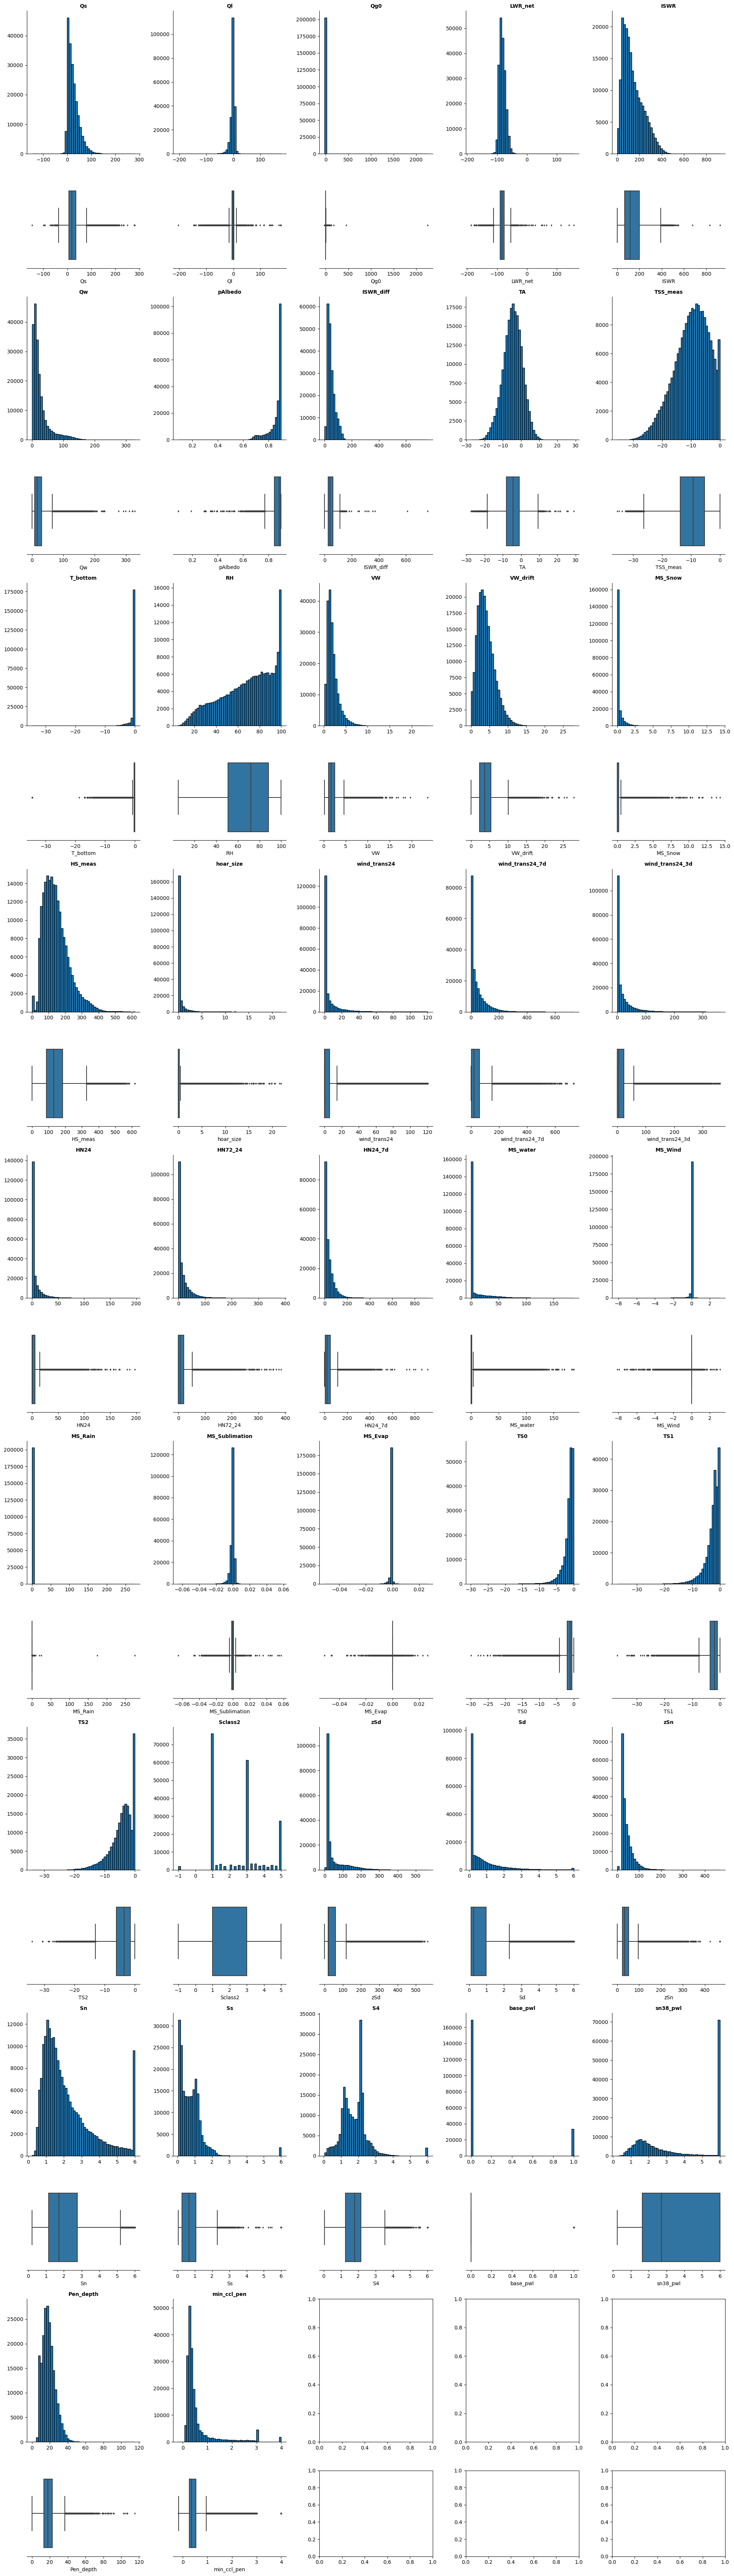

In [150]:
from codes.functions import show_hist

show_hist(data, data.columns[7:], figsize = (20,70))

As we  previously said, there are a lot of different distributions. Some of them are skewed, roughly normal, truncated normal or have a bar shape. We separate the features according to the type of distributions: 



In [151]:
# 12 features
left_skew = ["VW", "VW_drift", "MS_Snow", "hoar_size", "wind_trans24", "wind_trans24_7d", "wind_trans24_3d",
             "HN24", "HN72_24", "HN24_7d", "MS_water", "zSn", "Qw"]

# 4 features
right_skew = ["pAlbedo", "TS0", "TS1", "TS2"]

# 7 features
sym_bell = ["Ql", "LWR_net", "TA", "TSS_meas", "MS_Wind", "MS_Sublimation", "MS_Evap"]

# 9 features
others = ["Qs", "Qg0", "ISWR", "ISWR_diff", "T_bottom", "RH", "HS_meas", "MS_Rain","Sclass2",
         "zSd", "Sd", "S4", "Ss", "S4", "Sn", "base_pwl", "sn38_pwl", "Pen_depth", "min_ccl_pen"]


Let's just verify we didn't forget anyone:

In [152]:
A = set(left_skew).union(set(right_skew)).union(set(sym_bell)).union(set(others)) # Take the union of all sets
B = set(data.columns[7:].to_list()) 

C = A.difference(B).union(B.difference(A)) # Take the union of the two difference sets
C

set()

#### B. 5. 1 Left-skewed

We check here the left-skewed distributions after the transformation:

$$ y = \log(x+1)$$

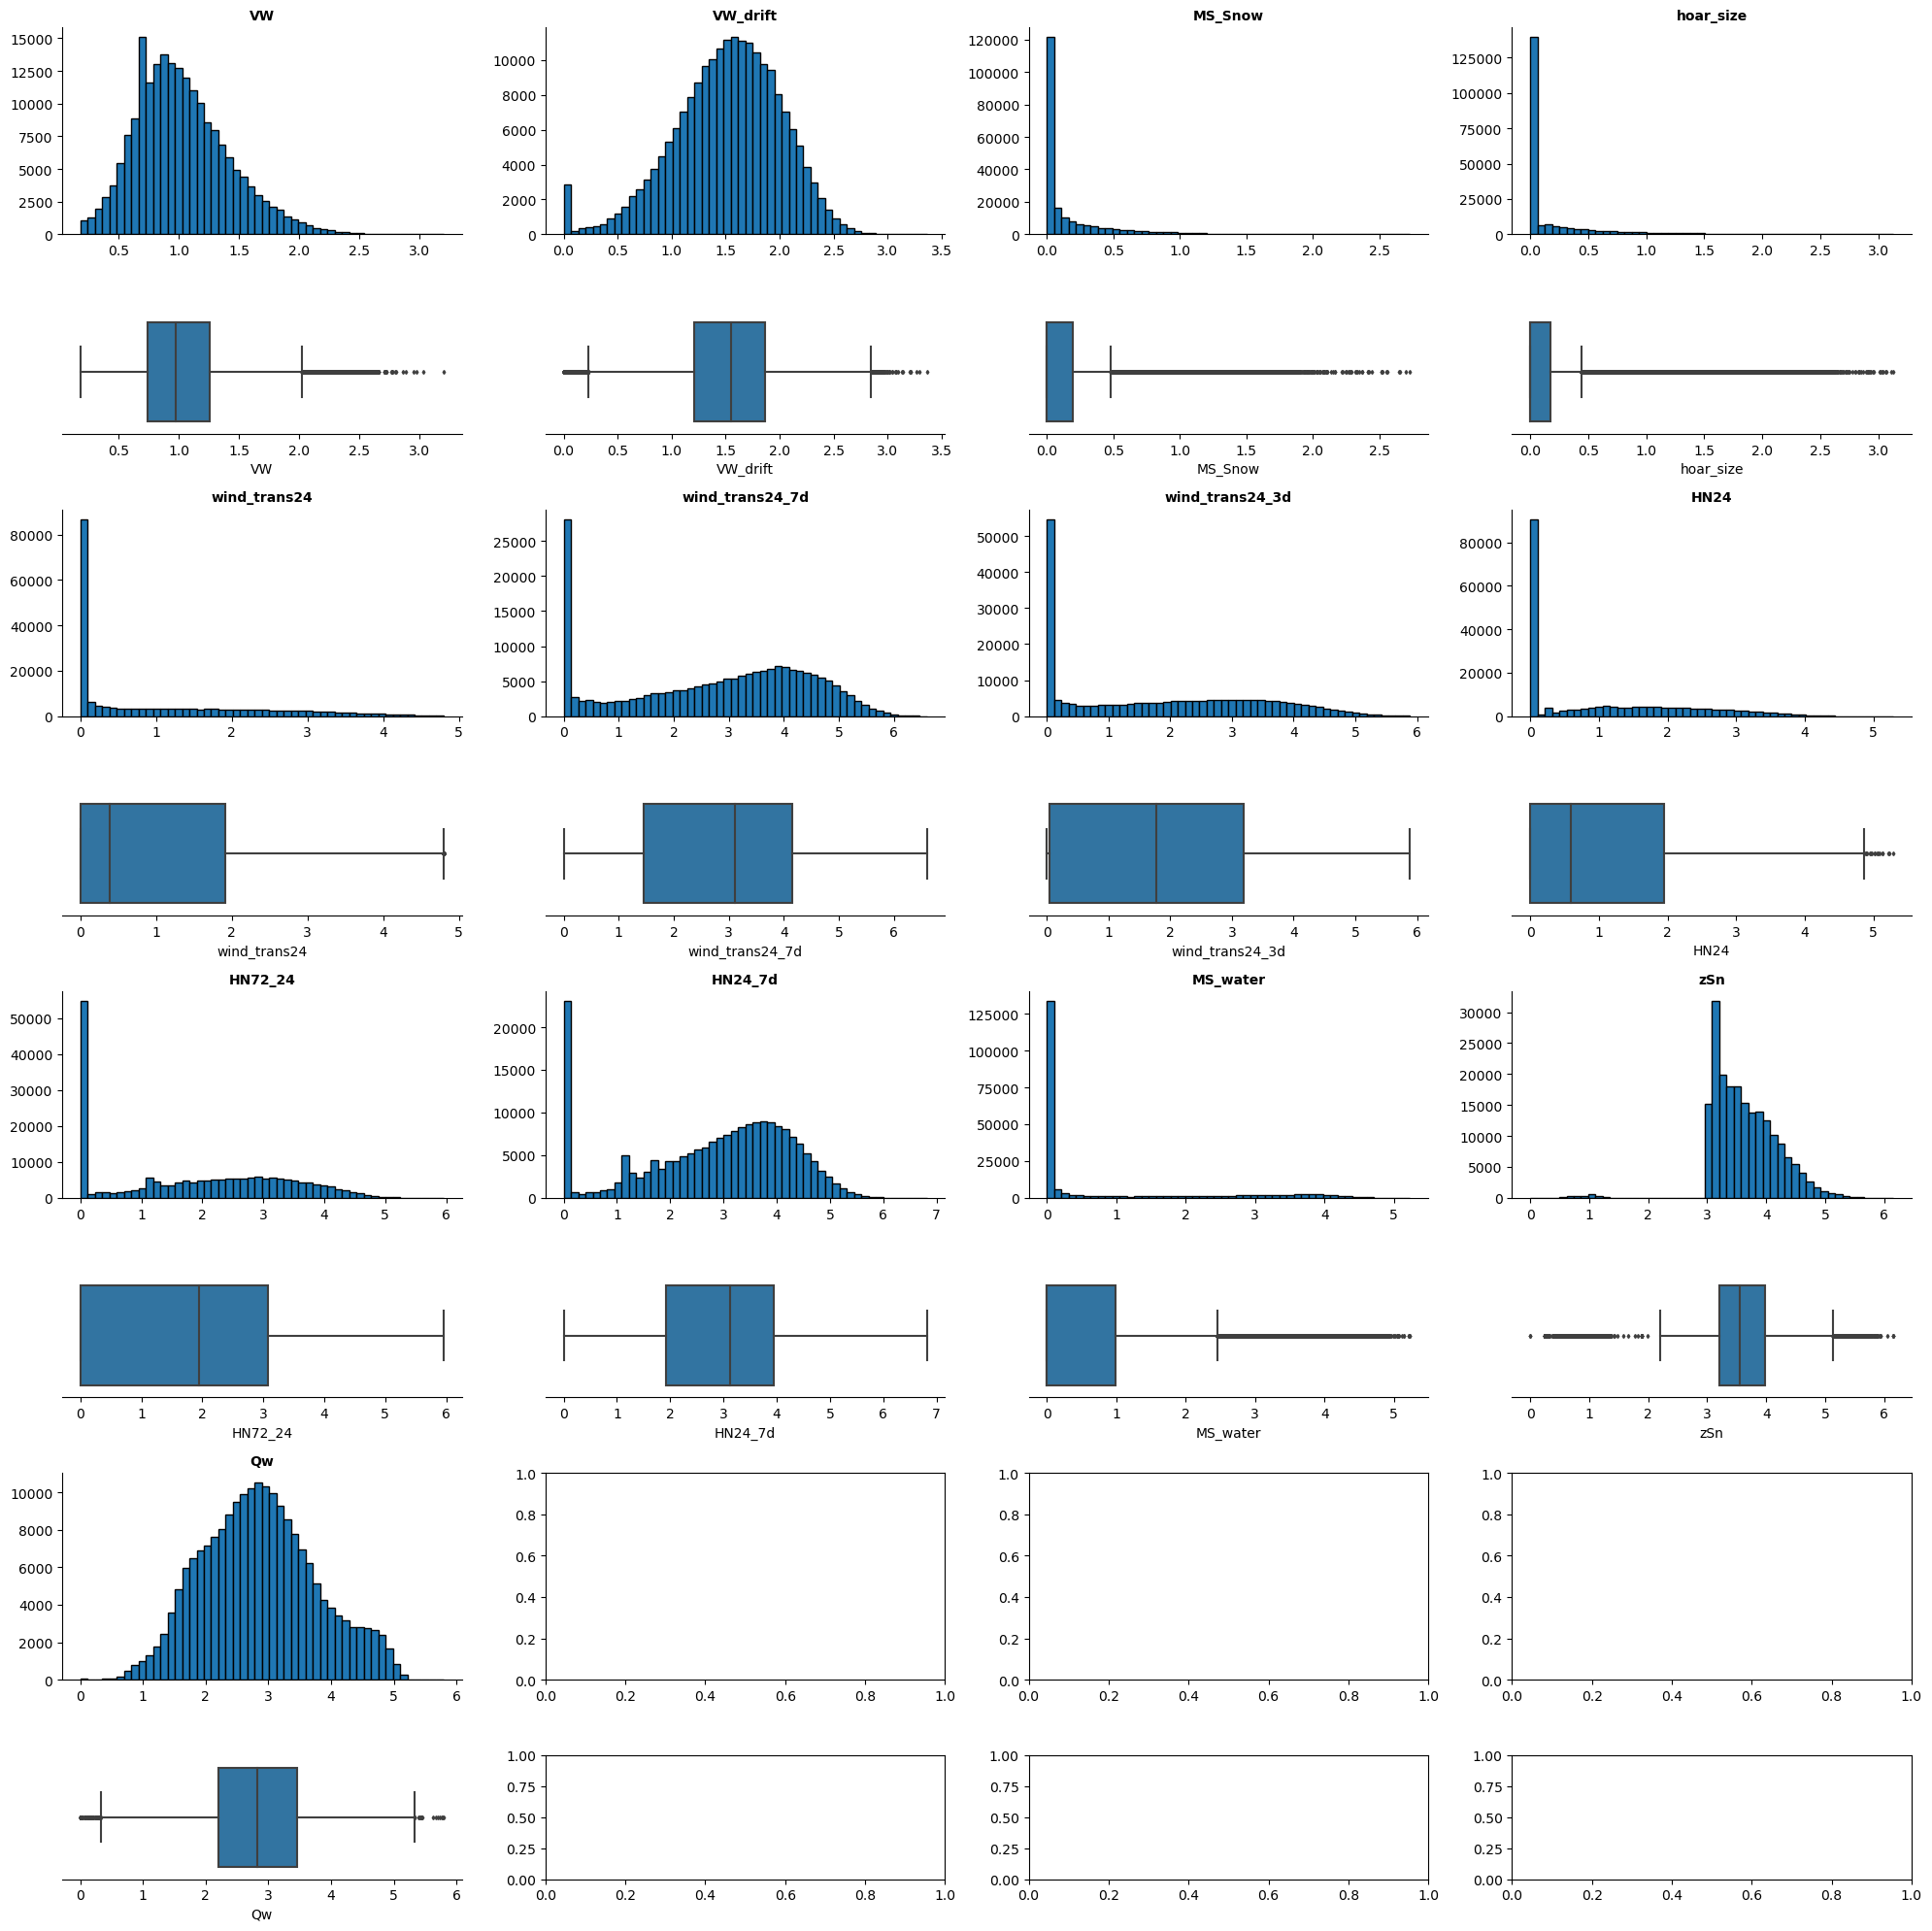

In [153]:
show_hist(data, left_skew, figsize = (20, 20), n_cols = 4, function = np.log1p)

Apart from `VW`, `zSn` and `Qw`, all distributions have a huge bar in $y=0$. Let's see what happens when we apply the same transformation on these features when their value is greater than 0.

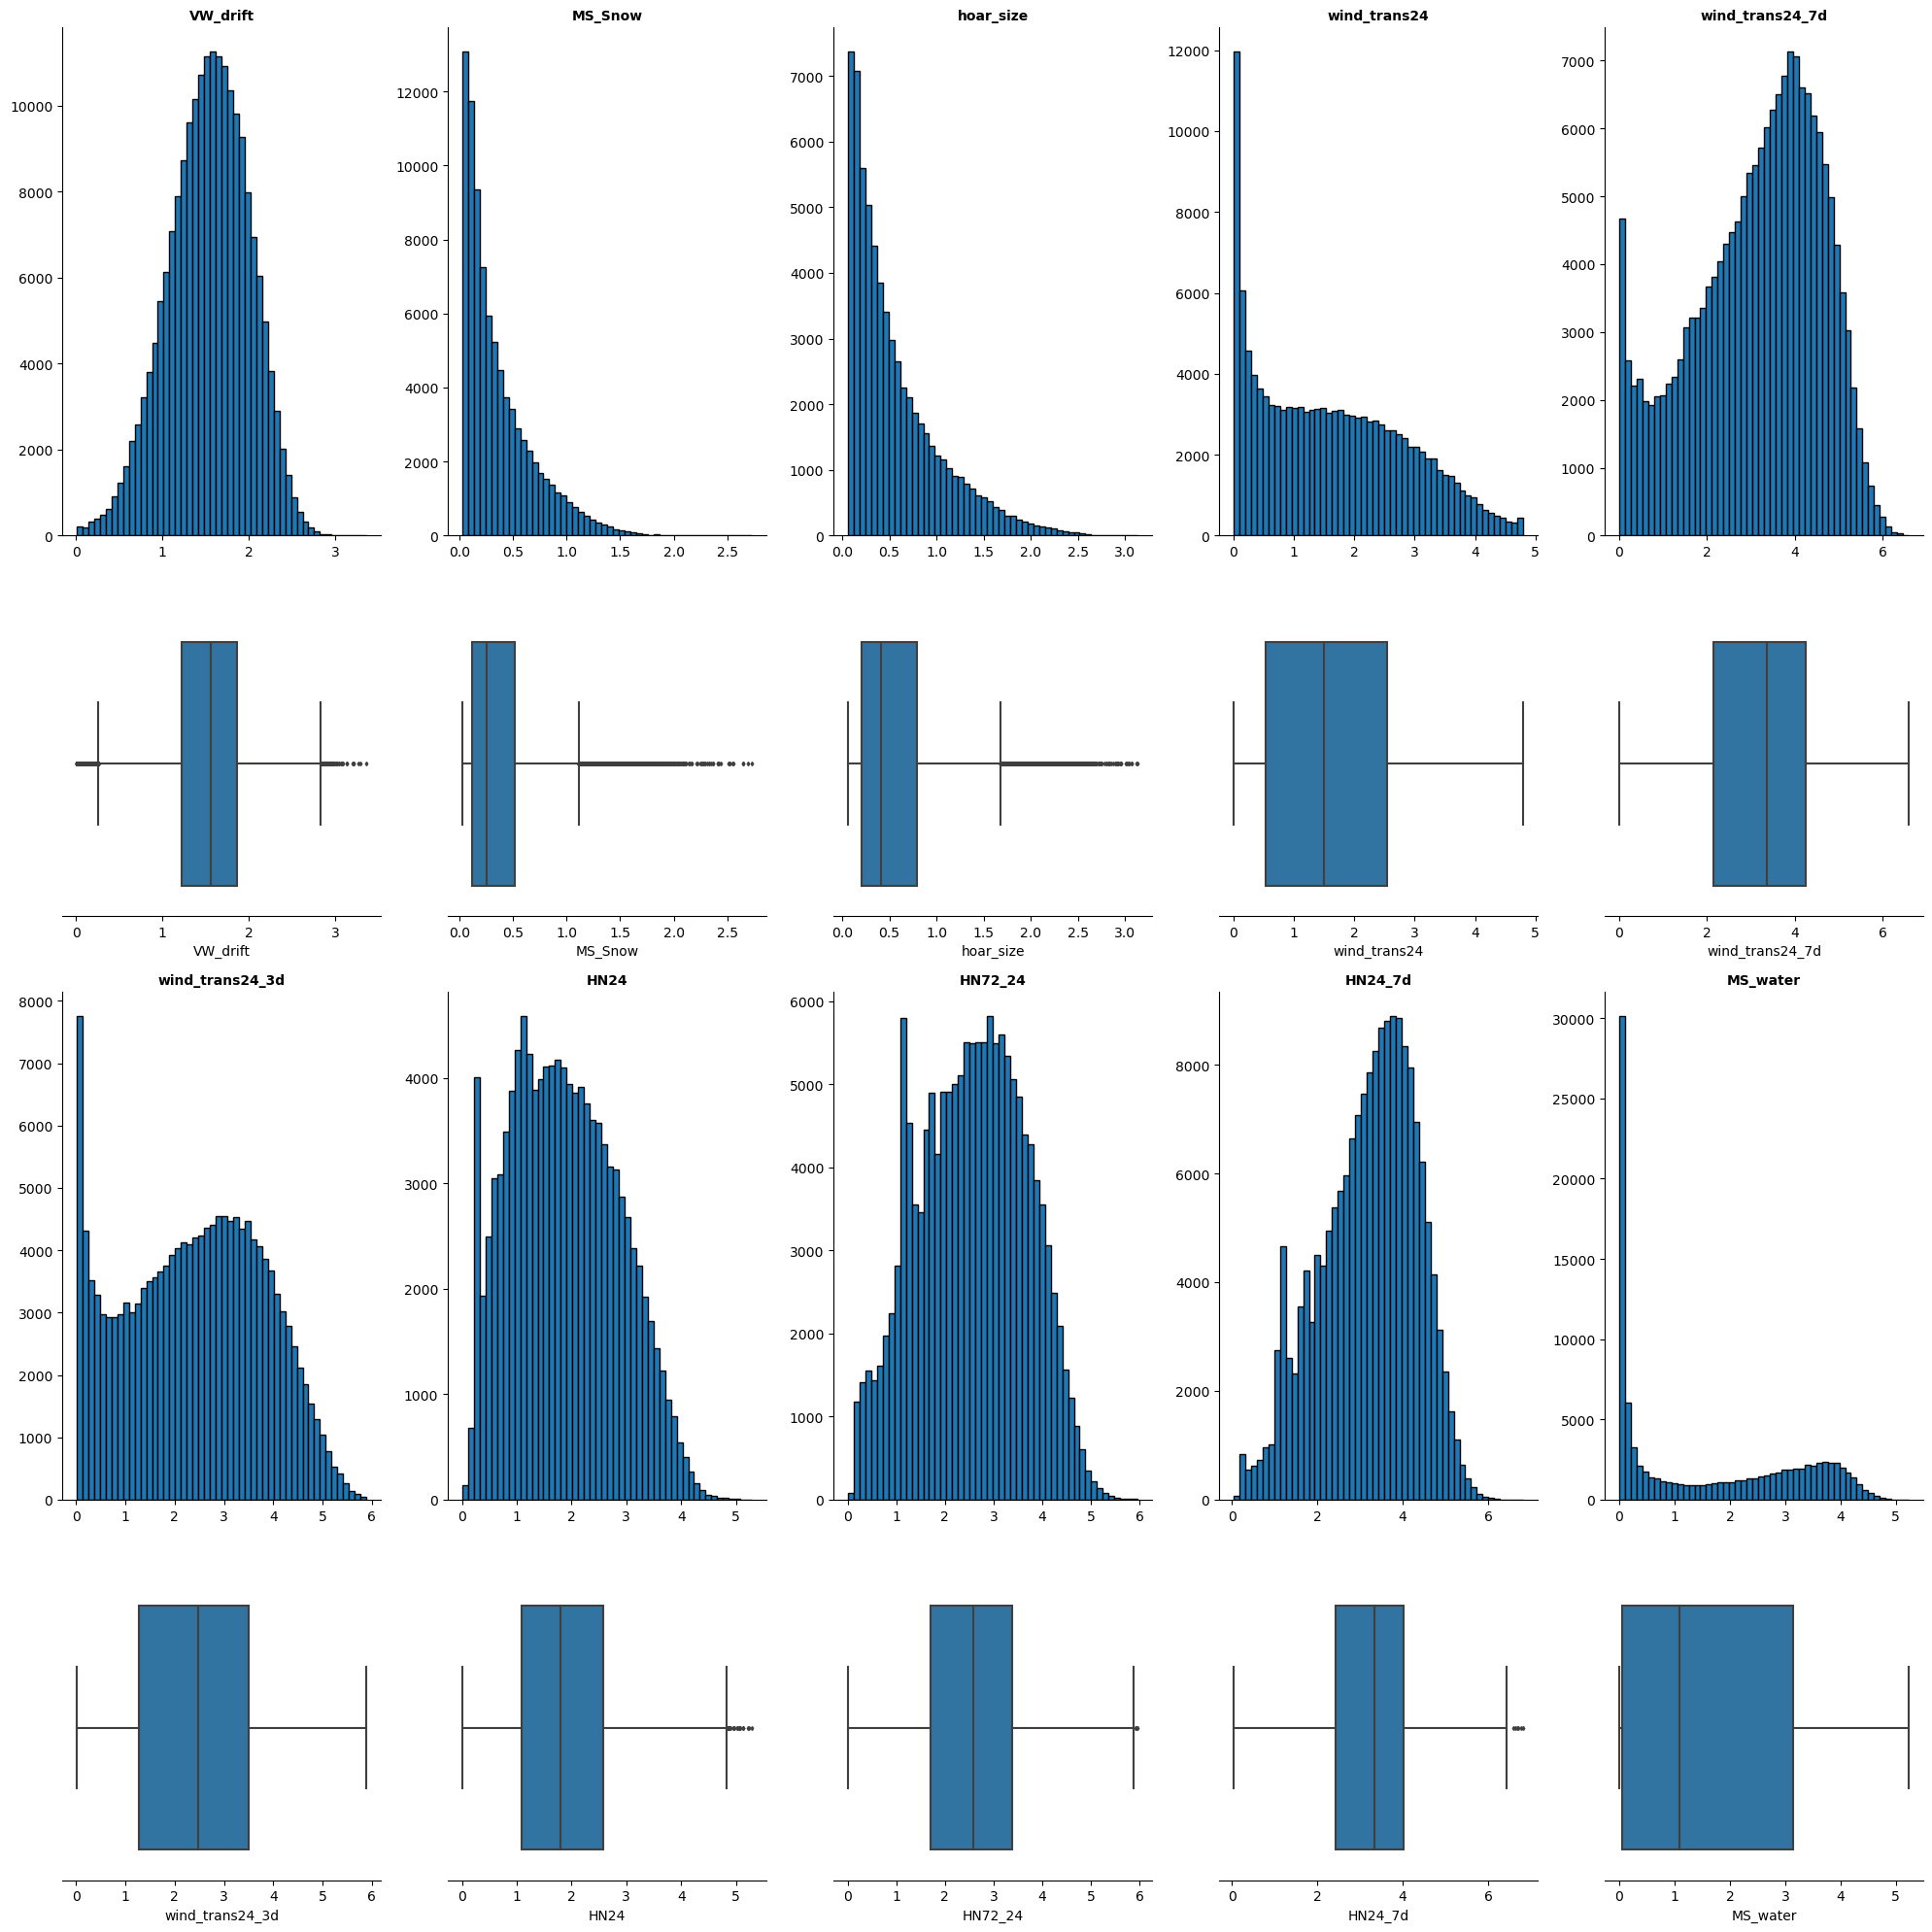

In [154]:
with_zeros = left_skew[:]
with_zeros.remove("VW")
with_zeros.remove("zSn")
with_zeros.remove("Qw")

show_hist(data, with_zeros, function = np.log1p, mask_func = lambda x: x > 0, figsize=(20,20))

We see that now `VW_drift` admits a Gaussian distribution and the ones of and `HN24` and `HN72_24` are roughly symmetrical.

We define bounds for the features from above (after the transformation $y=\log(x+1)$):

- `MS_Snow`: 2.2
- `hoar_size`: 2.5
- `wind_trans24_7d`: 6
- `HN24`: 5

The box plots of the others features don't present any obvious presence of outliers. 

For `VW` and `zSn`, we define bounds thanks to our first plot:  

- `VW`: 2.5
- `zSn`: 5.5

`Qw` doesn't seem to really have outliers, so we keep it as it is. 
For `VW_drift`, as its distribution when to values are above 0 is normal, we will apply the z-score method to remove outliers. 

We won't remove any samples yet, we will just store the bounds and the mean and standard deviation of `VW_drift`. We will remove all the outliers all at once at the end of this part. 

In [155]:
# Define the inverse transformation
def inv_func_1(x):
    return np.exp(x)-1

In [156]:
# Define the upper bounds
upper_bounds = {"MS_Snow": inv_func_1(2.2),
                "hoar_size" : inv_func_1(2.5), 
                "wind_trans24_7d" : inv_func_1(6),
                "HN24": inv_func_1(5),
                "VW": inv_func_1(2.5),
                "zSn": inv_func_1(5.5)
         }

In [157]:
mean_VW = np.log1p(data.loc[data.VW_drift > 0, "VW_drift"]).mean()
std_VW = np.log1p(data.loc[data.VW_drift > 0, "VW_drift"]).std()

#### B. 5. 2. Right-skew

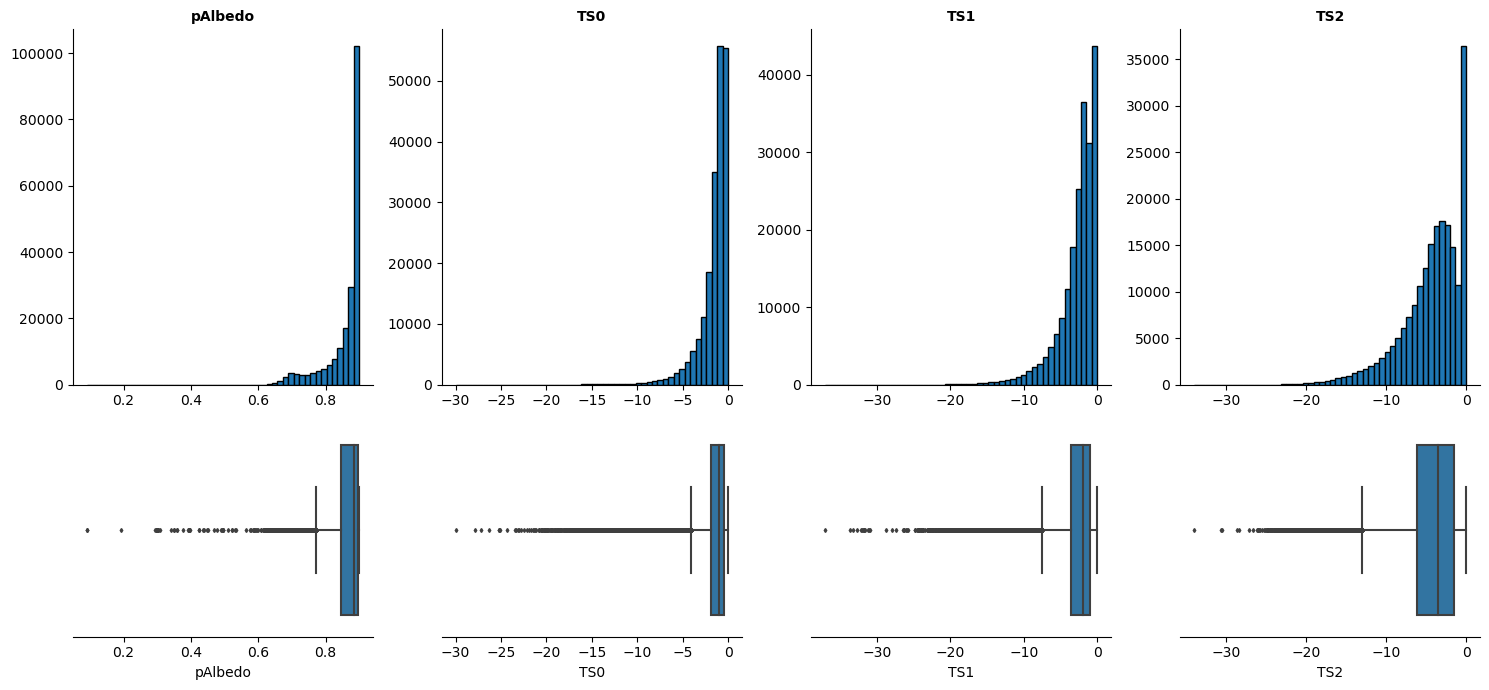

In [158]:
show_hist(data, right_skew, n_cols = 4, figsize=(15,7))

For the right-skew distribution, we apply the exact same strategy to de-skew them. To do so, we take the inversion $x \mapsto -x$ of the features, apply the transformation $y = \log(1+x)$ and then reuse the inversion $x \mapsto -x$. So overall, we look at the distributions of the variables after the transformation

$$y = -\log(1+(-x))$$

We can do so because all the values of these features are below 1.

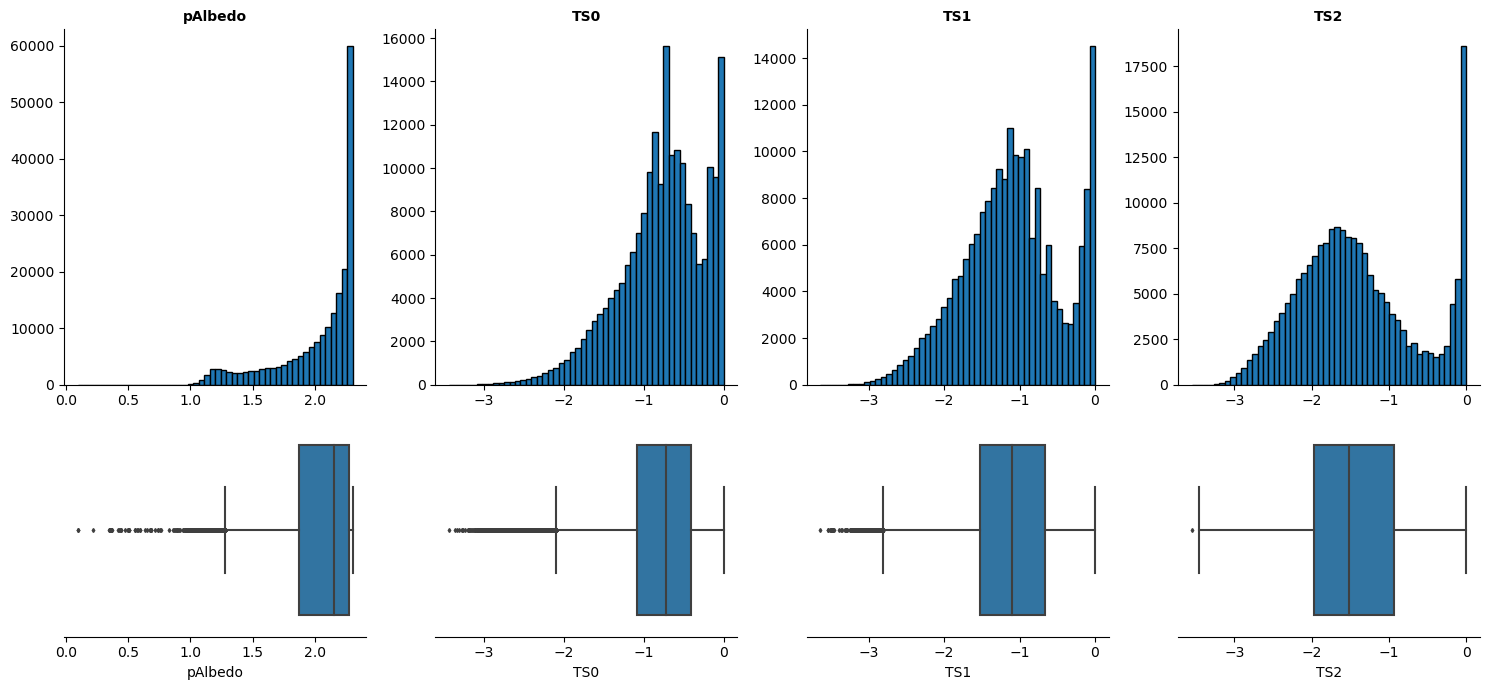

In [159]:
show_hist(data, right_skew, figsize = (15,7), n_cols = 4, function = lambda x: -np.log1p(-x))

We can't say it has changed our distributions into normal ones. We will remove manually the outliers and set the lower bounds (for the transformation version of each feature)  

- `pAlbeldo`: 1
- `TS0`: -2
- `TS1`: -3
- `TS2`: -3.5

We applied the transformation $$y = -\log(1-x)$$ which the inverse is (on our intervals) $$y = -\exp(-x)+1$$

In [160]:
def inv_func_2(x):
    return -np.exp(-x)+1

lower_bounds = {
    "pAlbedo": inv_func_2(1),
    "TS0": inv_func_2(-2.5),
    "TS1": inv_func_2(-3),
    "TS2": inv_func_2(-3.5)
               }

#### B. 5. 3. Roughly symmetrical and bell-shaped 

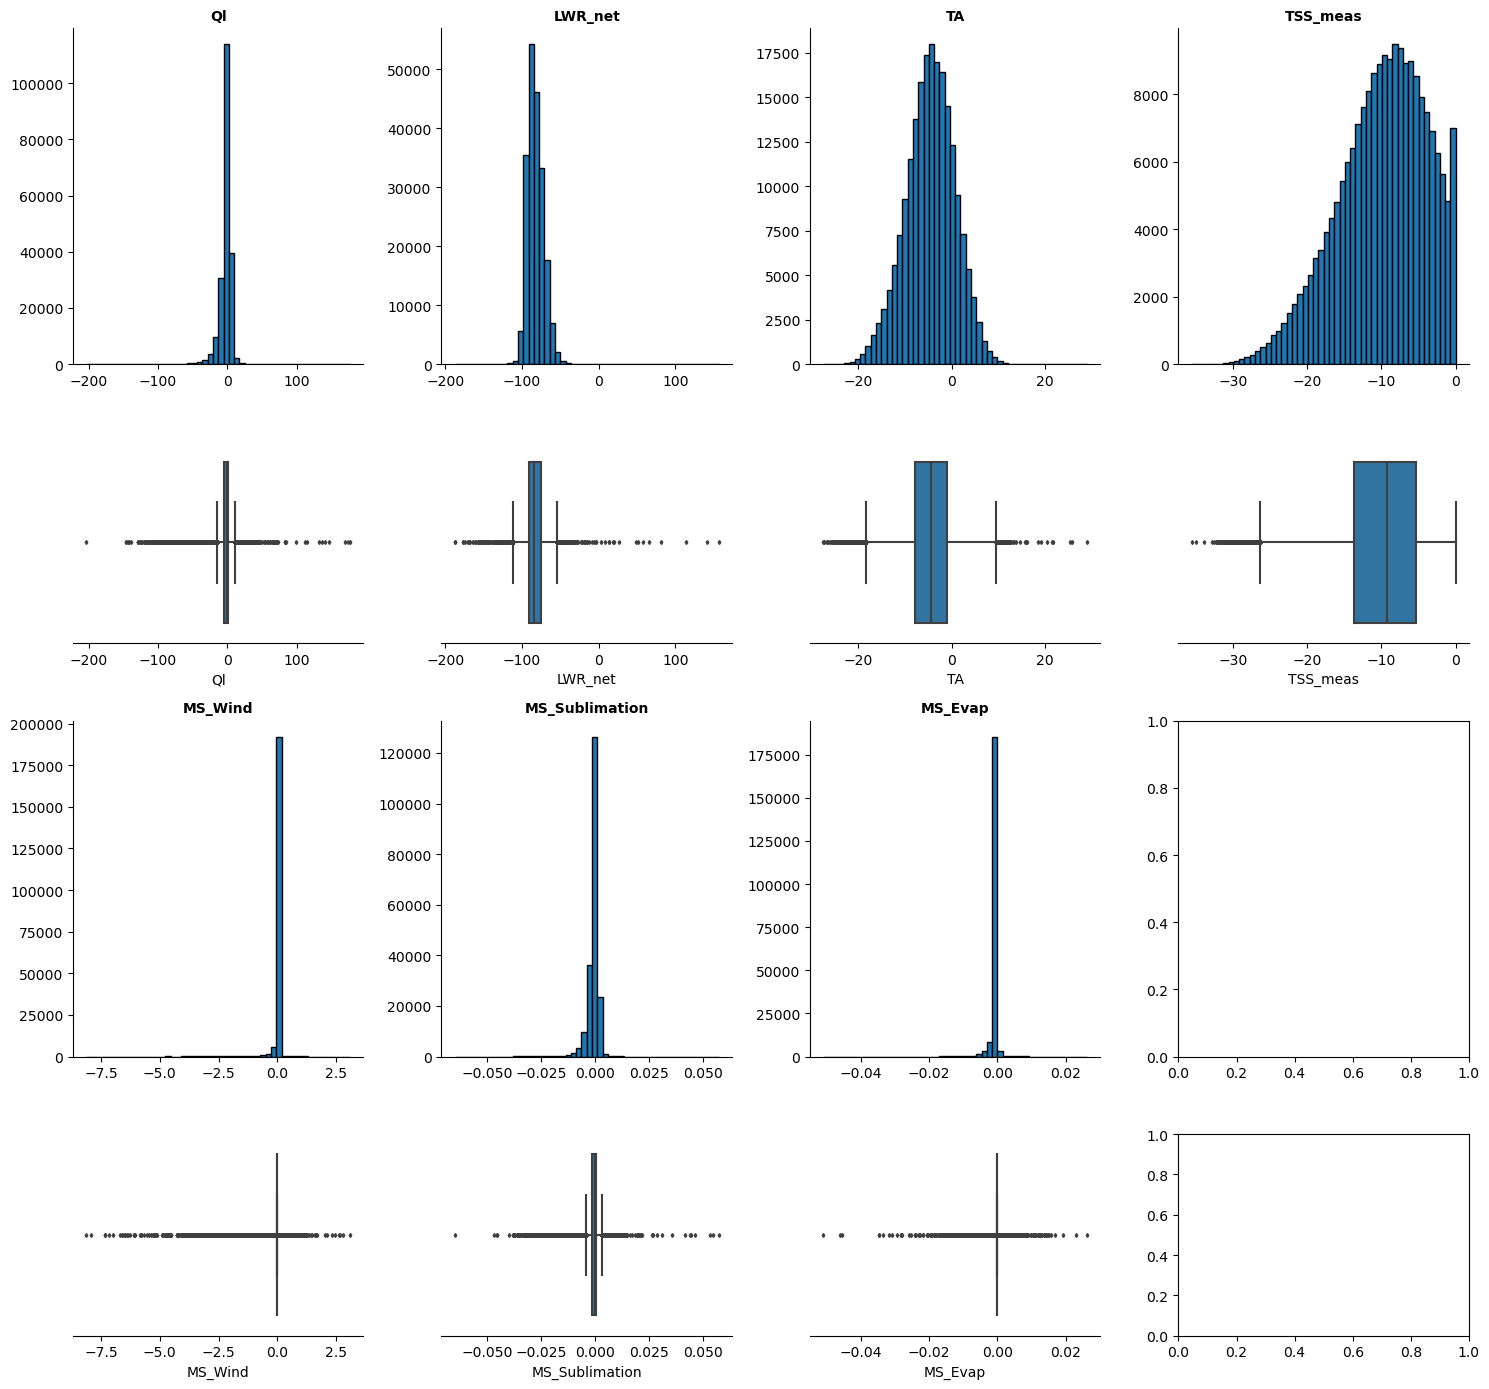

In [161]:
show_hist(data, sym_bell, figsize=(15, 14), n_cols = 4)

We see that `TA` admits a normal distribution while the one of `TSS_meas` is truncated normal. For the others, it is not really clear to know if they are symmetrical enough. Let's check their skew coefficient. 

In [162]:
data[["Ql", "LWR_net", "MS_Wind", "MS_Sublimation", "MS_Evap"]].skew()

Ql                -2.705702
LWR_net            0.640370
MS_Wind          -14.767731
MS_Sublimation    -2.836172
MS_Evap           -6.592496
dtype: float64

We can't really consider them symmetrical enough to apply the z-score method to remove their outliers. Let's check their histogram on a log scale. 

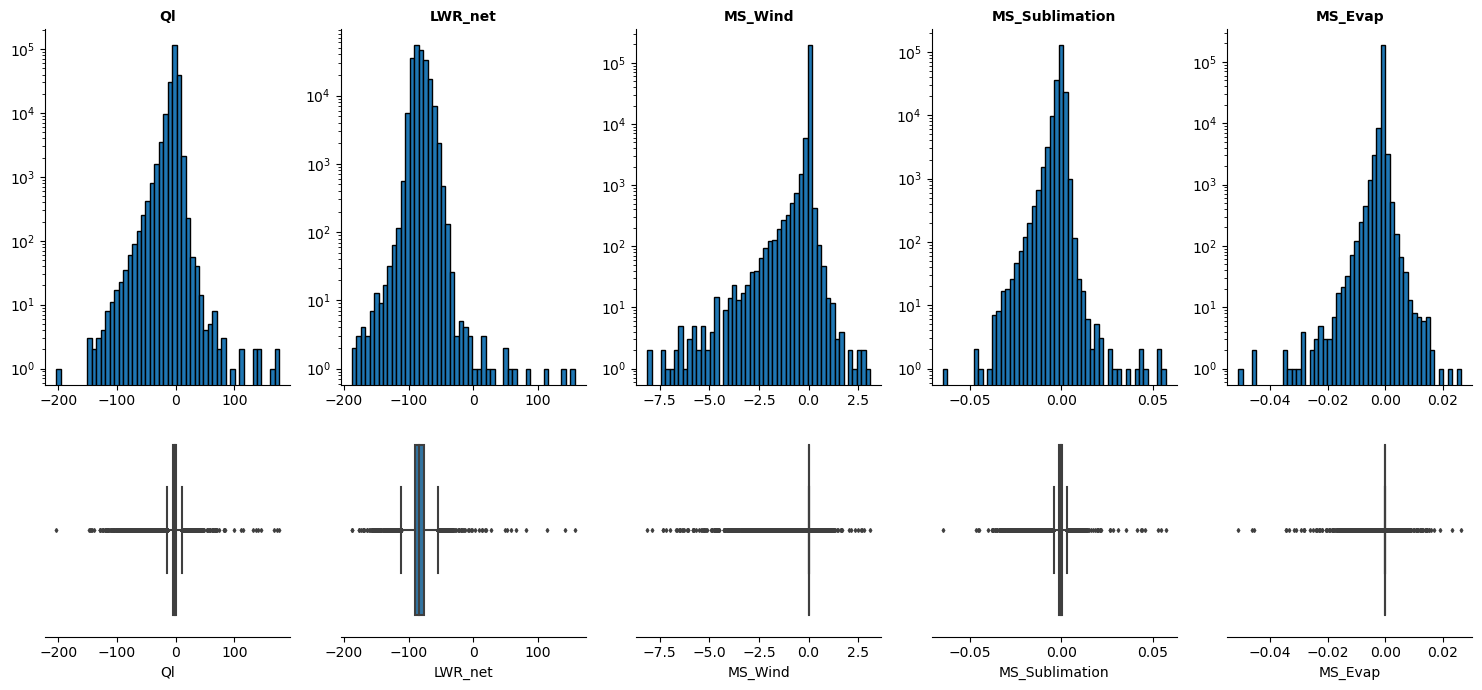

In [163]:
show_hist(data, ["Ql", "LWR_net", "MS_Wind", "MS_Sublimation", "MS_Evap"], figsize=(15,7), n_cols =5, log=True)

We define tolerance intervals: 


- `Ql`: from -100 to 100
- `LWR_Net` from -150 to 0
- `MS_Wind` from -5 to 2
- `MS_Sublimation` from -0.04 to 0.02
- `MS_Evap` from -0.02 to 0.02

For `TA`, we store its standard deviation and mean and will it apply the z-score method. 

In [164]:
bounds = {"Ql" : [-100,100],
          "LWR_net" : [-150, 0],
          "MS_Wind" : [-5,2],
          "MS_Sublimation" : [-0.04, 0.02],
          "MS_Evap" : [-0.02, 0.02]
         }

In [165]:
mean_ta = data.TA.mean()
std_ta = data.TA.std()

For `TSS_meas`, as it's distribution is truncated normal, let's look a bit closely.

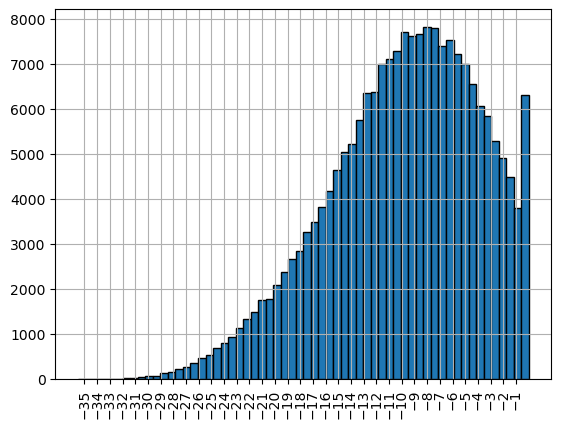

In [166]:
data.TSS_meas.hist(edgecolor = "black", bins = 60)
plt.xticks(np.arange(-35,0), rotation = 90)
plt.show()

We know that, for a symmetrical and bell-shaped distribution, removing every value that has a z-score above 3 removes around 99.7% of the samples.

`TSS_meas` looks gaussian on the left-handside. We can look at the percentage of the sample that would remain if we set each value to the left of the peak of the distribution as the lower bound (from -35 to around -8). Searching for the value that would retain 99.7% of the samples would be similar to apply the z-score to a normal distribution (only on the left-hand side of the distribution).

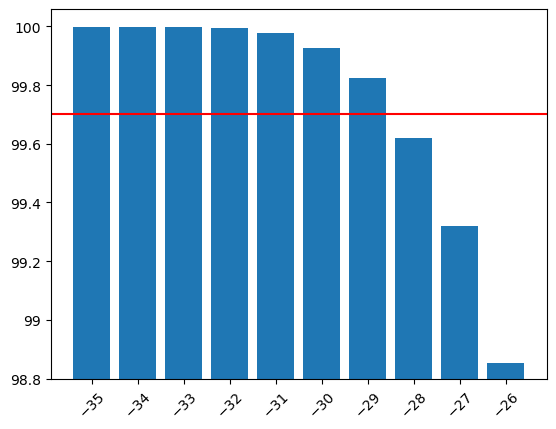

In [167]:
percentage = []

for number in np.arange(-35,-25):
    mask_1 = (data["TSS_meas"]>= number) & (data["TSS_meas"] <= -8)
    mask_2 = (data["TSS_meas"] <= -8)
    percentage.append(data[mask_1].shape[0] / data[mask_2].shape[0] *100)
    
percentage = [round(percentage[x],5) for x in range(len(percentage))]
percentage = np.array(percentage)
height = percentage - 98.8

    
plt.bar(x = np.arange(-35,-25), 
        height = height 
       )

plt.xticks(np.arange(-35,-25), rotation = 45)
plt.yticks(np.arange(0, 1.3, 0.2), labels = ["98.8", "99", "99.2", "99.4", "99.6", "99.8", "100"])
plt.axhline(y=0.9, color="r", linestyle="-")
plt.show()


The horizontal red line represents 99.7%. So, setting the lower bound at -28 will remove around 0.4% of the left hand-side of the distribution. 

In [168]:
lower_bounds["TSS_meas"] = -28

#### B. 5. 4. Others

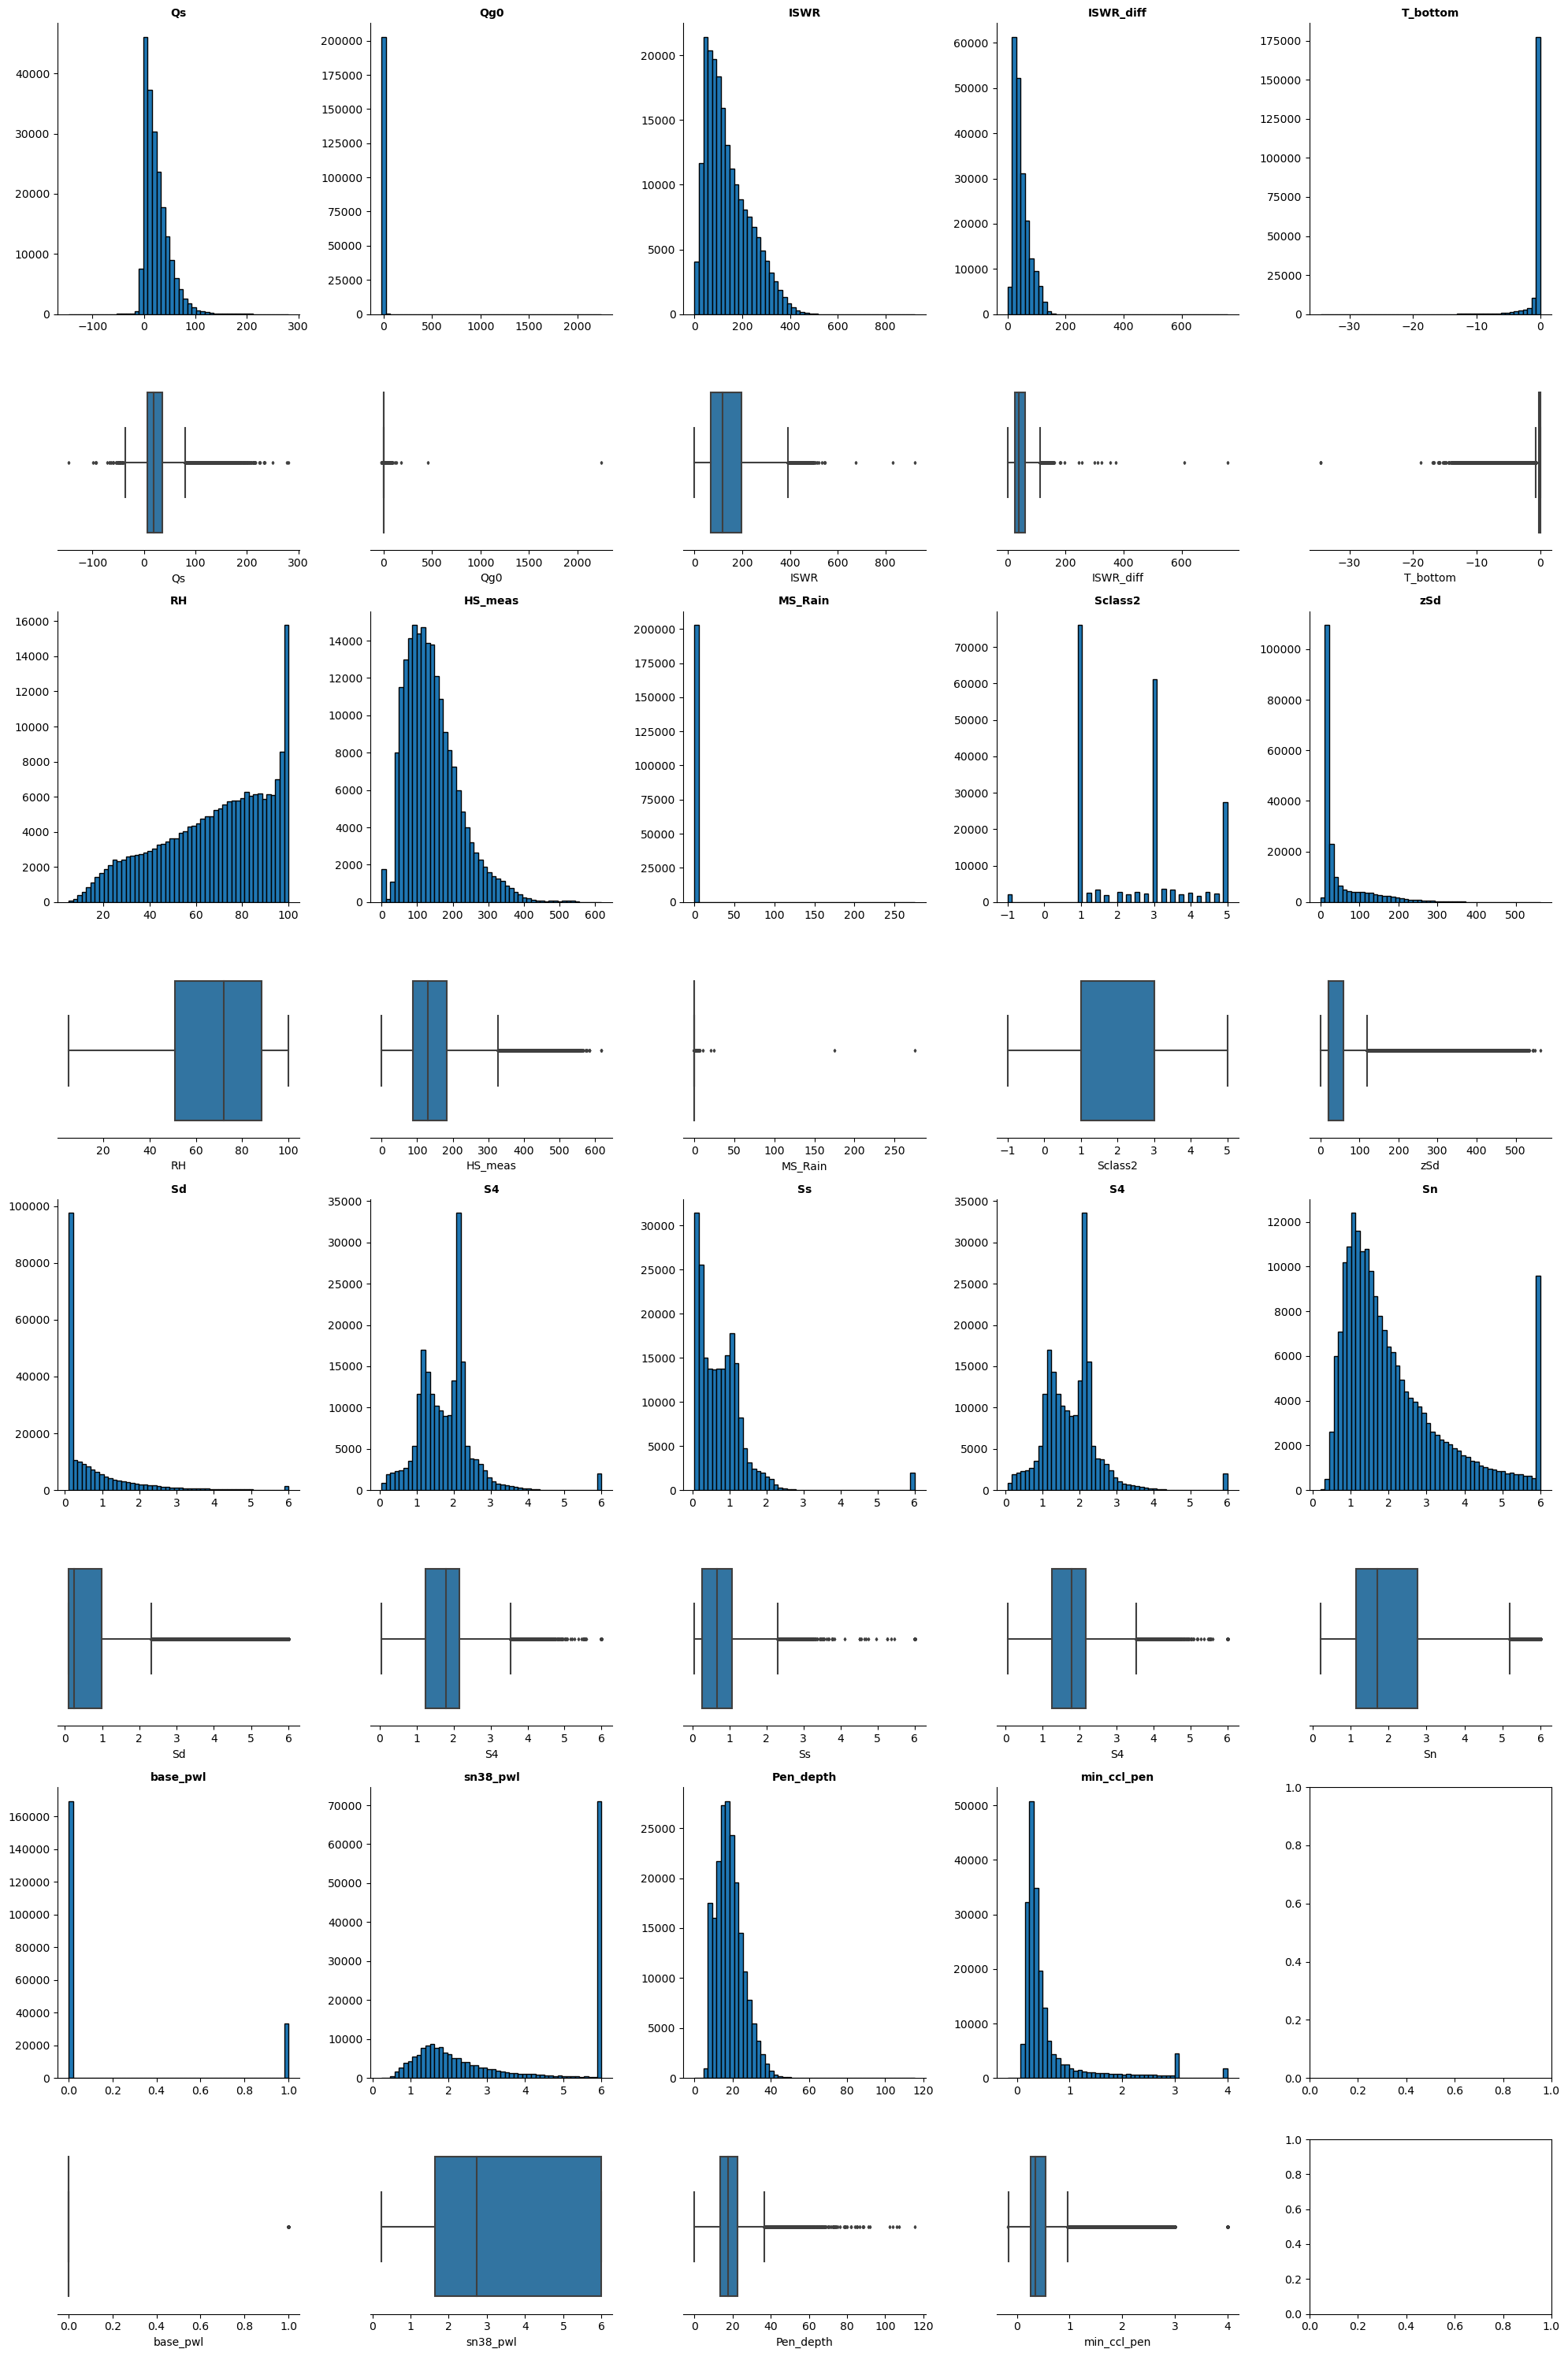

In [169]:
show_hist(data, others, figsize=(20,30))

We must be careful here because we have some features that are indices or classes such as `zSd`, `Sd`, `S4`, `Ss`, `Sn` `base_pwl`, `sn38_pwl` and `min_ccl_pen`. We decide to not touch them and define the following bounds: 

In [170]:
bounds["Qs"] = [-50, 200]
bounds["MS_Rain"] = [0, 5]

upper_bounds["Qg0"] = 100
upper_bounds["ISWR"] = 600
upper_bounds["ISWR_diff"] = 200
upper_bounds["HS_meas"] = 500
upper_bounds["zSd"] = 300
upper_bounds["Pen_depth"] = 60

lower_bounds["T_bottom"] = -13

#### B. 5. 5. Outliers removal

Let's summarize the bounds, intervals, means and standard deviation we have stored:

In [171]:
lower_bounds

{'pAlbedo': 0.6321205588285577,
 'TS0': -11.182493960703473,
 'TS1': -19.085536923187668,
 'TS2': -32.11545195869231,
 'TSS_meas': -28,
 'T_bottom': -13}

In [172]:
upper_bounds

{'MS_Snow': 8.025013499434122,
 'hoar_size': 11.182493960703473,
 'wind_trans24_7d': 402.4287934927351,
 'HN24': 147.4131591025766,
 'VW': 11.182493960703473,
 'zSn': 243.69193226422038,
 'Qg0': 100,
 'ISWR': 600,
 'ISWR_diff': 200,
 'HS_meas': 500,
 'zSd': 300,
 'Pen_depth': 60}

In [173]:
bounds

{'Ql': [-100, 100],
 'LWR_net': [-150, 0],
 'MS_Wind': [-5, 2],
 'MS_Sublimation': [-0.04, 0.02],
 'MS_Evap': [-0.02, 0.02],
 'Qs': [-50, 200],
 'MS_Rain': [0, 5]}

In [174]:
print("Mean TA: {}".format(mean_ta))
print("Std TA: {}".format(std_ta))
print("Mean VW: {}".format(mean_VW))
print("Std VW: {}".format(std_VW))

Mean TA: -4.584787849789933
Std TA: 5.239902073373888
Mean VW: 1.534704997001349
Std VW: 0.4659315290689789


We remove the outlier in one shot. We define a boolean matrix that takes value "True" if a data point is an outlier, "False" otherwise, and we remove every observations in the data set that has a least one "True" value in the boolean matrix. 

In [175]:
class OutliersRemoval:
    
    def transform(self, dataset):
        outliers_df = pd.DataFrame(index = dataset.index, 
                        columns = dataset.columns)
        
        for var in lower_bounds.keys():
            mask = dataset[var] >= lower_bounds[var]
            outliers_df[var] = mask
            
        for var in upper_bounds.keys():
            mask = dataset[var] <= upper_bounds[var]
            outliers_df[var] = mask
            
        for var in bounds.keys():
            mask = (dataset[var] >= bounds[var][0]) & (dataset[var] <= bounds[var][1])
            outliers_df[var] = mask
        
        # Outliers for VW 
        zscores_VW = np.log1p(data.loc[data.VW_drift > 0, "VW_drift"]) - mean_VW / std_VW
        z_filter_VW = np.abs(zscores_VW) > 3
        outliers_df["VW_drift"] = ~z_filter_VW 
        
        # Outliers for TA
        zscores_ta = (data.TA - mean_ta) / std_ta
        zfilter_ta = np.abs(zscores_ta) > 3 # Without taking the absolute value
        outliers_df["TA"] = ~zfilter_ta
        
        # Fill all the remaining NaN values with True
        outliers_df.fillna(True, inplace=True) 

        #Take the index of the outlier data
        idx_outliers = outliers_df.all(axis=1)[outliers_df.all(axis=1) == False].index 

        # Drop the outliers
        dataset.drop(idx_outliers, axis = 0, inplace=True)

        # Reset the index
        dataset.reset_index(inplace=True, drop = True)    

Before removing the outliers, we removed already around 17% of observations. 

In [176]:
rows_deleted()

Number of rows beginning: 244327

Number of rows now: 202902

Since the beginning we have deleted: 41425 rows representing 16.955%


In [177]:
outliers_removal = OutliersRemoval()

outliers_removal.transform(data)

Now let's see what was the cost after removing the ouliers. 

In [178]:
rows_deleted()

Number of rows beginning: 244327

Number of rows now: 196862

Since the beginning we have deleted: 47465 rows representing 19.427%


These operations have removed around 2.5% of the data. Which is acceptable.

### B. 6. Removing variables with variance close to 0

Let's check if some variables have their variance close to 0. 

In [179]:
# Table with the features with the closest variance to 0
data.var(numeric_only = True).sort_values(ascending = True)[:10]

MS_Evap           0.000001
MS_Sublimation    0.000006
pAlbedo           0.003140
MS_Rain           0.007766
MS_Wind           0.027763
base_pwl          0.137911
MS_Snow           0.234143
min_ccl_pen       0.454446
Ss                0.481394
S4                0.556826
dtype: float64

`MS_Evap`, `MS_Sublimation`, `pAlbedo`, `MS_Rain` and `MS_Wind` have very low variances. We can check their statistics and histograms. 

In [180]:
data[["MS_Evap", "MS_Sublimation", "pAlbedo", "MS_Rain", "MS_Wind"]].describe().T.drop("count", axis=1)

mean       std       min       25%       50%     75%  \
MS_Evap        -0.000282  0.001012 -0.019625  0.000000  0.000000  0.0000   
MS_Sublimation -0.000740  0.002388 -0.037750 -0.001375 -0.000125  0.0005   
pAlbedo         0.859240  0.056040  0.632125  0.846750  0.884000  0.8970   
MS_Rain         0.013115  0.088122  0.000000  0.000000  0.000000  0.0000   
MS_Wind        -0.019797  0.166621 -4.913250  0.000000  0.000000  0.0000   

                     max  
MS_Evap         0.019125  
MS_Sublimation  0.019625  
pAlbedo         0.900000  
MS_Rain         4.394875  
MS_Wind         1.642125

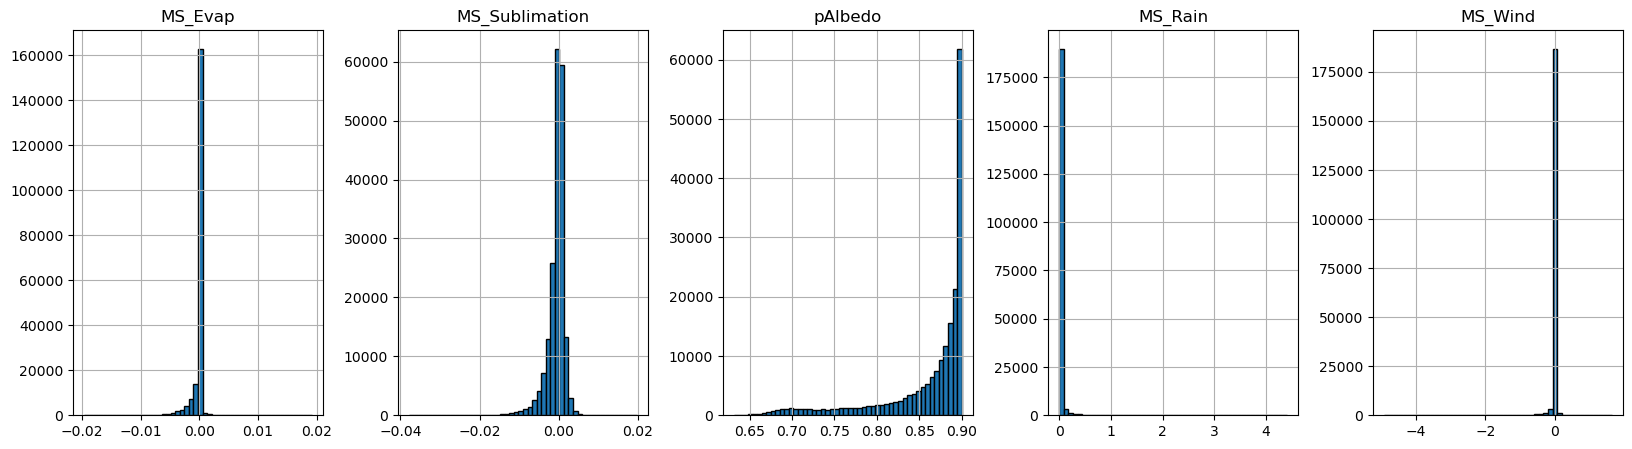

In [181]:
data[["MS_Evap", "MS_Sublimation", "pAlbedo", "MS_Rain", "MS_Wind"]].hist(bins = 50,
                                                                          edgecolor = "black",
                                                                          figsize = (20,5),
                                                                          layout = (1,5))

plt.show()

Let's check their correlation coefficient with `dangerLevel`.

In [182]:
data.corr().loc["dangerLevel", ["MS_Evap", "MS_Sublimation", "pAlbedo", "MS_Rain", "MS_Wind"]]

MS_Evap           0.175252
MS_Sublimation    0.052141
pAlbedo           0.468567
MS_Rain           0.010761
MS_Wind          -0.092183
Name: dangerLevel, dtype: float64

We decide to remove these features except `pAlbedo` that seems informative.

In [183]:
class RemoveLowVariance:
    
    def transform(self, dataset):
        dataset.drop(["MS_Evap", "MS_Sublimation", "MS_Rain", "MS_Wind"], axis = 1, inplace=True)
        
rlw = RemoveLowVariance()
rlw.transform(data)

In [184]:
diff_col()

Since the beginning:

Columns deleted: ['TSG', 'ccl_pwl_100', 'MS_SN_Runoff', 'sn38_pwl_100', 'ccl_pwl', 'sk38_pwl_100', 'ssi_pwl', 'S5', 'ISWR_h', 'ILWR', 'HS_mod', 'MS_Wind', 'SWE', 'ssi_pwl_100', 'zSs', 'MS_Rain', 'MS_Sublimation', 'Qr', 'zS4', 'pwl_100', 'sk38_pwl', 'OSWR', 'TSS_mod', 'MS_Evap', 'OLWR', 'DW', 'pwl_100_15', 'ISWR_dir']
Number of columns deleted: 28

Columns added: []
Number of columns added: 0


The shape of our data is:

In [185]:
data.shape

(196862, 45)

### B. 7. Time series aspect of some features

First, as we said, `warnreg` refers to a classifications in Switzerland in regions that depends on the time. Let's check the correlation between `warnreg` and the year in `datum`. 

In [186]:
round(data.datum.dt.year.corr(other=data.warnreg.astype(int)),3)

0.909

We will decide whether keep `datum` for our models (and if so how to encode it)  or not later. But since `warnreg` depends mainly on `datum`,  we decide to remove it anyway.

In [187]:
class Drop2:
    def transform(self, dataset):
        dataset.drop("warnreg", axis = 1, inplace=True)

In [188]:
drop_warnreg = Drop2()

drop_warnreg.transform(data)

Now, our Machine Learning models only accept numerical columns. For the moment, `datum` is encoded as a date within Pandas. To handle this, we could split every value in `datum` and create `year`, `month` and `day` variables. It would not make a lot of sense to use `year` and `day` for our models because `dangerLevel` and the meteorological features don't rely on which year or which day the observation was made. On the contrary, keeping `month` would make sense since as the season progress and the more we get close to spring, the behaviour of meteorological features evolves and have consequences on the avalanche danger level. 

We would like to see the behaviour of some features throughout the seasons. To do so, we create two new variables: `season` and `month`. For the first one, we take the same value as the year in `datum` and add 1 if the month in `datum` is either October, November or December. For the second, we encode with 1, 2 , 3,..., 7 the month of October, November, Decembrer, January, ..., May. 

This way, October will always be the beginning of the season and May the end of it.

In [189]:
class DatesEncoding:
    
    def transform(self, dataset):
        dataset["month"] = dataset.datum.dt.month
        dataset["year"] = dataset.datum.dt.year
        dataset["season"] = dataset.year.copy()

        mask = dataset["month"] >= 10

        dataset.loc[mask, "season"] = dataset.loc[mask, "season"] + 1 
        
        dataset.month.replace({10:1, 11:2, 12:3, 1:4, 2:5, 3:6, 4:7, 5:8}, inplace = True)

        dataset.drop(["datum", "year"], axis=1, inplace=True)

In [190]:
dates_encoding = DatesEncoding()
dates_encoding.transform(data)

In [191]:
diff_col()

Since the beginning:

Columns deleted: ['TSG', 'ccl_pwl_100', 'MS_SN_Runoff', 'sn38_pwl_100', 'datum', 'ccl_pwl', 'sk38_pwl_100', 'ssi_pwl', 'S5', 'ISWR_h', 'ILWR', 'HS_mod', 'MS_Wind', 'SWE', 'ssi_pwl_100', 'zSs', 'MS_Rain', 'MS_Sublimation', 'Qr', 'zS4', 'pwl_100', 'sk38_pwl', 'OSWR', 'TSS_mod', 'MS_Evap', 'OLWR', 'DW', 'warnreg', 'pwl_100_15', 'ISWR_dir']
Number of columns deleted: 30

Columns added: ['season', 'month']
Number of columns added: 2


We now can explore the behaviour of some variables against the months and the season. We choose only a few ones: `dangerLevel`, `elevation_th`, `ISWR`, `TA`, `RH`, `HS_meas`, `HN24_7d`. We recall the definition of the last 5. 



In [192]:
meta_data[meta_data["Feature name"].isin(["ISWR", "TA", "RH", "HS_meas", "HN24_7d"])]

Feature description Feature name       Type
9      Incoming short-wave radiation [W m−2]         ISWR   Modelled
15                      Air temperature [∘C]           TA   Measured
19                     Relative humidity [–]           RH   Measured
25                          Snow height [cm]      HS_meas   Measured
32  7 d sum of daily height of new snow [cm]      HN24_7d  Extracted

We would like to see as we said the behaviour of these features against the seasons. Let see what we get when grouping our data by `season` and `month` (in this order) and averaging.

In [193]:
# A table with all the means for every month
data.groupby(["season", "month"]).mean().copy().head()

elevation_station  dangerLevel  elevation_th         Qs  \
season month                                                            
1998   2            2473.039216     1.450980   2217.647059  27.908811   
       3            2380.445969     2.818182   2096.740995  22.023183   
       4            2348.809524     2.257937   2004.100529  37.031814   
       5            2352.861446     1.272590   2018.975904  41.640835   
       6            2359.498681     1.720317   2035.356201  24.622042   

                    Ql       Qg0    LWR_net        ISWR         Qw   pAlbedo  \
season month                                                                   
1998   2     -2.913836  2.585061 -83.085385   71.913898   9.500908  0.884760   
       3     -0.654172  1.636264 -82.869400   53.983639   6.738260  0.888984   
       4     -2.522009  1.736912 -78.883853   80.602214  11.913577  0.874973   
       5     -5.251881  1.644869 -75.528156  135.222515  23.601372  0.855885   
       6     -4.968096  0.928393 -83.753757  191.475506  34.210032  0.860607   

              ...        zSd        Sd        zSn        Sn        Ss  \
season month  ...                                                       
1998   2      ...  19.763985  2.031752  25.776842  3.663743  0.827864   
       3      ...  20.945080  1.528697  35.371333  2.423163  0.669162   
       4      ...  20.201365  1.261592  39.694268  2.141052  0.670370   
       5      ...  27.097076  1.055471  32.969032  2.102219  0.842448   
       6      ...  38.127464  0.653217  34.298753  2.145906  0.908201   

                    S4  base_pwl  sn38_pwl  Pen_depth  min_ccl_pen  
season month                                                        
1998   2      2.486565  0.544118  3.690931  19.516235     0.743676  
       3      1.913649  0.670669  2.435197  24.939011     0.370755  
       4      1.850265  0.530423  2.447765  21.561299     0.418399  
       5      1.793314  0.506024  2.242380  15.851034     0.532485  
       6      1.583003  0.303430  2.741900  17.835358     0.572823  

[5 rows x 41 columns]

The question now is, are all the months between October of the 1998 season until May of the 2017 season present in this table ?

In [194]:
# Building a table with all the means for every month
seasons = data.groupby(["season", "month"]).mean().copy()
seasons.reset_index(inplace = True)
seasons.head()

season  month  elevation_station  dangerLevel  elevation_th         Qs  \
0    1998      2        2473.039216     1.450980   2217.647059  27.908811   
1    1998      3        2380.445969     2.818182   2096.740995  22.023183   
2    1998      4        2348.809524     2.257937   2004.100529  37.031814   
3    1998      5        2352.861446     1.272590   2018.975904  41.640835   
4    1998      6        2359.498681     1.720317   2035.356201  24.622042   

         Ql       Qg0    LWR_net        ISWR  ...        zSd        Sd  \
0 -2.913836  2.585061 -83.085385   71.913898  ...  19.763985  2.031752   
1 -0.654172  1.636264 -82.869400   53.983639  ...  20.945080  1.528697   
2 -2.522009  1.736912 -78.883853   80.602214  ...  20.201365  1.261592   
3 -5.251881  1.644869 -75.528156  135.222515  ...  27.097076  1.055471   
4 -4.968096  0.928393 -83.753757  191.475506  ...  38.127464  0.653217   

         zSn        Sn        Ss        S4  base_pwl  sn38_pwl  Pen_depth  \
0  25.776842  3.663743  0.827864  2.486565  0.544118  3.690931  19.516235   
1  35.371333  2.423163  0.669162  1.913649  0.670669  2.435197  24.939011   
2  39.694268  2.141052  0.670370  1.850265  0.530423  2.447765  21.561299   
3  32.969032  2.102219  0.842448  1.793314  0.506024  2.242380  15.851034   
4  34.298753  2.145906  0.908201  1.583003  0.303430  2.741900  17.835358   

   min_ccl_pen  
0     0.743676  
1     0.370755  
2     0.418399  
3     0.532485  
4     0.572823  

[5 rows x 43 columns]

In [195]:
# Count the number of time each month appears in our table
seasons["month"].value_counts()

3    20
4    20
5    20
6    20
7    20
8    18
2    17
1     2
Name: month, dtype: int64

Between season 1998 and season 2017, there are 20 seasons. Then we can see that the value 1 for `month`, corresponding to the month of October, appears only two times. For visualizing and relevance purposes, we remove the observations recorded in October (because we don't have enough observations to make it relevant).

We can also see that there are 2 and 3 times for which the means for May and November respectively are missing but this is not a big deal to make our visualization relevant. 

In [196]:
seasons = seasons[seasons["month"] != 1]
seasons.reset_index(drop = True, inplace = True)
seasons.head()

season  month  elevation_station  dangerLevel  elevation_th         Qs  \
0    1998      2        2473.039216     1.450980   2217.647059  27.908811   
1    1998      3        2380.445969     2.818182   2096.740995  22.023183   
2    1998      4        2348.809524     2.257937   2004.100529  37.031814   
3    1998      5        2352.861446     1.272590   2018.975904  41.640835   
4    1998      6        2359.498681     1.720317   2035.356201  24.622042   

         Ql       Qg0    LWR_net        ISWR  ...        zSd        Sd  \
0 -2.913836  2.585061 -83.085385   71.913898  ...  19.763985  2.031752   
1 -0.654172  1.636264 -82.869400   53.983639  ...  20.945080  1.528697   
2 -2.522009  1.736912 -78.883853   80.602214  ...  20.201365  1.261592   
3 -5.251881  1.644869 -75.528156  135.222515  ...  27.097076  1.055471   
4 -4.968096  0.928393 -83.753757  191.475506  ...  38.127464  0.653217   

         zSn        Sn        Ss        S4  base_pwl  sn38_pwl  Pen_depth  \
0  25.776842  3.663743  0.827864  2.486565  0.544118  3.690931  19.516235   
1  35.371333  2.423163  0.669162  1.913649  0.670669  2.435197  24.939011   
2  39.694268  2.141052  0.670370  1.850265  0.530423  2.447765  21.561299   
3  32.969032  2.102219  0.842448  1.793314  0.506024  2.242380  15.851034   
4  34.298753  2.145906  0.908201  1.583003  0.303430  2.741900  17.835358   

   min_ccl_pen  
0     0.743676  
1     0.370755  
2     0.418399  
3     0.532485  
4     0.572823  

[5 rows x 43 columns]

How many months are present in this table now ? 

In [197]:
seasons.shape[0]

135

Now that we know that there are 135 months, of this number how many months do the stations appear?

In [198]:
data[data["month"]!= 1][["station_code", "month", "season"]].drop_duplicates().groupby("station_code").count()

month  season
station_code               
ALI2             66      66
AMD2             90      90
ANV2            128     128
ANV3            120     120
ARO2            120     120
...             ...     ...
WFJ2            111     111
YBR2             59      59
ZER2            122     122
ZER4             73      73
ZNZ2             89      89

[122 rows x 2 columns]

For consistency, we keep only the stations that appear at least 120 times. 

In [199]:
month_counted = data[data["month"]!= 1][["station_code", "month", "season"]].drop_duplicates().groupby("station_code").count()
month_counted[month_counted["month"]>120]

month  season
station_code               
ANV2            128     128
BEV2            125     125
CHA2            123     123
FAE2            122     122
FIS2            128     128
KES2            124     124
KLO3            127     127
MEI2            125     125
SCH2            123     123
TRU2            124     124
TUJ2            124     124
TUJ3            126     126
URS2            123     123
ZER2            122     122

In [200]:
# Taking the stations that appear at least 120 times
stations_complete = month_counted[month_counted["month"]>120].index.to_list()

# Building a table with all the means for every month, with only the most represented stations, and without the month of october
seasons_2 = data[(data["station_code"].isin(stations_complete)) & (data.month !=1)].groupby(["season", "month"]).mean().copy()
seasons_2.reset_index(inplace = True)
seasons_2

season  month  elevation_station  dangerLevel  elevation_th         Qs  \
0      1998      2        2456.164384     1.383562   2245.205479  37.866687   
1      1998      3        2358.391608     2.835664   2090.909091  27.860552   
2      1998      4        2331.767956     2.243094   1994.475138  42.785287   
3      1998      5        2339.622642     1.245283   2022.012579  48.040193   
4      1998      6        2340.056022     1.803922   2031.372549  28.620704   
..      ...    ...                ...          ...           ...        ...   
129    2017      4        2370.655271     2.470085   2058.974359  31.927353   
130    2017      5        2368.900804     2.517426   2065.415550  28.721606   
131    2017      6        2384.699454     2.401639   2028.142077  24.097819   
132    2017      7        2366.011236     1.620787   2078.651685  15.708745   
133    2017      8        2407.042254     2.605634   2211.267606   6.505769   

           Ql       Qg0    LWR_net        ISWR  ...         zSd        Sd  \
0    0.768635  2.642955 -75.190801   74.394795  ...   19.248784  1.979173   
1    0.817903  1.543457 -78.888244   55.984390  ...   20.463924  1.211230   
2   -1.834443  1.497998 -75.185065   86.328148  ...   20.445831  0.913918   
3   -3.577898  1.413437 -71.545601  144.098209  ...   25.277154  0.760076   
4   -2.516293  0.665909 -80.260432  195.396382  ...   40.933236  0.260925   
..        ...       ...        ...         ...  ...         ...       ...   
129 -1.905054  2.804879 -81.644663   83.649567  ...   20.906185  2.230918   
130 -2.853419  0.930106 -81.443502  130.037148  ...   30.435697  0.600409   
131 -5.599635  0.439650 -83.357960  205.024252  ...   85.078099  0.185239   
132 -4.854821  0.077381 -84.886748  271.374328  ...  106.603148  0.104321   
133 -2.160544  0.020269 -87.859616  279.881695  ...  129.302715  0.100000   

           zSn        Sn        Ss        S4  base_pwl  sn38_pwl  Pen_depth  \
0    24.039702  3.855947  0.706485  2.514704  0.684932  3.706712  20.001885   
1    31.848705  2.293281  0.553544  1.889730  0.737762  2.491923  25.584518   
2    40.185346  1.924982  0.515866  1.775535  0.441989  2.408343  21.819576   
3    33.278925  1.791668  0.670310  1.599949  0.452830  1.901604  16.717963   
4    36.706651  1.654140  0.708472  1.269047  0.198880  2.450812  19.317057   
..         ...       ...       ...       ...       ...       ...        ...   
129  36.642741  3.227168  0.550770  1.812166  0.273504  3.560399  20.978142   
130  39.692497  2.006302  0.896182  1.480297  0.262735  2.984611  19.889500   
131  44.378581  1.539055  0.997177  1.716781  0.106557  2.832213  16.581145   
132  48.669762  3.289932  0.929137  2.150696  0.005618  5.512135  11.587426   
133  54.935092  3.118775  0.930394  1.657507  0.000000  5.599014  14.769892   

     min_ccl_pen  
0       0.704384  
1       0.267098  
2       0.307099  
3       0.363711  
4       0.364314  
..           ...  
129     0.383675  
130     0.356139  
131     0.737295  
132     1.464438  
133     0.603099  

[134 rows x 43 columns]

For our first visualization, we want to plot every feature against every month of every season making the first data point of a new season having the same x-coordinates than the data point of the previous season. To do this, we need to create another variable that we will call `x_plot` that is close to being the index of `seasons_2` but the last month of season $n$ has same value than the first month of season $n+1$. 

In [201]:
# Take all the indices of the observations per season individually
blocks = [seasons_2[seasons_2.season == y].index.to_list() for y in seasons_2.season.unique()]

# Starting our new index by taking the same indices than the first block
idx_plot = [blocks[0]]    

# For every block after the first one, take the original indices of the current block and compute their the difference
# between the new indices of the previous block and shift the the indices of the current block according to it
for block in range(1,len(blocks)):
    old_idx = blocks[block]
    previous_new_idx = idx_plot[block-1]
    
    difference = old_idx[0]-previous_new_idx[-1]
    new_idx = np.array(old_idx) - difference
    new_idx = list(new_idx)
    
    idx_plot.append(new_idx)
    
# Transform a list of list into a list
from itertools import chain

idx_plot = list(chain.from_iterable(idx_plot))

# Create the new column
seasons_2["x_plot"] = idx_plot

In [202]:
seasons_2.loc[:10, ["season", "month", "x_plot"]]

season  month  x_plot
0     1998      2       0
1     1998      3       1
2     1998      4       2
3     1998      5       3
4     1998      6       4
5     1998      7       5
6     1998      8       6
7     1999      2       6
8     1999      3       7
9     1999      4       8
10    1999      5       9

You can see that the last month of 1998 and the first of 1999 share the same value in `x_plot`. Now let's just store the indices of the new seasons.

In [203]:
# Take the index when a new season starts
new_season = []

for idx in seasons_2.index[:-1]:
    
    if seasons_2.loc[idx+1, "season"] == seasons_2.loc[idx, "season"]+1:
        position = seasons_2.loc[idx, "x_plot"]
        new_season.append(position)

Now we are ready the make our first visualization.

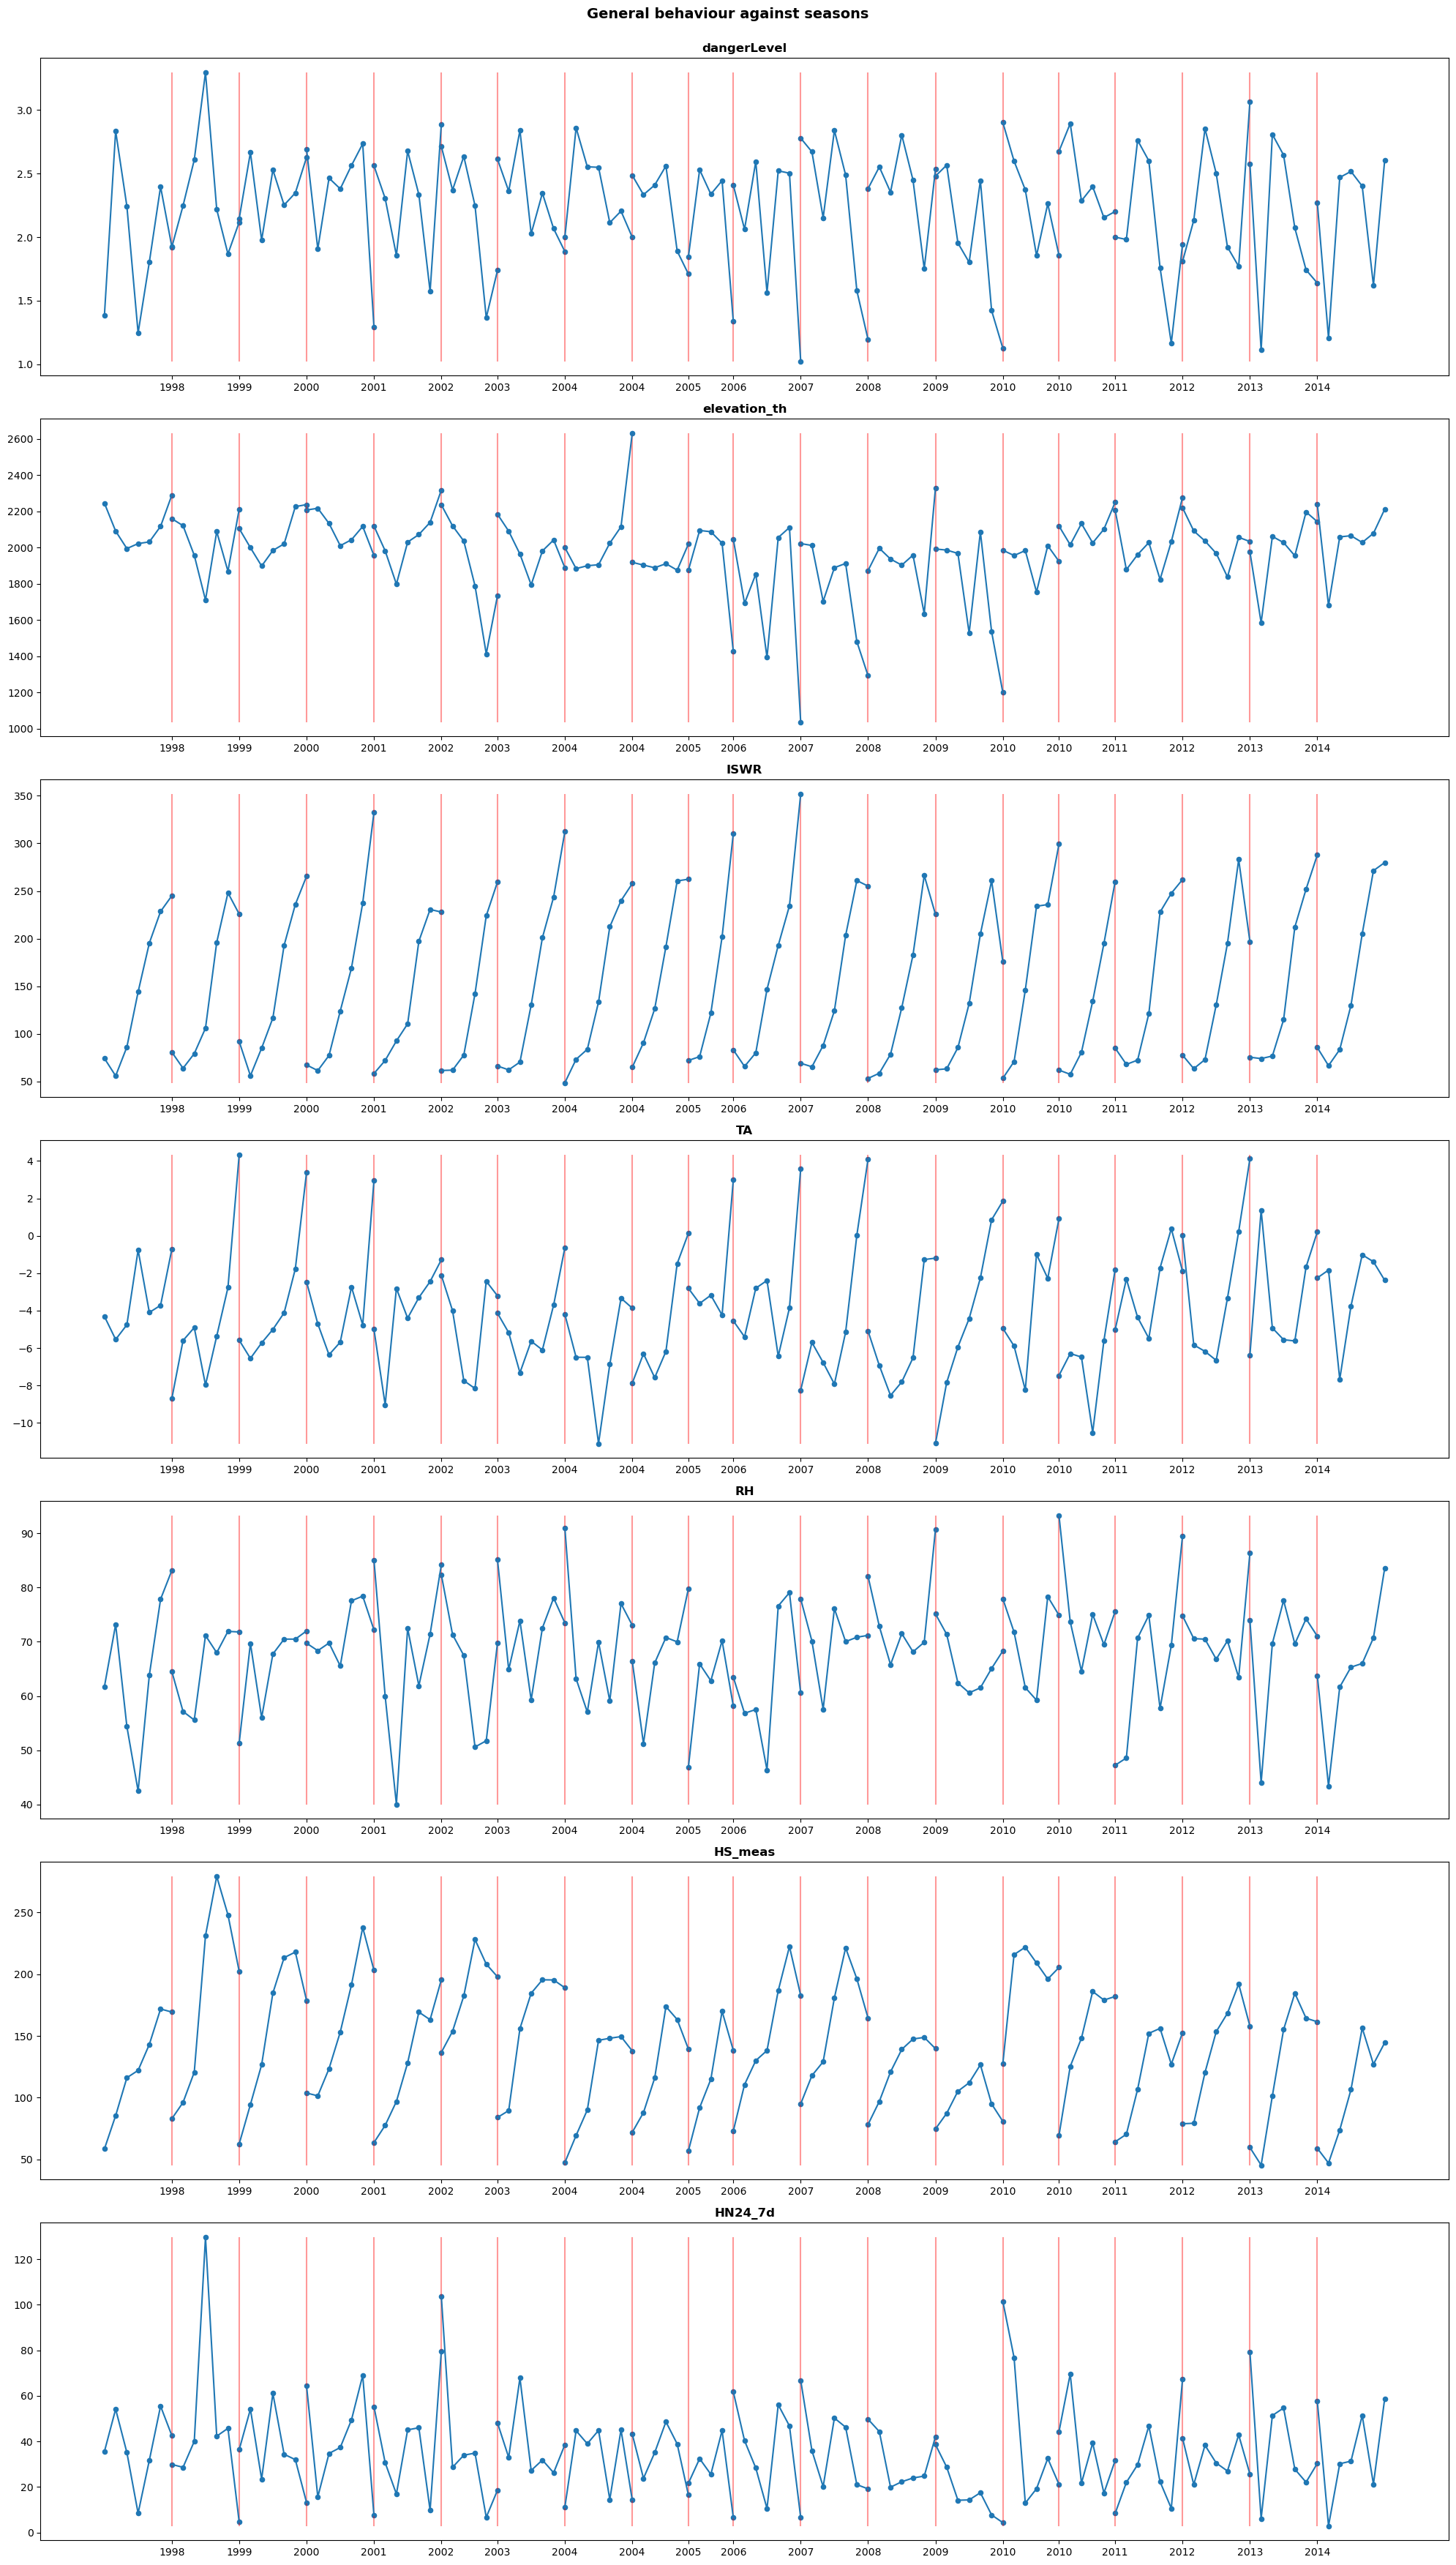

In [204]:
cols = ["dangerLevel", "elevation_th", "ISWR", "TA", "RH", "HS_meas", "HN24_7d"]

fig, axes = plt.subplots(nrows = len(cols), ncols = 1, figsize =(20, 5* len(cols)))

for ax, col in zip(axes.flatten(), cols):
    
    for season in seasons_2.season.unique():
        
        mask = seasons_2.season == season
        
        ax.plot(seasons_2.loc[mask , "x_plot"],
                seasons_2.loc[mask, col],
                color = "tab:blue")
        ax.scatter(x = seasons_2.loc[mask, "x_plot"],
                   y = seasons_2.loc[mask,col],
                   color = "tab:blue",
                   s = 20)
                   
    ax.vlines(new_season, ymin = seasons_2[col].min(), ymax = seasons_2[col].max(), color = "r", alpha = 0.4)
    ax.set_title(col, fontsize = 12, fontweight = "bold")
    ax.set_xticks(new_season)
    ax.set_xticklabels(list(seasons.loc[new_season, "season"].values))

plt.suptitle("General behaviour against seasons", y=1, fontsize = 14, fontweight = "extra bold")
plt.tight_layout()
plt.show()


This figure shows the following: 

- Every point is the monthly mean of all values of a feature recorded by the stations we have selected previously
- The first point of a given season generally corresponds to the month of November and the last one to May
- The last point of season $n$ lies on the same axis than the first point of season $n+1$

We can see some interesting patterns:
    
- even if the trend of `dangerLevel` is not really clear, we can still see that the minimum in average of the danger level lies most of the time in the second part of the season (in March or April or May).
- `elevation_th` tends to increase at the end of the seasons (because the snow cover is higher in altitude)
- the incoming short-wave radiation `ISWR` and the air temperature `TA`, as expected, increase throughout the season.
- the snow height `MS_Snow` has its maximum almost always in April (the penultimate point of each season). 

To get maybe better insights of the tendency of the features against the month of the season, we average all the values of each features acoording to each month without regardind the seasons. 

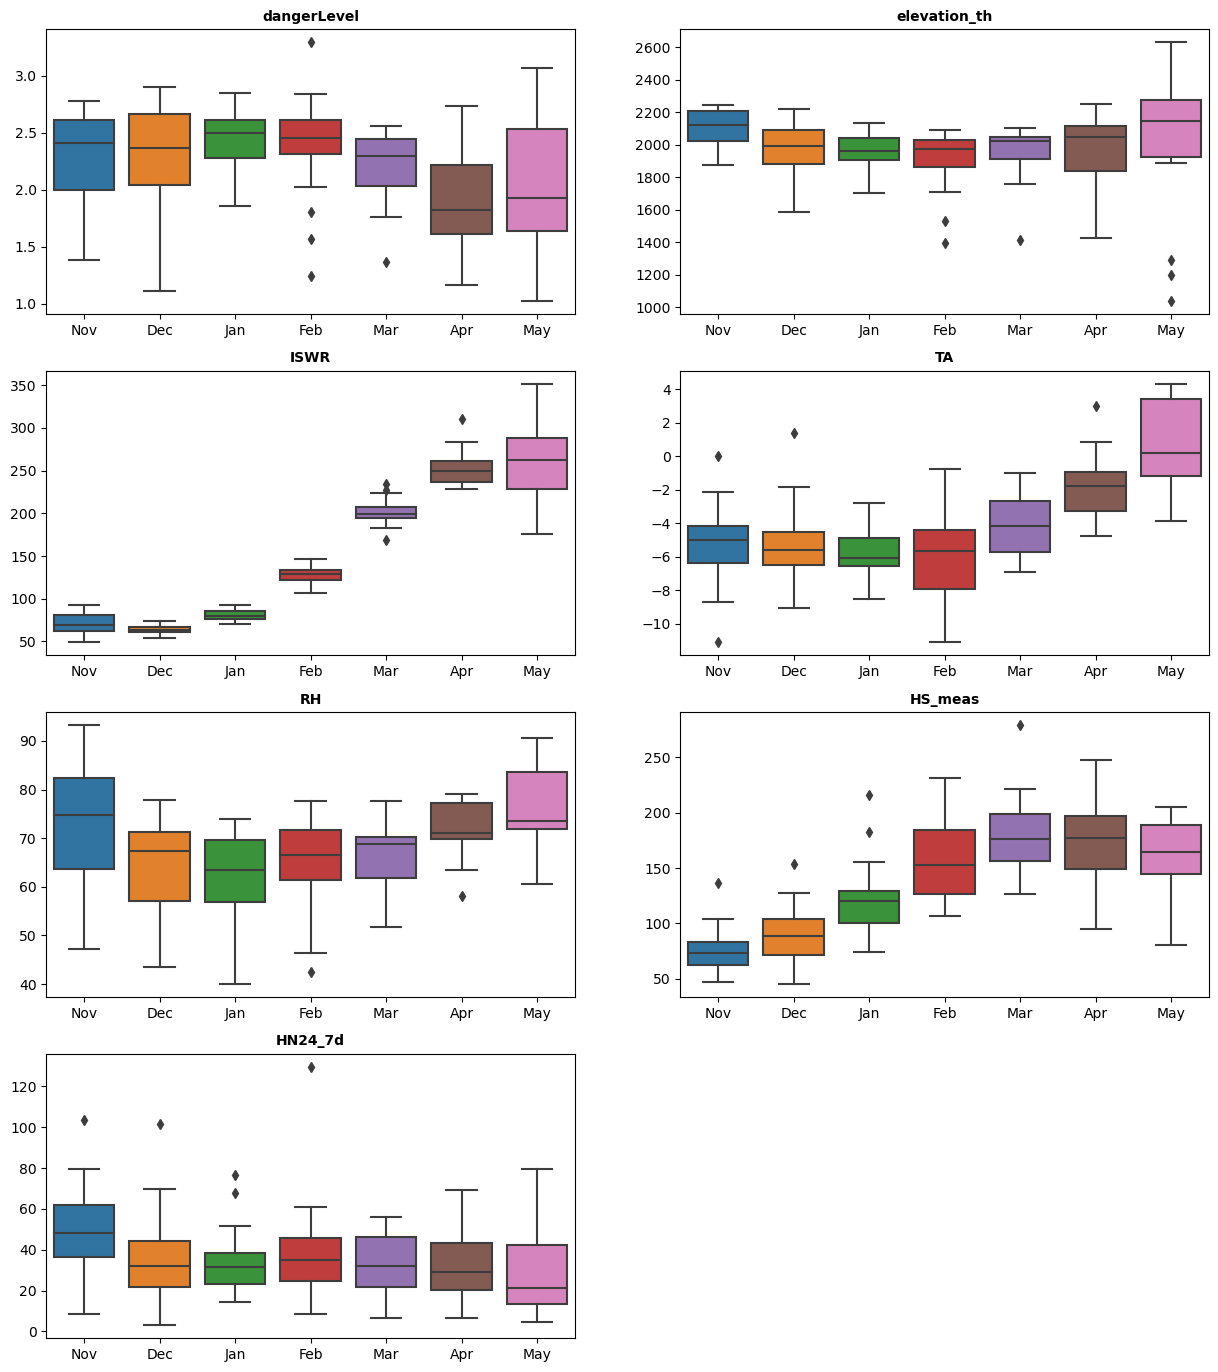

In [205]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(cols)/2)), ncols = 2, figsize = (15, 17))
axes = axes.flatten()

for idx, col in enumerate(cols):
        ax = axes[idx]
        sns.boxplot(y = seasons_2[col],
                    x = seasons_2["month"],
                    ax = ax
                    )
        ax.set(xlabel=None, ylabel = None)
        ax.set_xticklabels(["Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May"])
        ax.set_title("{}".format(col), fontsize = 10, fontweight = "bold")
        
axes[-1].axis("off")

plt.show()

By looking at the means represented the horizontal lines in the middle of each boxplots, the plot from above confirms what we noticed previsoulsy. We can still add some additional observations:

- on average, `elevation_th` tends to go down during winter and to go up from March 
- on average, the relative humidity `RH`, the air temperature `TA` descends until February and go back up from then. 
- the peak of `HS_meas` is indeed in March or April
- `HN24_7d`, the amount of snow fallen within the last 7 days is, on average, higher in November (which is kind of strange). Aside from that, it is higher in February. 

We finally provide here also plots of the means of every feature against the months. 

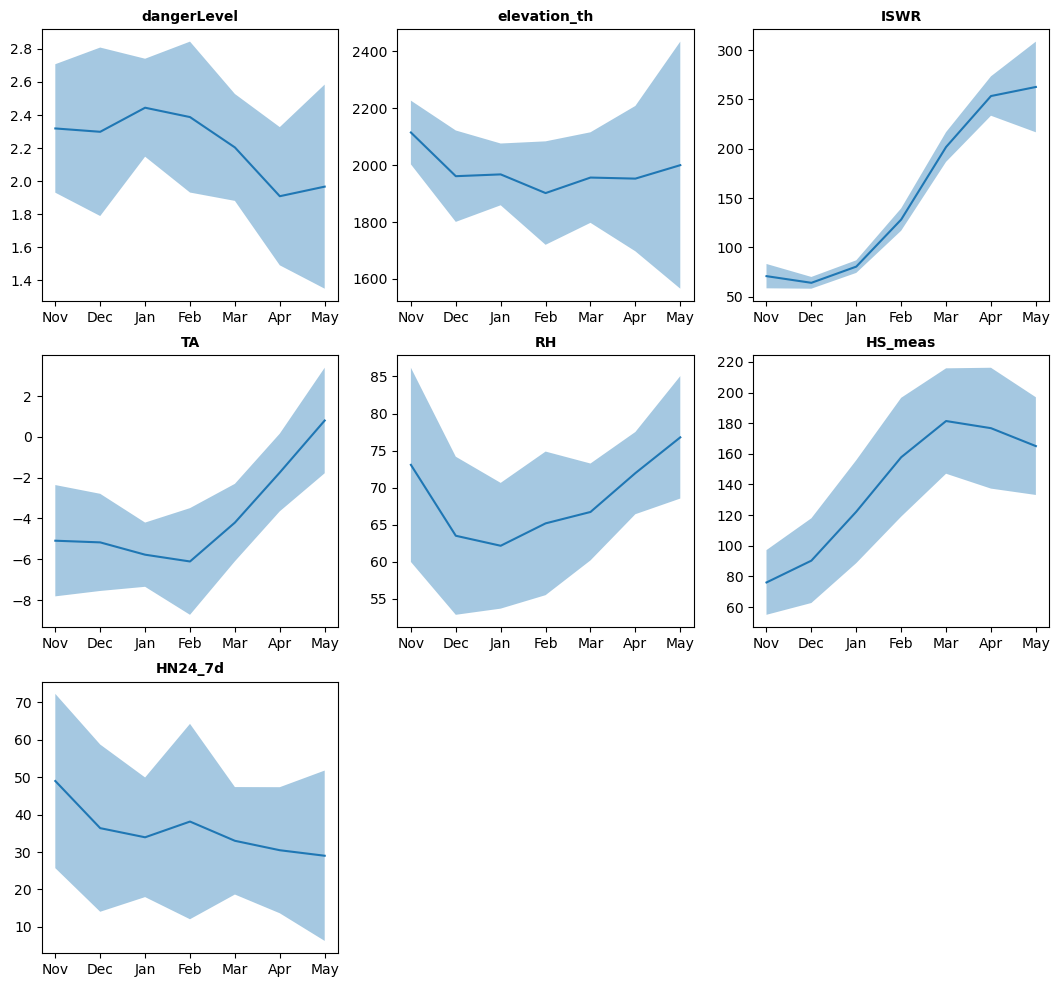

In [206]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (13, 12))
axes = axes.flatten()

monthly_mean = seasons_2.groupby("month").mean()
monthly_std = seasons_2.groupby("month").std()

for idx, col in enumerate(cols):
        ax = axes[idx]
        ax.plot(monthly_mean.index, monthly_mean[col])
        ax.fill_between(monthly_mean.index, monthly_mean[col] + monthly_std[col], monthly_mean[col] - monthly_std[col], alpha = 0.4)
      
        ax.set_xticks(monthly_mean.index)
        ax.set_xticklabels(["Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May"])
        ax.set_title("{}".format(col), fontsize = 10, fontweight = "bold")
        
axes[-1].axis("off")
axes[-2].axis("off")

plt.show()

These plots represent in dark blue the mean, and the light blue surface lies between the curves $mean+std$ and $mean-std$.

We see here that on average, `dangerLevel` is higher in January. 

## C. Feature Engineering 

### C. 1. Cyclic Encoding for Dates

To encode the months, we can either let `month` in its current state, but also use cyclic encoding to emphasize the cyclic character of this feature. The idea is to create two additional variables `month_sin` and `month_cos` based on the values 1, 2, ... in `month` so that every tuple made out of the values in `month_sin`, `month_cos` lies in a circle of radius 1.  

In [207]:
class CyclicEncoding:
    
    def transform(self, dataset):
        
        from sklearn.preprocessing import FunctionTransformer

        def sin_transformer(period):
            return FunctionTransformer(lambda x: np.sin(2 * np.pi * x / period ))


        def cos_transformer(period):
            return FunctionTransformer(lambda x: np.cos(2 * np.pi* x / period  ))

        dataset["month_sin"] = sin_transformer(8).fit_transform(dataset["month"])
        dataset["month_cos"] = cos_transformer(8).fit_transform(dataset["month"])

In [208]:
cyclic_encoding = CyclicEncoding()
cyclic_encoding.transform(data)

We can see the ever tuple $(x,y)$ in $\text{month_sin} \times \text{month_cos} $ lies in a circle of radius 1. 

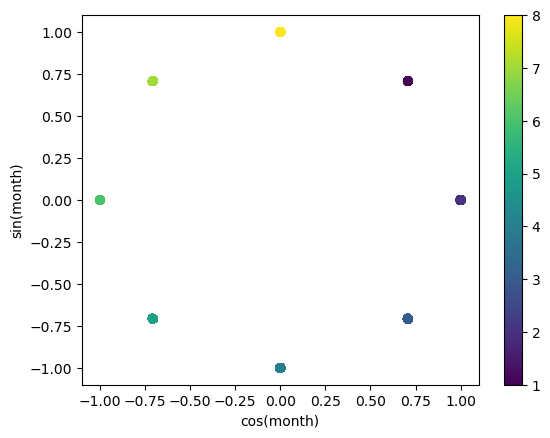

In [209]:
plt.scatter(data["month_sin"], data["month_cos"], c= data.month)
plt.xlabel("cos(month)")
plt.ylabel("sin(month)")
plt.colorbar()
plt.show()

### C. 2. Removing some features

`elevation_th` is de facto part of the outcome of the avalanche forecast like `dangerLevel`. Without `dangerLevel`, `elevation_th` doesn't have a lot of sense. As we aim to predict the danger level, we can remove `elevation_th`. We decide also to remove `elevation_station`.

We can also remove now `month`, because we created `month_sin` and `month_cos`, and also `season`.


In [210]:
class Drop3:
    
    def transform(self, dataset):
        dataset.drop(["elevation_th", "elevation_station", "season", "month"], axis = 1, inplace = True)

In [211]:
drop_elevation_th = Drop3()
drop_elevation_th.transform(data)

In [212]:
diff_col()

Since the beginning:

Columns deleted: ['TSG', 'ccl_pwl_100', 'MS_SN_Runoff', 'sn38_pwl_100', 'datum', 'ccl_pwl', 'sk38_pwl_100', 'ssi_pwl', 'S5', 'ISWR_h', 'ILWR', 'HS_mod', 'MS_Wind', 'SWE', 'ssi_pwl_100', 'zSs', 'elevation_station', 'MS_Rain', 'MS_Sublimation', 'Qr', 'zS4', 'pwl_100', 'sk38_pwl', 'OSWR', 'TSS_mod', 'MS_Evap', 'OLWR', 'elevation_th', 'DW', 'warnreg', 'pwl_100_15', 'ISWR_dir']
Number of columns deleted: 32

Columns added: ['month_cos', 'month_sin']
Number of columns added: 2


### C. 3. Indicator variables

We have seen that a lot of variables have 0 values. Depending on the features, these values can be misinterpreted by our models: they interprete 0 as its value regardless wether a quantity is absent or not, for example the wind.

The features with a lot of zeros are :

In [213]:
var_zeros = ["Ql", "Qg0", "Qs", "pAlbedo", "TSS_meas", "T_bottom", "RH", "MS_Snow", "HS_meas", "hoar_size",
              "wind_trans24", "wind_trans24_7d", "wind_trans24_3d", "HN24", "HN72_24", "HN24_7d", "MS_water", "TS0", "TS1", "TS2",
              "Sd", "Ss", "base_pwl"]

meta_data[meta_data["Feature name"].isin(var_zeros)]

Feature description     Feature name       Type
0                      Sensible heat [W m−2]               Qs   Modelled
1                        Latent heat [W m−2]               Ql   Modelled
3      Ground heat at soil interface [W m−2]              Qg0   Modelled
11                   Parametrized albedo [–]          pAlbedo   Modelled
17                  Surface temperature [∘C]         TSS_meas   Measured
18                   Bottom temperature [∘C]         T_bottom   Modelled
19                     Relative humidity [–]               RH   Measured
23     Solid precipitation rate [kg s−2 h−1]          MS_Snow   Modelled
25                          Snow height [cm]          HS_meas   Measured
26                            Hoar size [cm]        hoar_size   Modelled
27                      24 h wind drift [cm]     wind_trans24   Modelled
28                       3 d wind drift [cm]  wind_trans24_3d  Extracted
29                       7 d wind drift [cm]  wind_trans24_7d  Extracted
30              24 h height of new snow [cm]             HN24   Modelled
31  3 d sum of daily height of new snow [cm]          HN72_24   Modelled
32  7 d sum of daily height of new snow [cm]          HN24_7d  Extracted
34            Total amount of water [kg m−2]         MS_water   Modelled
40           Snow temperature at 0.25 m [∘C]              TS0   Measured
41            Snow temperature at 0.5 m [∘C]              TS1   Measured
42              Snow temperature at 1 m [∘C]              TS2   Measured
44      Deformation rate stability index [–]               Sd   Modelled
48            Sk38 skier stability index [–]               Ss   Modelled
56       Persistent weak layer at bottom [–]         base_pwl    Profile

For the temperature, the indices or classes, energy features or humidity features, these 0 values must be interpreted as such. It is the same `HS_meas` and `HS_water` because they express a variation according to time (we know this because there is a term $s^{-2}$ in their description.

So we will create booleans variables from the following features: 

In [214]:
booleans = ["HS_meas", "hoar_size", "wind_trans24", "wind_trans24_3d", "wind_trans24_7d", "HN24", "HN72_24", "HN24_7d"]

In [215]:
class IndicatorEncoding:
     def transform(self, dataset):
            for var in booleans:
                dataset["No " + var] = (dataset[var] == 0).astype(int)

In [216]:
indicator_encoding = IndicatorEncoding()

indicator_encoding.transform(data)

In [217]:
diff_col()

Since the beginning:

Columns deleted: ['TSG', 'ccl_pwl_100', 'MS_SN_Runoff', 'sn38_pwl_100', 'datum', 'ccl_pwl', 'sk38_pwl_100', 'ssi_pwl', 'S5', 'ISWR_h', 'ILWR', 'HS_mod', 'MS_Wind', 'SWE', 'ssi_pwl_100', 'zSs', 'elevation_station', 'MS_Rain', 'MS_Sublimation', 'Qr', 'zS4', 'pwl_100', 'sk38_pwl', 'OSWR', 'TSS_mod', 'MS_Evap', 'OLWR', 'elevation_th', 'DW', 'warnreg', 'pwl_100_15', 'ISWR_dir']
Number of columns deleted: 32

Columns added: ['No hoar_size', 'No wind_trans24_7d', 'No HN24_7d', 'No HN72_24', 'month_cos', 'No wind_trans24', 'No HS_meas', 'No wind_trans24_3d', 'No HN24', 'month_sin']
Number of columns added: 10


In [218]:
data.shape

(196862, 51)

### C. 4. Log Transformations

We observed that some variables had distributions close to Gaussian when transformed via logarithms. We decided to transform all variables in the `left-skew` list using the `np.log1p` transformation, and all right-skewed variables using `-log1p(1 - x)`. As for distributions that are centered or already close to Gaussian, we do nothing. What remains is to decide how to handle the features in the list `others`.



In [219]:
# Remove DW from the others list because we have deleted it above
others.remove("MS_Rain")

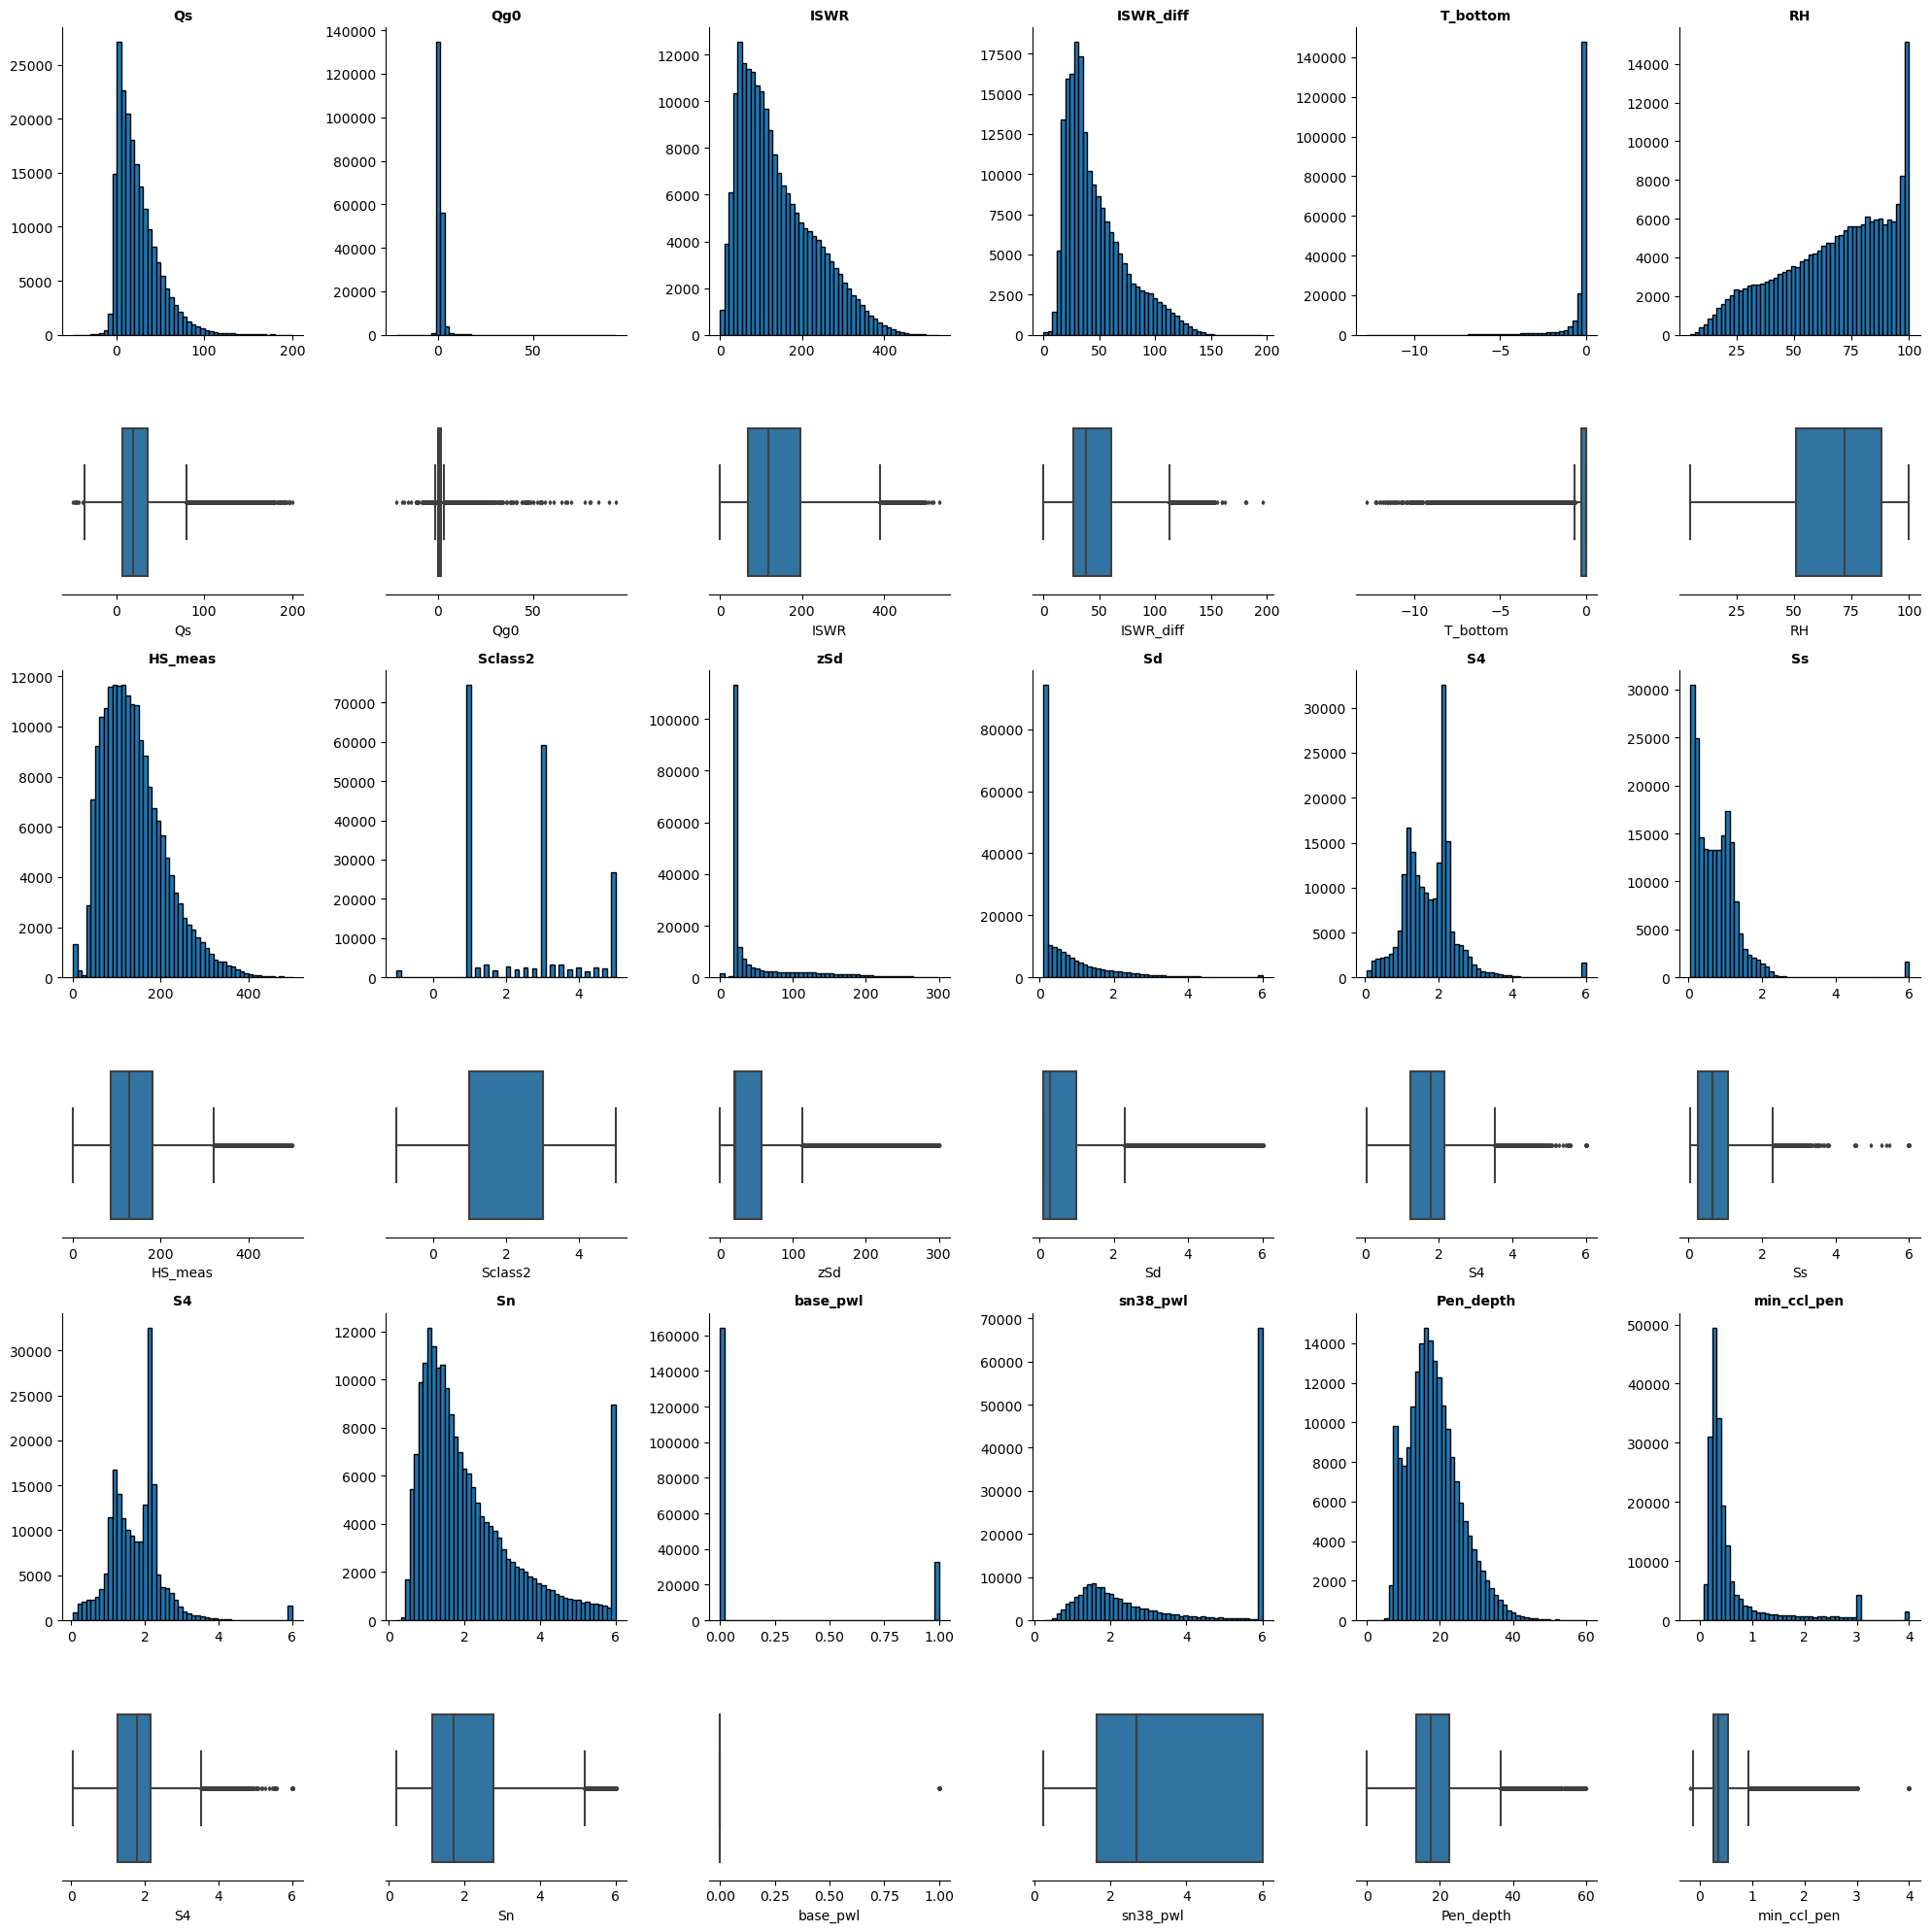

In [220]:
show_hist(data, others, n_cols = 6, figsize=(20,20))

We decide to observe the log transformations of: `ISWR`, `ISWR_diff`, `HS_meas`, `zS4` and `Pen_depth`

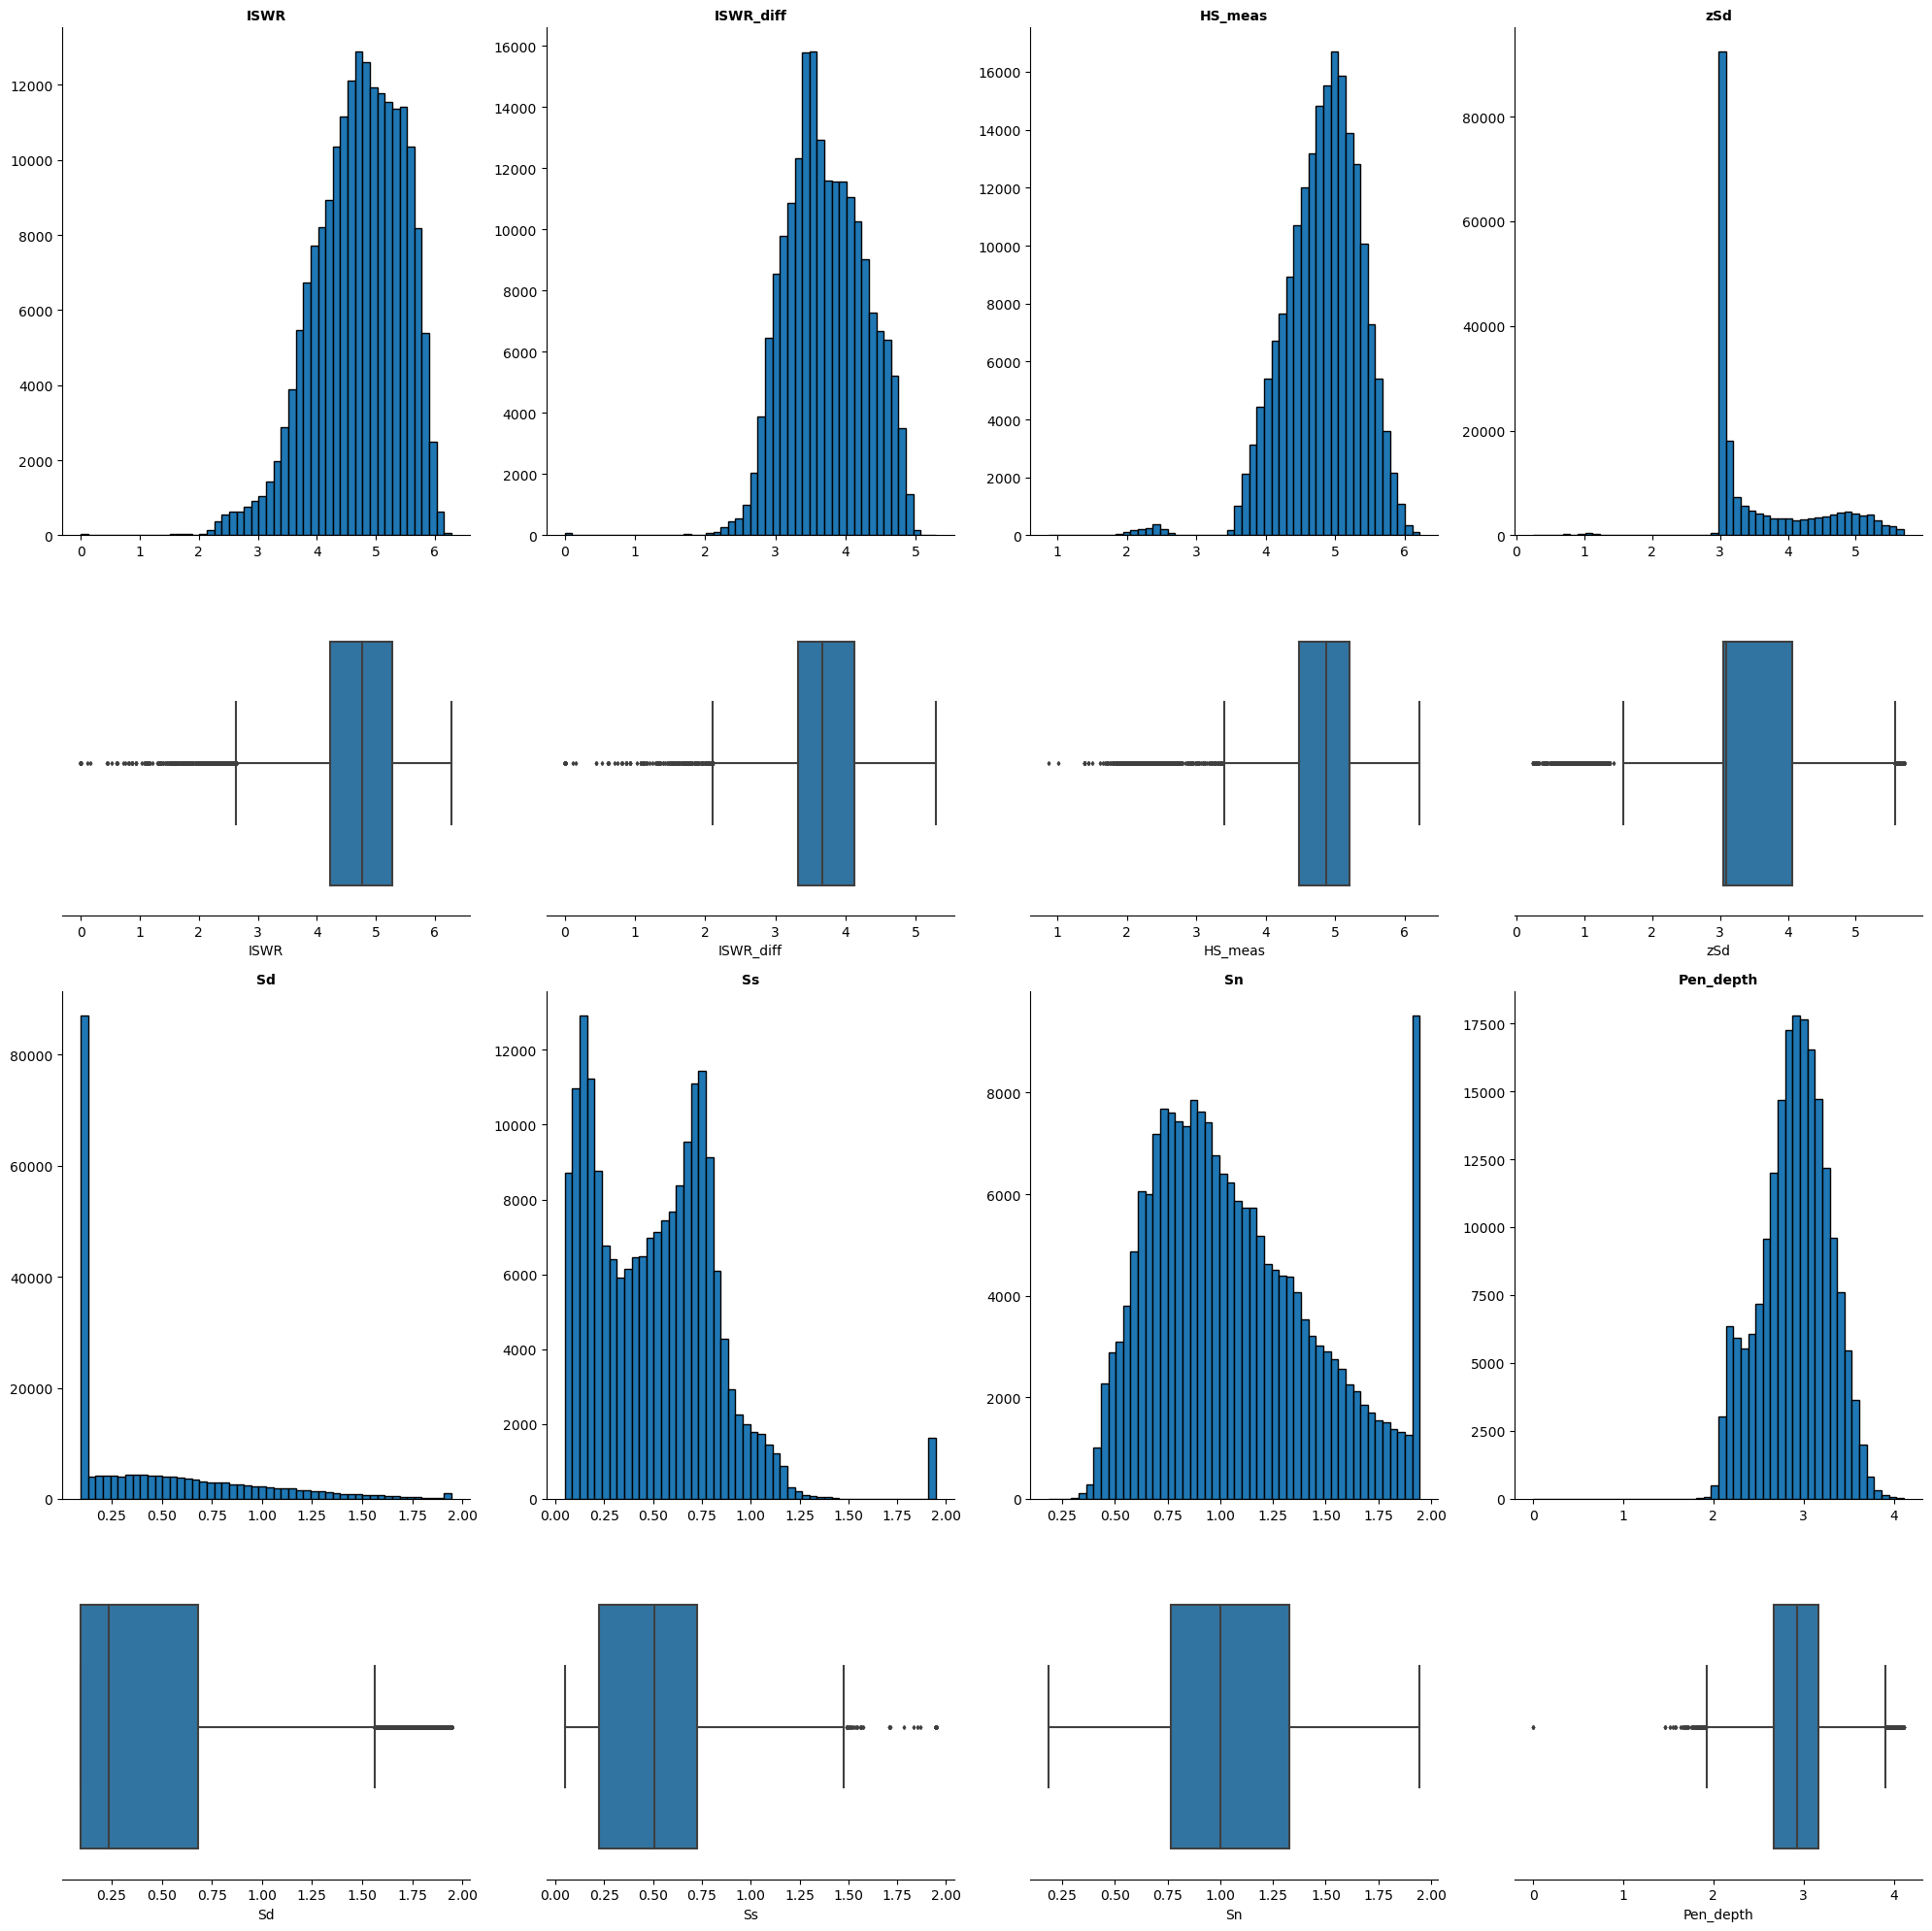

In [221]:
show_hist(data, ["ISWR", "ISWR_diff", "HS_meas", "zSd", "Sd", "Ss", "Sn", "Pen_depth"], figsize=(20,20),
          n_cols = 4,
         function = np.log1p)

We see that the log transformations make the distributions of  `ISWR`, `ISWR_diff`, `HS_meas`, and `Pen_depth` roughly symmetrical or with a bell-shape. So we transform these features.

In [222]:
class LogTransformation:
    
    def transform(self, dataset):
        
        for var in left_skew + ["ISWR", "ISWR_diff", "HS_meas", "Pen_depth"]:
            dataset[var] = np.log1p(dataset[var])
            
        for var in right_skew: 
            dataset[var] = -np.log1p(-dataset[var])

In [223]:
log_transform = LogTransformation()

log_transform.transform(data)

### C. 5. Feature Encoding

Do we still have categorical variables ? And if so, would it be relevant to encode them using One-Hot Encoding ? 

In [224]:
categorical = data.select_dtypes(include = "object").columns.to_list()
categorical 

['station_code', 'sector_id']

As the purpose of our project is to predict the avalanche danger level according to variables recorded by the SLF, `sector_id` and `station_code` are not important. We remove them.

In [225]:
class Drop4:
    
    def transform(self, dataset):
        dataset.drop(["station_code", "sector_id"], axis = 1, inplace = True) 

In [226]:
drop4 = Drop4()

drop4.transform(data)

## D. Preprocessing steps

### D. 1. Apply the same transformations on the test set

Since the data split, we have applied a lot of transformations on our train set only. We need now to apply them on the test set as well except the Outlier Removal part. 

In [227]:
MC = MergeClasses()
E = Elevation()
RHC = RemoveHighCorrelated()
Drop1 = Drop1()
DropROT2 = DropROT2()
DropMV = DropMissingValues()
Imputers = Imputers()
RLV = RemoveLowVariance()
Drop2 = Drop2()
DE = DatesEncoding()
CE = CyclicEncoding()
Drop3 = Drop3()
IndE = IndicatorEncoding()
LogT = LogTransformation()
Drop4 = Drop4()

MC.transform(data_te)
E.transform(data_te)
RHC.transform(data_te)
Drop1.transform(data_te)
data_te = DropROT2.transform(data_te)
data_te = DropMV.transform(data_te)
Imputers.transform(data_te)
RLV.transform(data_te)
Drop2.transform(data_te)
DE.transform(data_te)
CE.transform(data_te)
Drop3.transform(data_te)
IndE.transform(data_te)
LogT.transform(data_te)
Drop4.transform(data_te)

We verify that both sets have the same columns and in the same order.

In [228]:
data_te.columns.to_list() == data.columns.to_list()

True

In [229]:
data_te.shape

(35141, 49)

In [230]:
data.shape

(196862, 49)

Let's see what percentage represent the samples in `data_te` now. 

In [231]:
percentage_te = data_te.shape[0]/(data.shape[0] + data_te.shape[0]) * 100

print("The test set represents now {:.2f}% of the data".format(percentage_te))

The test set represents now 15.15% of the data


Which is acceptable.

### D. 2. Save the preprocessed sets

We save the two sets in csv files. 

In [232]:
data.to_csv("../datasets/train_data.csv", index = False)
data_te.to_csv("../datasets/test_data.csv", index = False)

## E) Bibliography

<a id="ref1"></a> [1] [SLF - Interpretation Guide (PDF)](https://www.slf.ch/fileadmin/user_upload/SLF/Lawinenbulletin_Schneesituation/Wissen_zum_Lawinenbulletin/Interpretationshilfe/Interpretationshilfe_EN.pdf), p. 13.
  
<a id="ref2"></a>[2] [SLF - Interpretation Guide (PDF)](https://www.slf.ch/fileadmin/user_upload/SLF/Lawinenbulletin_Schneesituation/Wissen_zum_Lawinenbulletin/Interpretationshilfe/Interpretationshilfe_EN.pdf), p. 5.

<a id="ref3"></a>[3] [SLF - Interpretation Guide (PDF)](https://www.slf.ch/fileadmin/user_upload/SLF/Lawinenbulletin_Schneesituation/Wissen_zum_Lawinenbulletin/Interpretationshilfe/Interpretationshilfe_EN.pdf), p. 27-32.

<a id="ref4"></a>[4] [SLF - Interpretation Guide (PDF)](https://www.slf.ch/fileadmin/user_upload/SLF/Lawinenbulletin_Schneesituation/Wissen_zum_Lawinenbulletin/Interpretationshilfe/Interpretationshilfe_EN.pdf), p. 7.

<a id="ref5"></a>[5] [SLF - Subdivision of danger levels in the avalanche bulletin](https://www.slf.ch/en/news/subdivision-of-danger-levels-in-the-avalanche-bulletin/)

<a id="ref6"></a>[6] [SLF - Interpretation Guide (PDF)](https://www.slf.ch/fileadmin/user_upload/SLF/Lawinenbulletin_Schneesituation/Wissen_zum_Lawinenbulletin/Interpretationshilfe/Interpretationshilfe_EN.pdf), p. 18.

<a id="ref7"></a>[7] [SLF - Interpretation Guide (PDF)](https://www.slf.ch/fileadmin/user_upload/SLF/Lawinenbulletin_Schneesituation/Wissen_zum_Lawinenbulletin/Interpretationshilfe/Interpretationshilfe_EN.pdf), p. 14-16.

<a id="ref8"></a>[8] [SLF - Information about snow profiles](https://www.slf.ch/en/avalanche-bulletin-and-snow-situation/snow-maps/information-about-snow-profiles/)

<a id="ref9"></a>[9] [SLF- Avalanche Forecast, 2025-03-15, 5 pm](https://www.slf.ch/fileadmin/avalanche_bulletin/pdf/2025/03/Bulletin_2025-03-15_17-00_en.pdf?time=1751982262)

<a id="ref10"></a>[10] [SLF - Interpretation Guide (PDF)](https://www.slf.ch/fileadmin/user_upload/SLF/Lawinenbulletin_Schneesituation/Wissen_zum_Lawinenbulletin/Interpretationshilfe/Interpretationshilfe_EN.pdf), p. 32.

<a id="ref11"></a>[11] Pérez-Guillén, C., Techel, F., Hendrick, M., Volpi, M., van Herwijnen, A., Olevski, T., Obozinski, G., Pérez-Cruz, F., Schweizer, J. (2022). Weather, snowpack and danger ratings data for automated avalanche danger level predictions.  EnviDat.  https://www.doi.org/10.16904/envidat.330.

<a id="ref12"></a>[12] [SLF - Description of automated stations](https://www.slf.ch/en/avalanche-bulletin-and-snow-situation/measured-values/description-of-automated-stations/)

<a id="ref13"></a>[13]  Pérez-Guillén, C., Techel, F., Hendrick, M., Volpi, M., van Herwijnen, A., Olevski, T., Obozinski, G., Pérez-Cruz, F., and Schweizer, J.: Data-driven automated predictions of the avalanche danger level for dry-snow conditions in Switzerland, Nat. Hazards Earth Syst. Sci., 22, 2031–2056, https://doi.org/10.5194/nhess-22-2031-2022, 2022.


## F) Appendix

You can find below to webpages I consulted:

https://www.youtube.com/watch?time_continue=8&v=r3EGMZJP6U4&embeds_referring_euri=https%3A%2F%2Fwww.google.com%2Fsearch%3Fq%3Dhow%2Bto%2Bdisplay%2Ba%2Bpng%2Bfile%2Bin%2Ba%2Bmarkdown%2Bcell%2Bjupyter%2Bnotebook%26rlz%3D1C5CHFA_enCH890CH890%26oq%3Dhow%2Bto&source_ve_path=Mjg2NjY

https://www.slf.ch/fileadmin/avalanche_bulletin/pdf/2025/03/Bulletin_2025-03-15_17-00_en.pdf?time=1751982262

https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

https://stackoverflow.com/questions/62917882/convert-datetime64ns-utc-pandas-column-to-datetime

https://stackoverflow.com/questions/53947196/groupby-class-and-count-missing-values-in-features

https://stackoverflow.com/questions/43759921/pandas-rename-column-by-position

https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting

https://stackoverflow.com/questions/10035446/how-can-i-make-a-blank-subplot-in-matplotlib

https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

https://stackoverflow.com/questions/59130959/how-to-convert-list-of-lists-into-list-python